# CITS4403 - P2P Modelling

This notebook demonstrates a complex P2P model using agent gossip protocols (GNUTELLA-like) and graph-theory.

## Steps to Run
1. Run the first Cell and generate a Graph to use for the current runtime.
2. Run the Initiate Cell to propogate file-pieces.
3. Run the Simulate Cell to decide on the type of Simulation, Scenario and other Agent factors.

In [ ]:
import sys, os, pathlib
project_root = pathlib.Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.graph import nxgraph
import src.agent as agent_module
from utils.plotter import draw_graph, draw_gossip_step_by_step, start_new_run, create_round_gif
from utils.simulator import simulate_round, get_network_stats, reset_simulation

import ipywidgets as widgets
from IPython.display import display, clear_output

graph_generated = False
graph_type = widgets.Dropdown(
    options=[('Barabasi-Albert (Scale-free)', 'BA'), ('Erdos-Renyi (Random)', 'ER')],
    value='BA',
    description='Graph Type:',
    style={'description_width': 'initial'}
)
num_nodes = widgets.IntSlider(
    value=12,
    min=5,
    max=100,
    step=1,
    description='Nodes:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
ba_edges = widgets.IntSlider(
    value=2,
    min=1,
    max=10,
    step=1,
    description='BA Edges:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
er_prob = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=0.5,
    step=0.01,
    description='ER Probability:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
lower_bandwidth = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Min Bandwidth:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
upper_bandwidth = widgets.IntSlider(
    value=100,
    min=50,
    max=200,
    step=5,
    description='Max Bandwidth:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
random_seed = widgets.IntSlider(
    value=42,
    min=0,
    max=1000,
    step=1,
    description='Random Seed:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
num_seeders = widgets.IntSlider(
    value=1,
    min=1,
    max=100,
    step=1,
    description='Seeders:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
file_pieces = widgets.IntSlider(
    value=15,
    min=5,
    max=50,
    step=1,
    description='File Pieces:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
generate_btn = widgets.Button(
    description='Generate Graph',
    button_style='primary',
    layout=widgets.Layout(width='150px')
)
output_area = widgets.Output()

def update_controls_visibility(change):
    if change['new'] == 'BA':
        ba_edges.layout.display = 'flex'
        er_prob.layout.display = 'none'
        ba_edges.description = 'BA Edges:'
        er_prob.description = 'ER Probability: (inactive)'
    else:  # ER
        ba_edges.layout.display = 'none'
        er_prob.layout.display = 'flex'
        ba_edges.description = 'BA Edges: (inactive)'
        er_prob.description = 'ER Probability:'

    ba_edges.value = ba_edges.value
    er_prob.value = er_prob.value

graph_type.observe(update_controls_visibility, names='value')

update_controls_visibility({'new': 'BA'})

# Create and setup the graph (ER or BA)
def on_generate_clicked(b):
    global graph_generated, G, FILE_PIECES
    
    generate_btn.description = "Generating..."
    generate_btn.disabled = True
    
    try:
        with output_area:
            clear_output(wait=True)
            print("Generating graph...")
            
            # Create new graph
            G = nxgraph()
            
            if graph_type.value == 'BA':
                G.BA_graph(
                    nodes=num_nodes.value, 
                    edges=ba_edges.value, 
                    seed=random_seed.value, 
                    weighted=True, 
                    lower_ut=lower_bandwidth.value, 
                    upper_ut=upper_bandwidth.value
                )
                print(f"Generated BA graph with {num_nodes.value} nodes, {ba_edges.value} edges per new node")
            else:  # ER
                G.ER_graph(
                    nodes=num_nodes.value, 
                    prob=er_prob.value, 
                    weighted=True, 
                    lower_ut=lower_bandwidth.value, 
                    upper_ut=upper_bandwidth.value
                )
                print(f"Generated ER graph with {num_nodes.value} nodes, p={er_prob.value}")
            
            agent_module.assign_n_seeders(G.graph, n=num_seeders.value, seed=random_seed.value)
            
            globals()['G'] = G
            globals()['FILE_PIECES'] = file_pieces.value
            
            print(f"has {G.graph.number_of_nodes()} nodes and {G.graph.number_of_edges()} edges")
            print(f"has {num_seeders.value} seeders, {file_pieces.value} file pieces")
            
            draw_graph(G.graph, total_pieces=file_pieces.value)
            graph_generated = True
            
    except Exception as e:
        print(f"Error generating: {e}")
    finally:
        generate_btn.description = "Generate Graph"
        generate_btn.disabled = False
generate_btn.on_click(on_generate_clicked)
# Layouts
controls = widgets.VBox([
    widgets.HTML("<h1>Graph Configuration</h1>"),
    widgets.HBox([graph_type, num_nodes]),
    widgets.HBox([ba_edges, er_prob]),
    widgets.HBox([lower_bandwidth, upper_bandwidth]),
    widgets.HBox([random_seed, num_seeders]),
    widgets.HBox([file_pieces, generate_btn]),
    output_area
])
display(controls)
print("Use the controls above to configure and generate your graph.")
print("Once you click 'Generate Graph', you can proceed to the next cell.")
print("The graph will be available for use in subsequent cells.")


Use the controls above to configure and generate your graph.
Once you click 'Generate Graph', you can proceed to the next cell.
The graph will be available for use in subsequent cells.


In [2]:
# Init
# RUN THE PREVIOUS CELL FIRST

# Check if graph has been generated
if 'G' not in globals() or not graph_generated:
    print("No Graph")
    print("Run the first cell, click 'Generate Graph' to create a network.")
    raise RuntimeError("Graph must be generated before proceeding")

print(f"Using graph with {G.graph.number_of_nodes()} nodes and {G.graph.number_of_edges()} edges")

reset_simulation(G.graph, FILE_PIECES, seed=42)
agent_module.initialize_file_sharing(G.graph, FILE_PIECES, seed=42)
print(f"Init file sharing with {FILE_PIECES} pieces")
print("\nNode status:")
for node in G.graph.nodes():
    info = agent_module.get_agent_info(G.graph, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/{FILE_PIECES} pieces - Complete: {info['is_complete']}")

print(f"\nTotal pieces in network: {sum(len(G.graph.nodes[node].get('file_pieces', set())) for node in G.graph.nodes())}")

# Show network statistics
stats = get_network_stats(G.graph, FILE_PIECES)
print(f"\nNetwork statistics:")
print(f"Total nodes: {stats['total_nodes']}")
print(f"Total edges: {stats['total_edges']}")
print(f"Seeders: {stats['seeders']}")
print(f"Leechers: {stats['leechers']}")
print(f"Hybrids: {stats['hybrids']}")
print(f"Completion rate: {stats['completion_rate']:.1%}")


Using graph with 12 nodes and 20 edges
Init file sharing with 15 pieces

Node status:
Node 0: leecher - 0/15 pieces - Complete: False
Node 1: leecher - 0/15 pieces - Complete: False
Node 2: leecher - 0/15 pieces - Complete: False
Node 3: leecher - 0/15 pieces - Complete: False
Node 4: leecher - 0/15 pieces - Complete: False
Node 5: leecher - 0/15 pieces - Complete: False
Node 6: leecher - 0/15 pieces - Complete: False
Node 7: leecher - 0/15 pieces - Complete: False
Node 8: leecher - 0/15 pieces - Complete: False
Node 9: leecher - 0/15 pieces - Complete: False
Node 10: seeder - 15/15 pieces - Complete: True
Node 11: leecher - 0/15 pieces - Complete: False

Total pieces in network: 15

Network statistics:
Total nodes: 12
Total edges: 20
Seeders: 1
Leechers: 11
Hybrids: 0
Completion rate: 0.0%


In [ ]:
# Will add simulation control cell here

Starting Model graph with 12 nodes and 20 edges
Initial: 11 leechers incomplete, 0.0% completion rate

 Round 1
Messages: 3
Transfers: 0
Progress: 11 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_001_gossip_steps.png


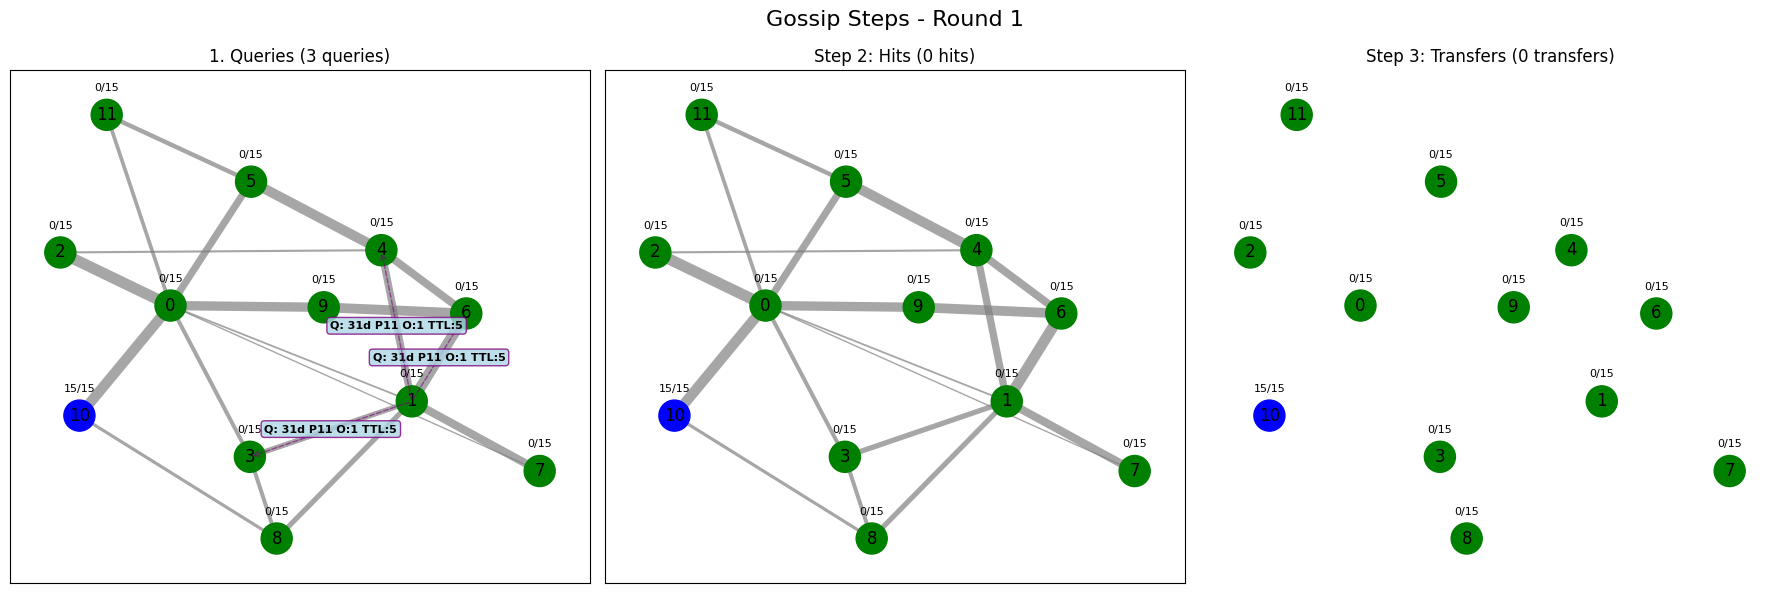


 Round 2
Messages: 7
Transfers: 0
Progress: 11 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_002_gossip_steps.png


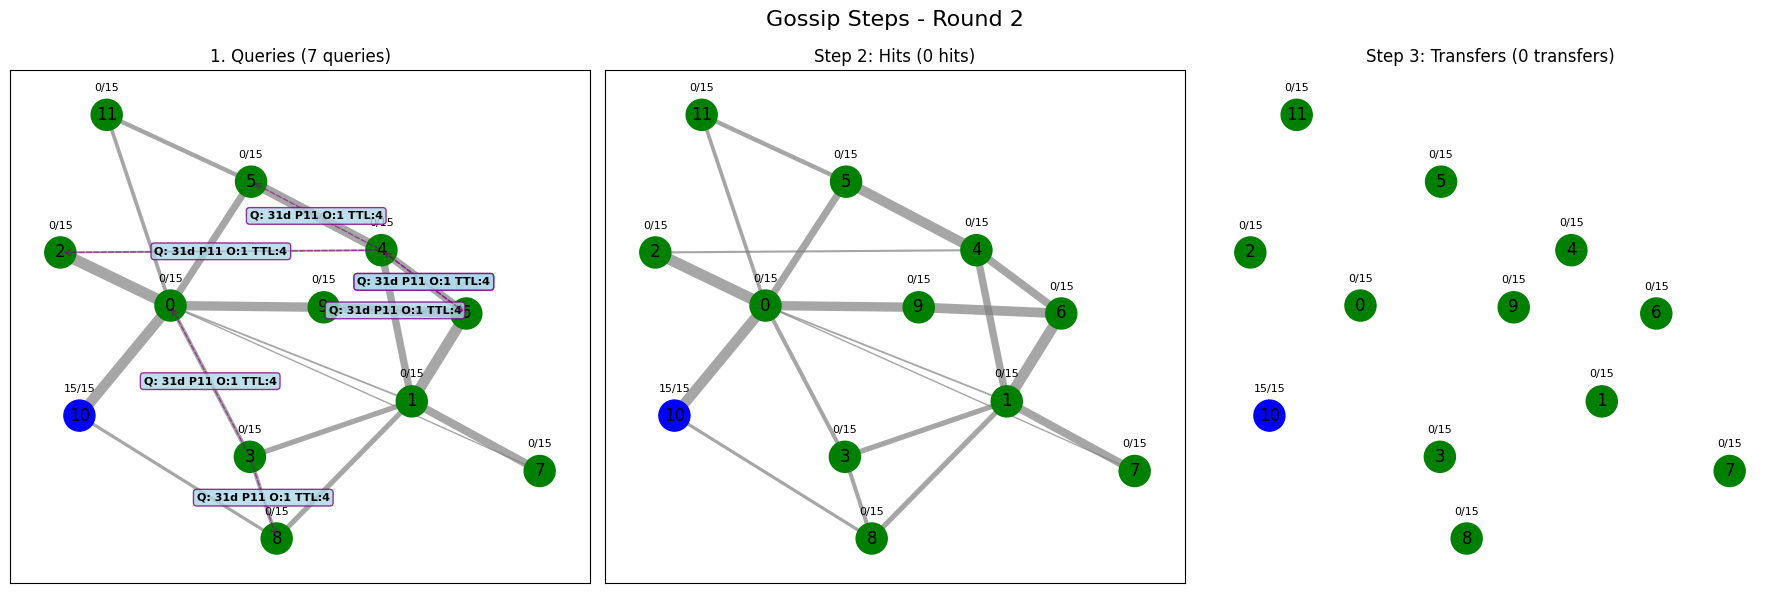


 Round 3
Messages: 13
Transfers: 0
Progress: 11 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_003_gossip_steps.png


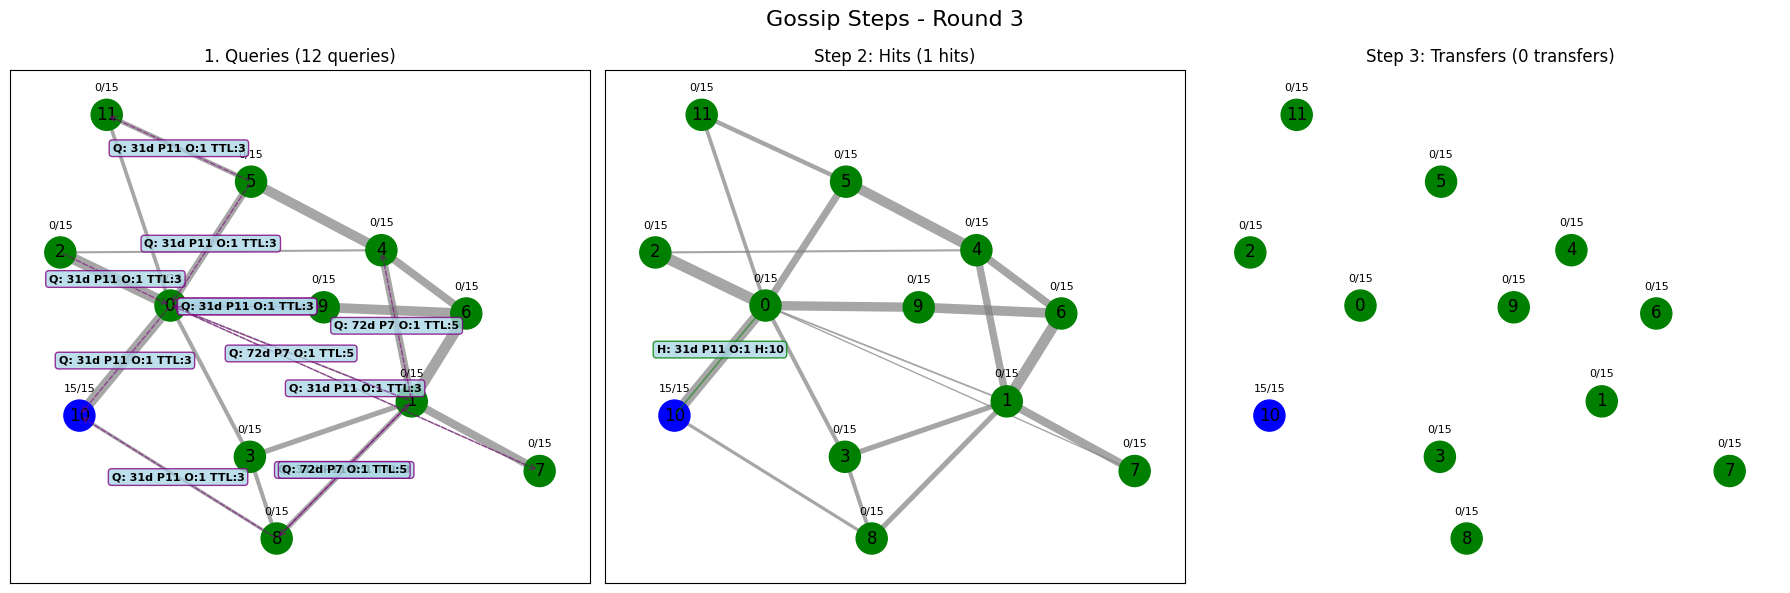


 Round 4
Messages: 13
Transfers: 0
Progress: 11 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_004_gossip_steps.png


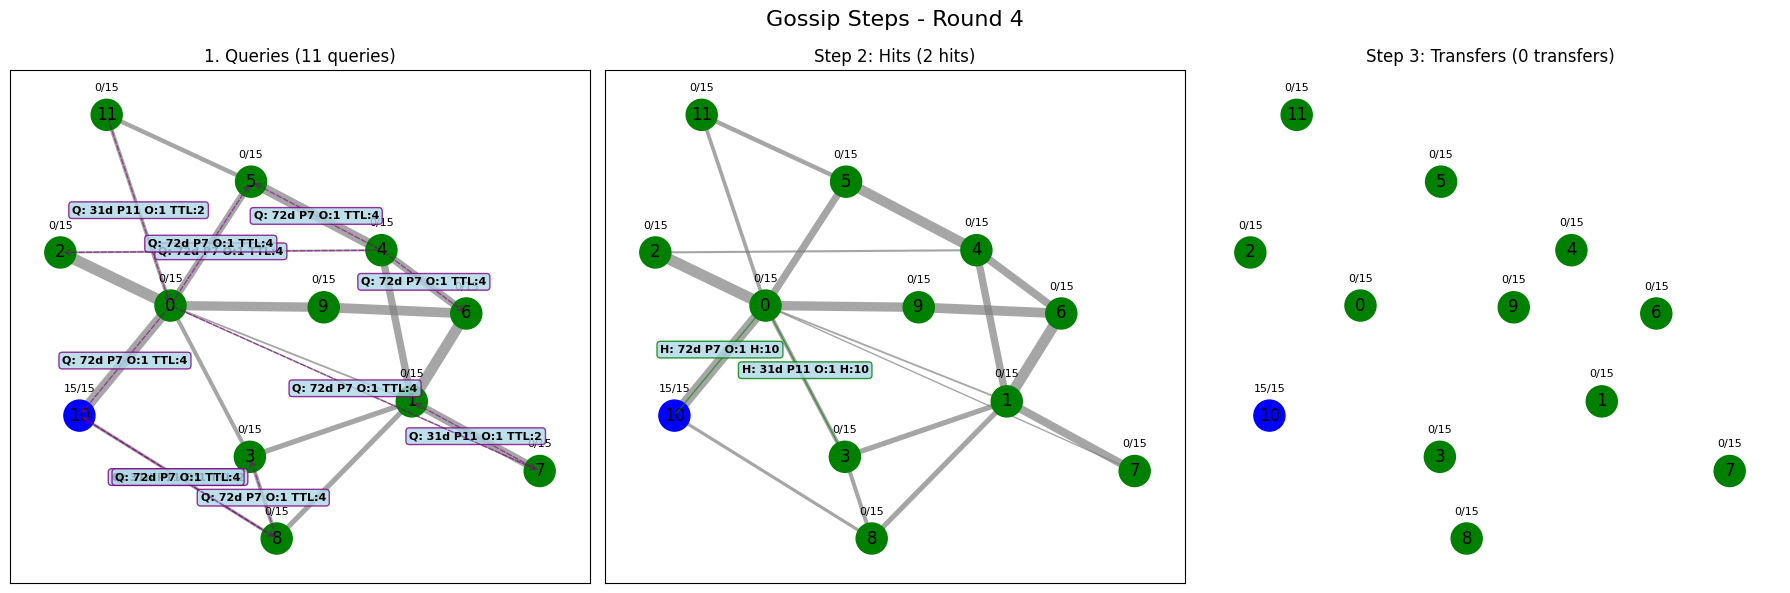


 Round 5
Messages: 11
Transfers: 2
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 11: 10 to >> 1
  Piece 7: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_005_gossip_steps.png


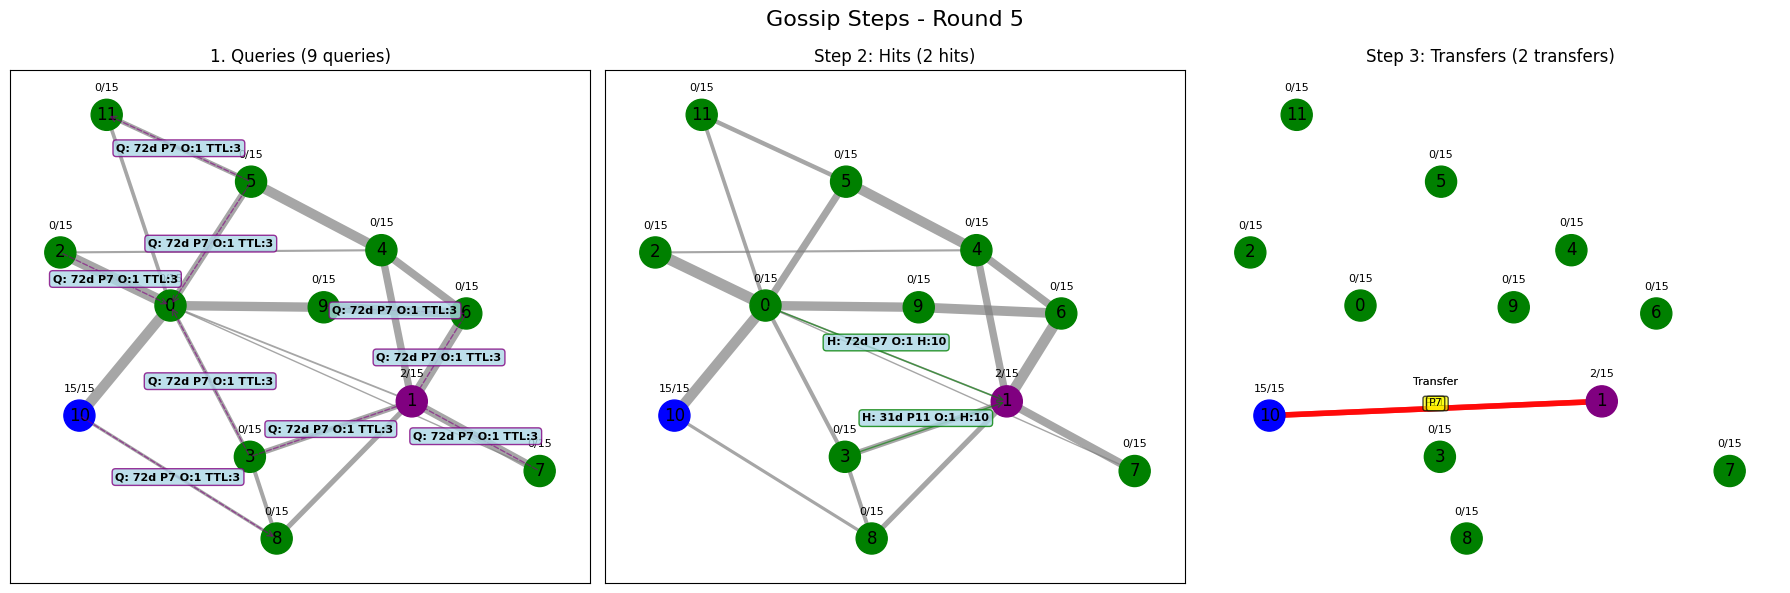


 Round 6
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_006_gossip_steps.png


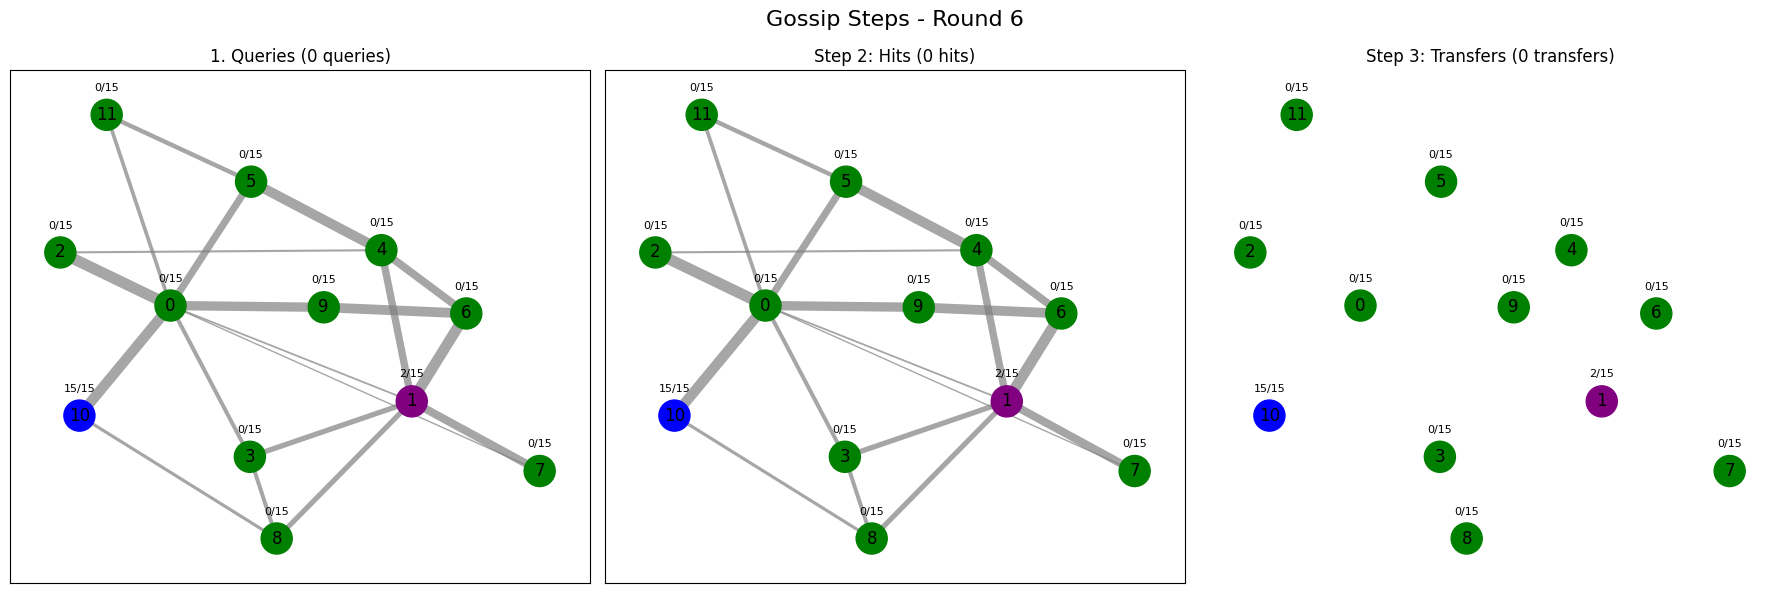


 Round 7
Messages: 3
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_007_gossip_steps.png


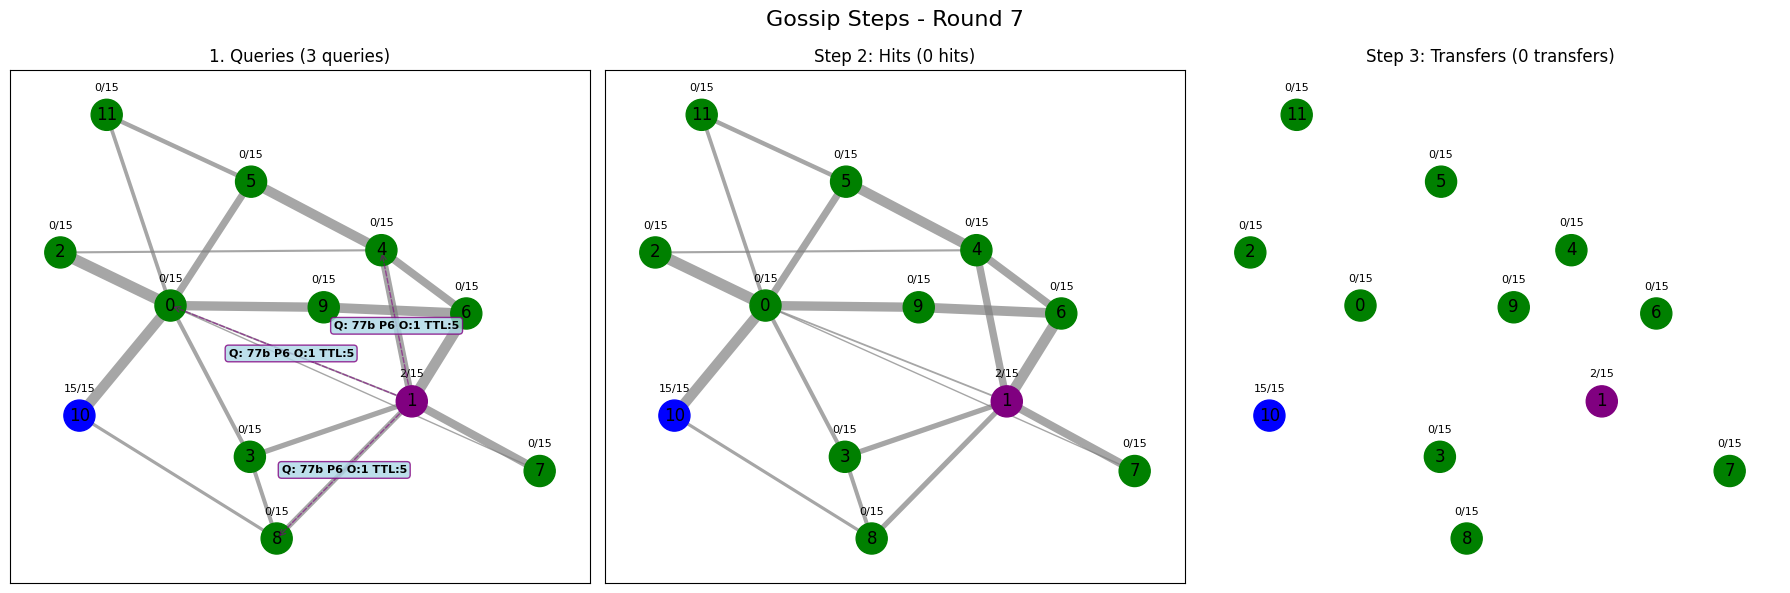


 Round 8
Messages: 9
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_008_gossip_steps.png


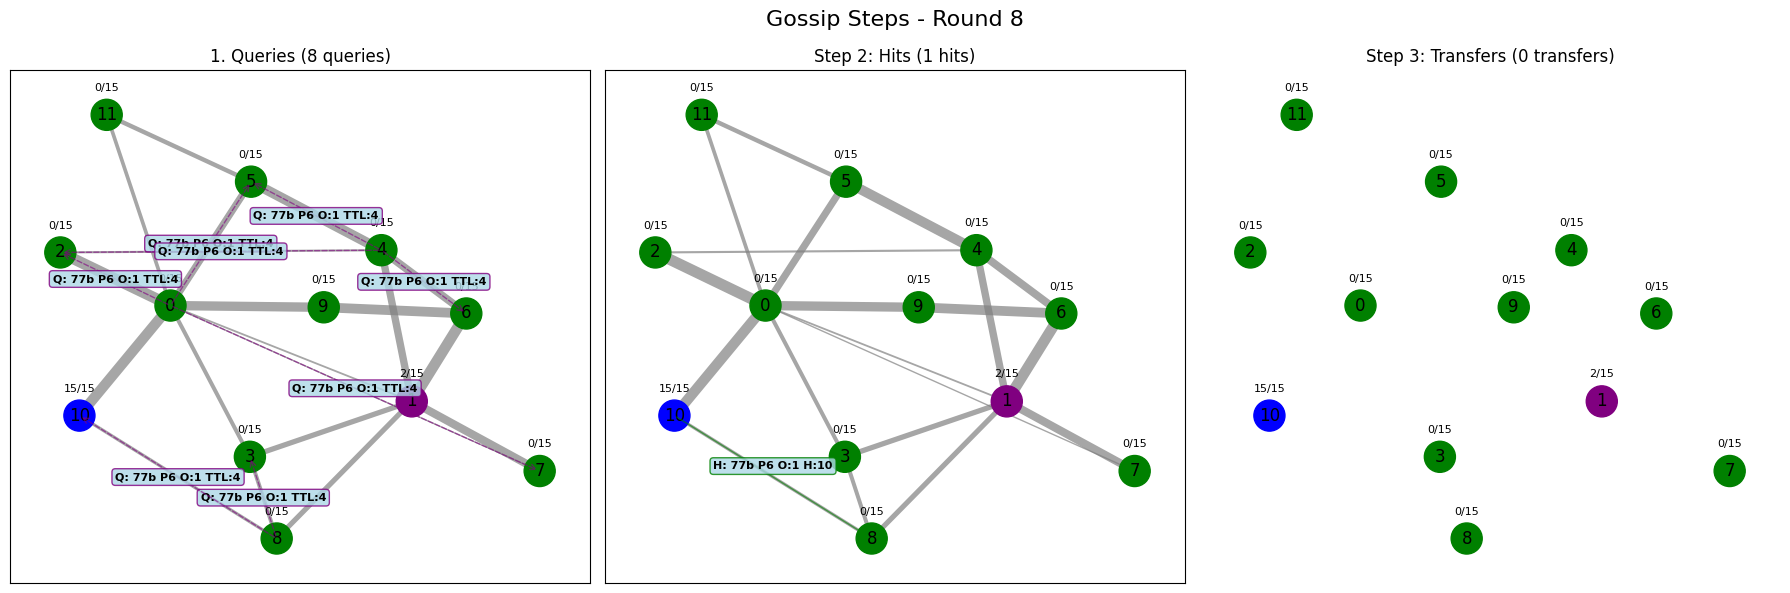


 Round 9
Messages: 13
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 6: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_009_gossip_steps.png


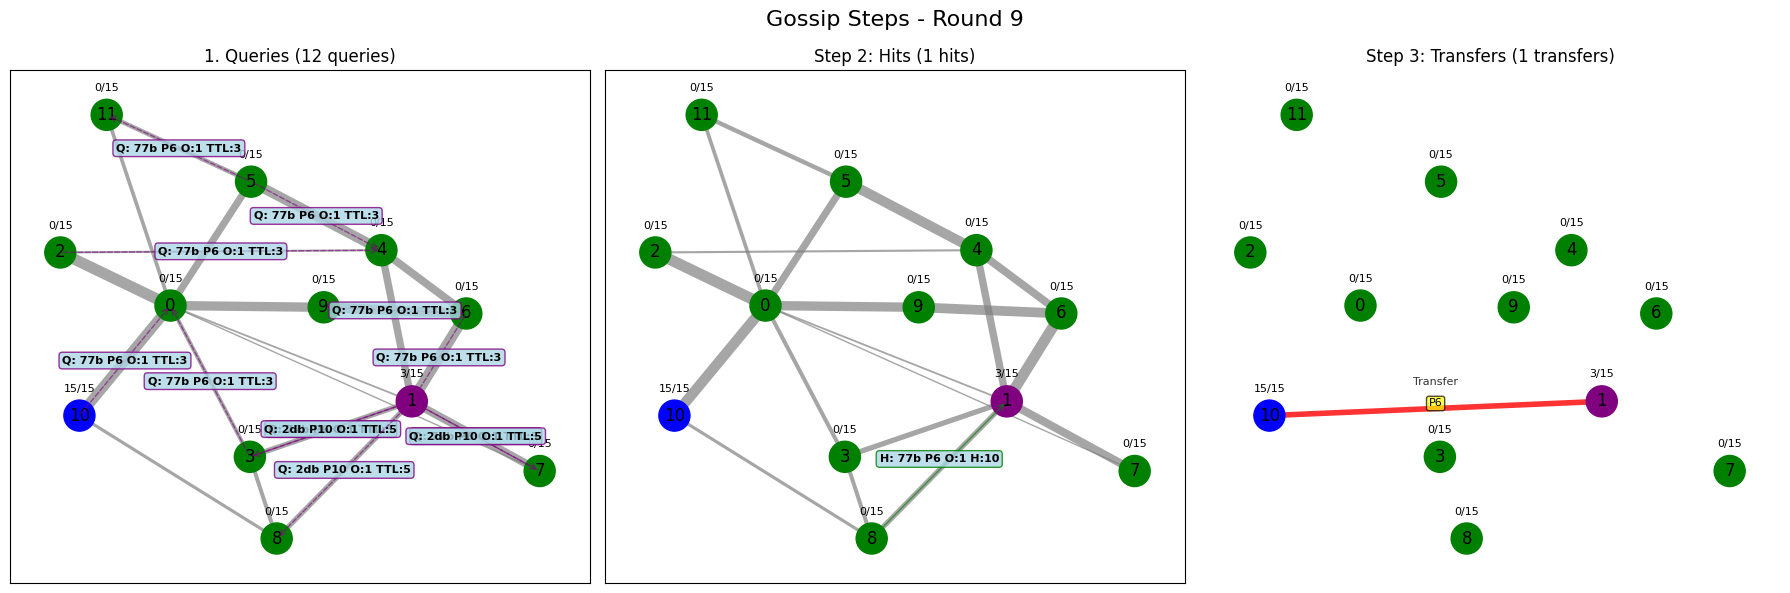


 Round 10
Messages: 6
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_010_gossip_steps.png


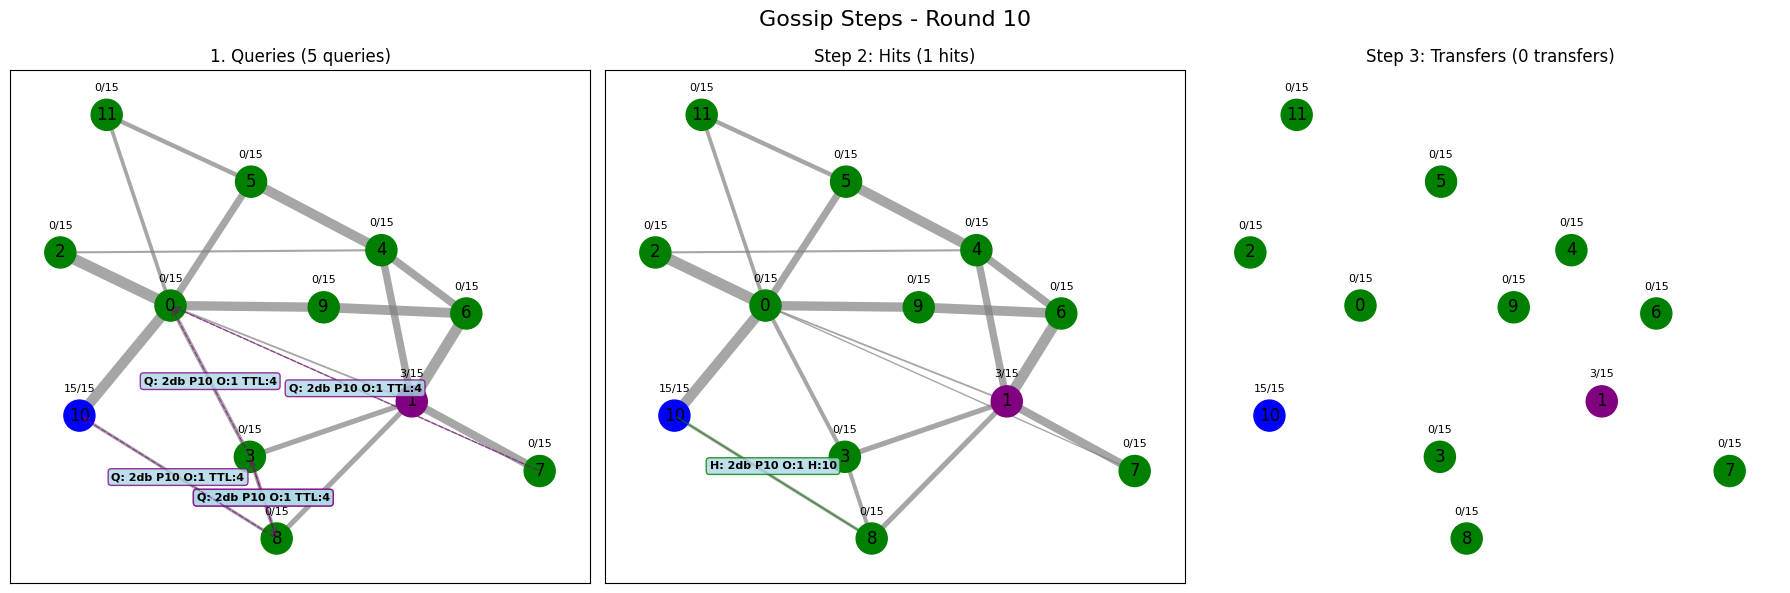


 Round 11
Messages: 5
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 10: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_011_gossip_steps.png


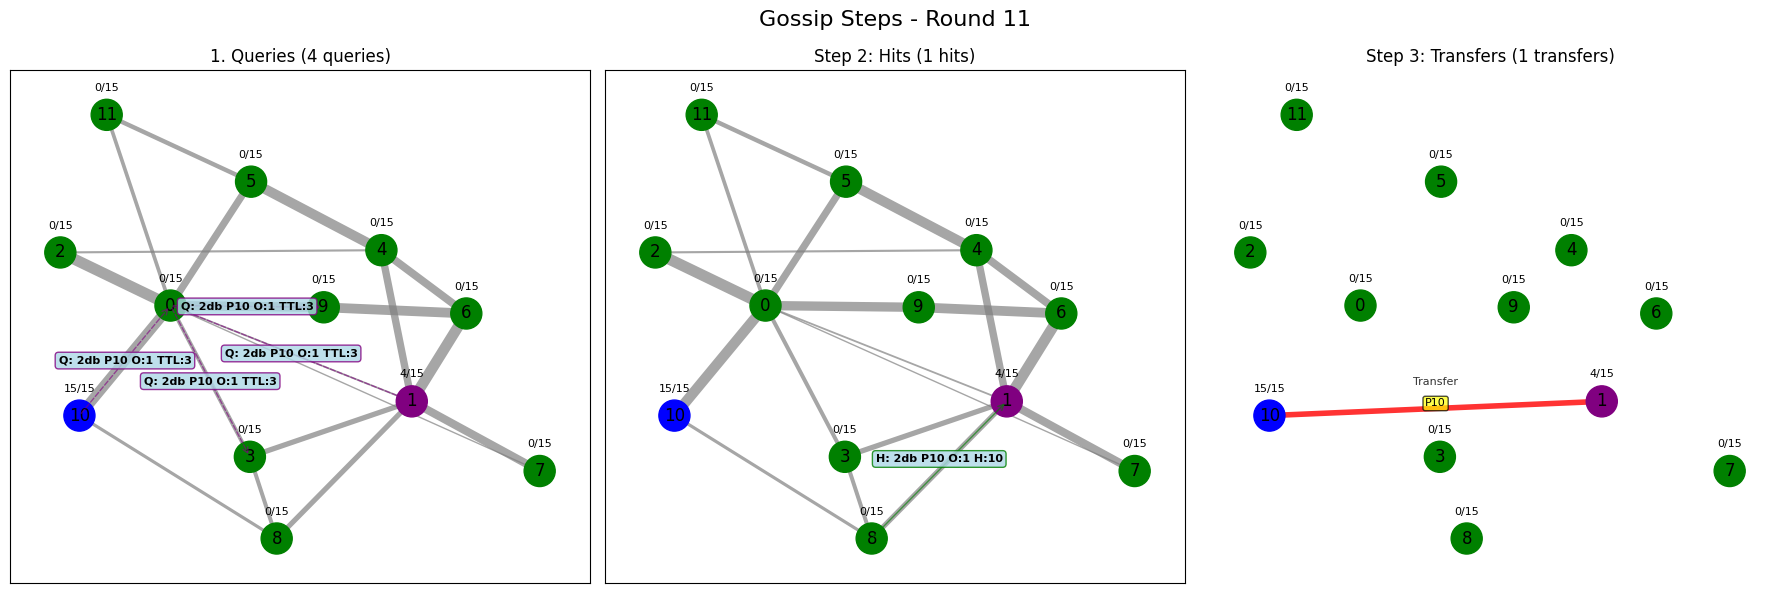


 Round 12
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_012_gossip_steps.png


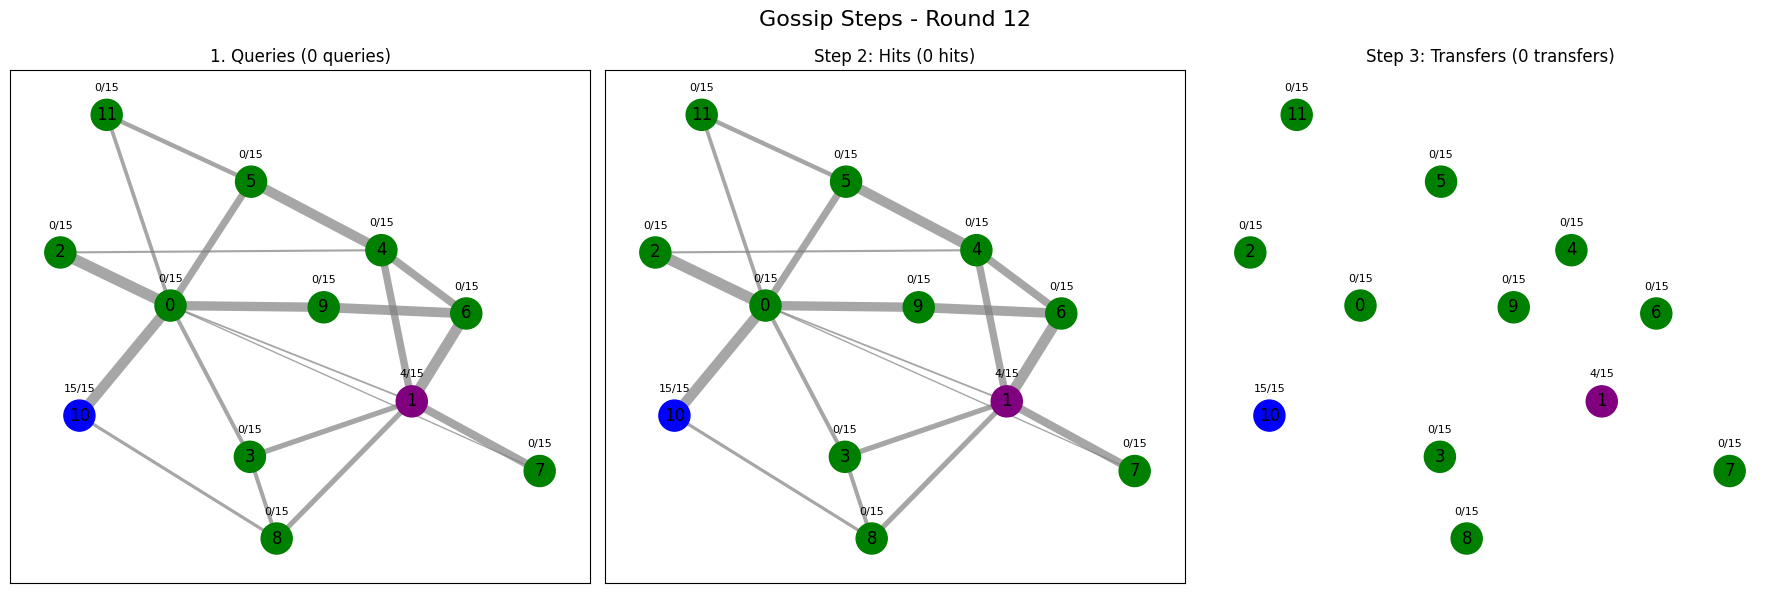


 Round 13
Messages: 3
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_013_gossip_steps.png


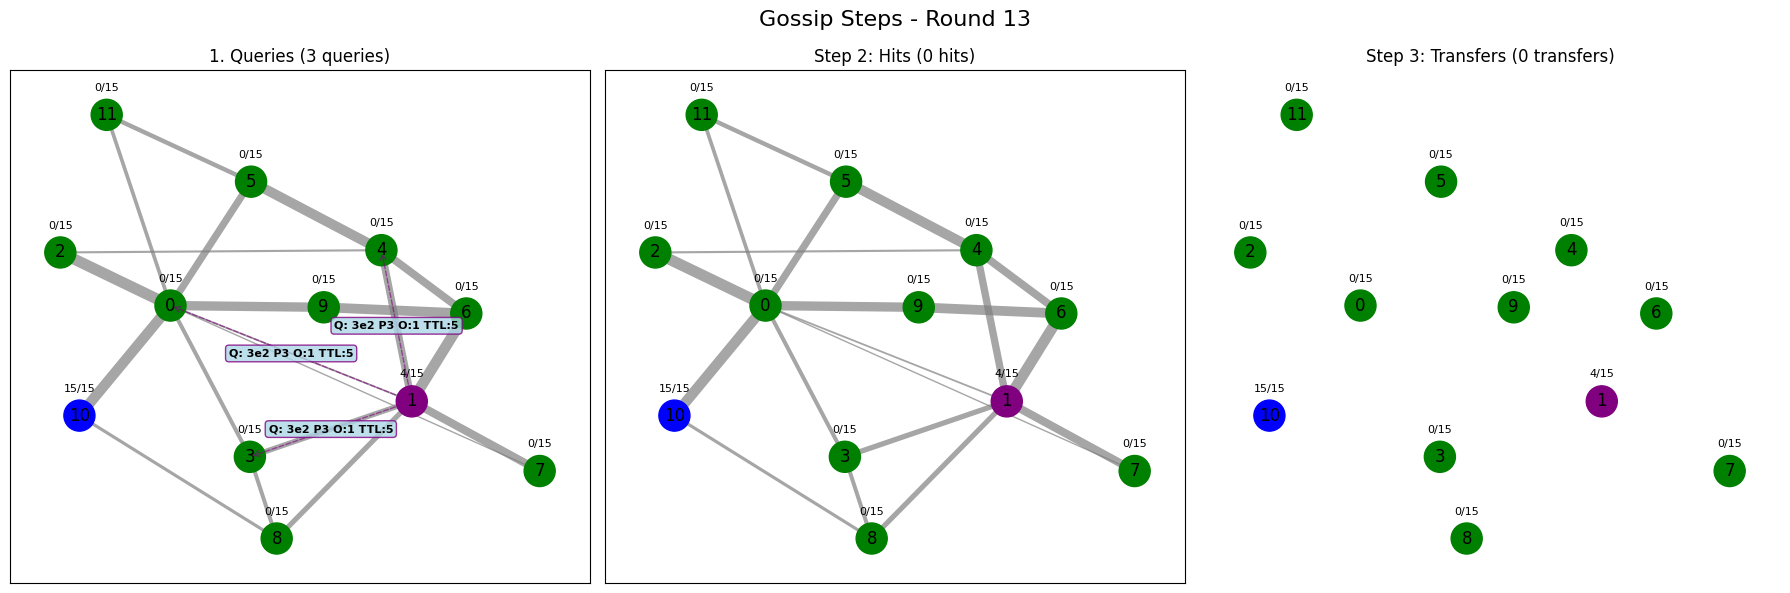


 Round 14
Messages: 9
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_014_gossip_steps.png


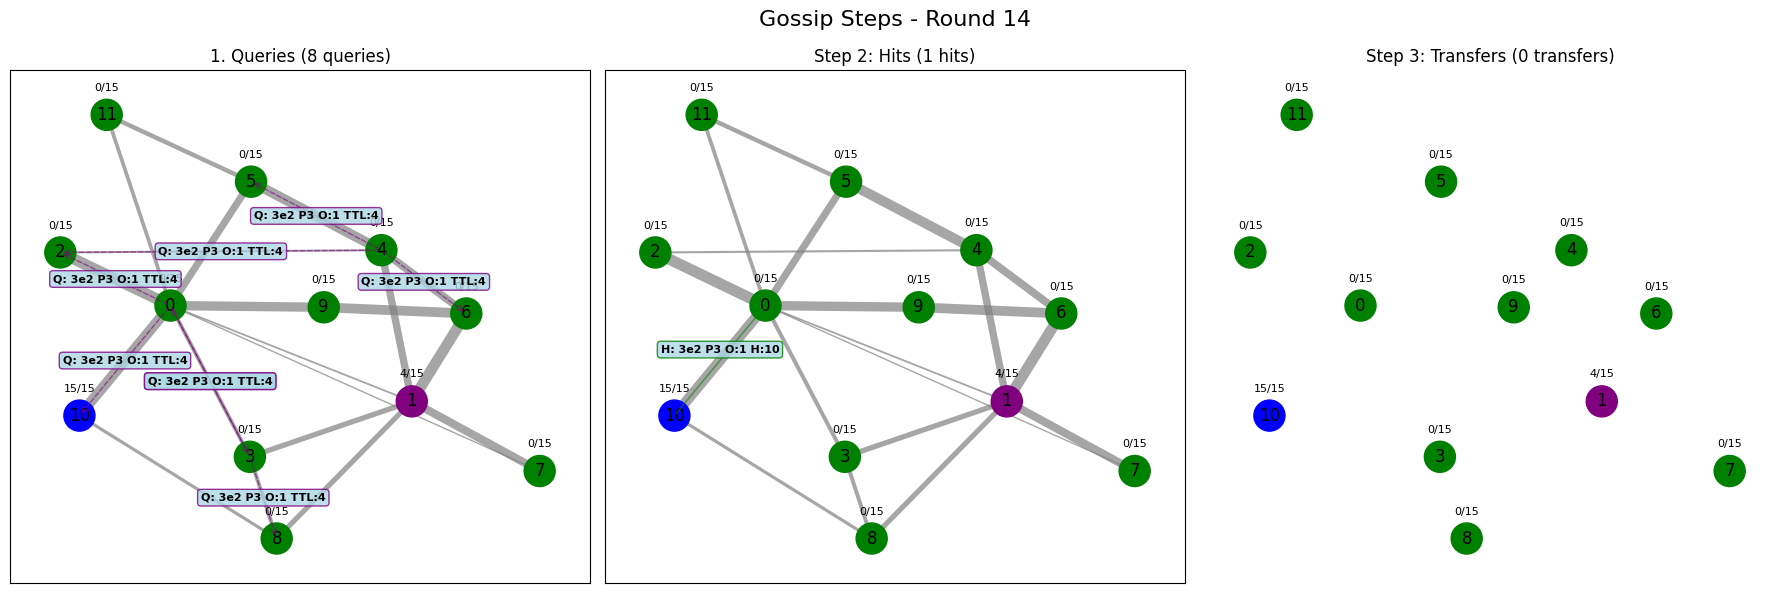


 Round 15
Messages: 12
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 3: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_015_gossip_steps.png


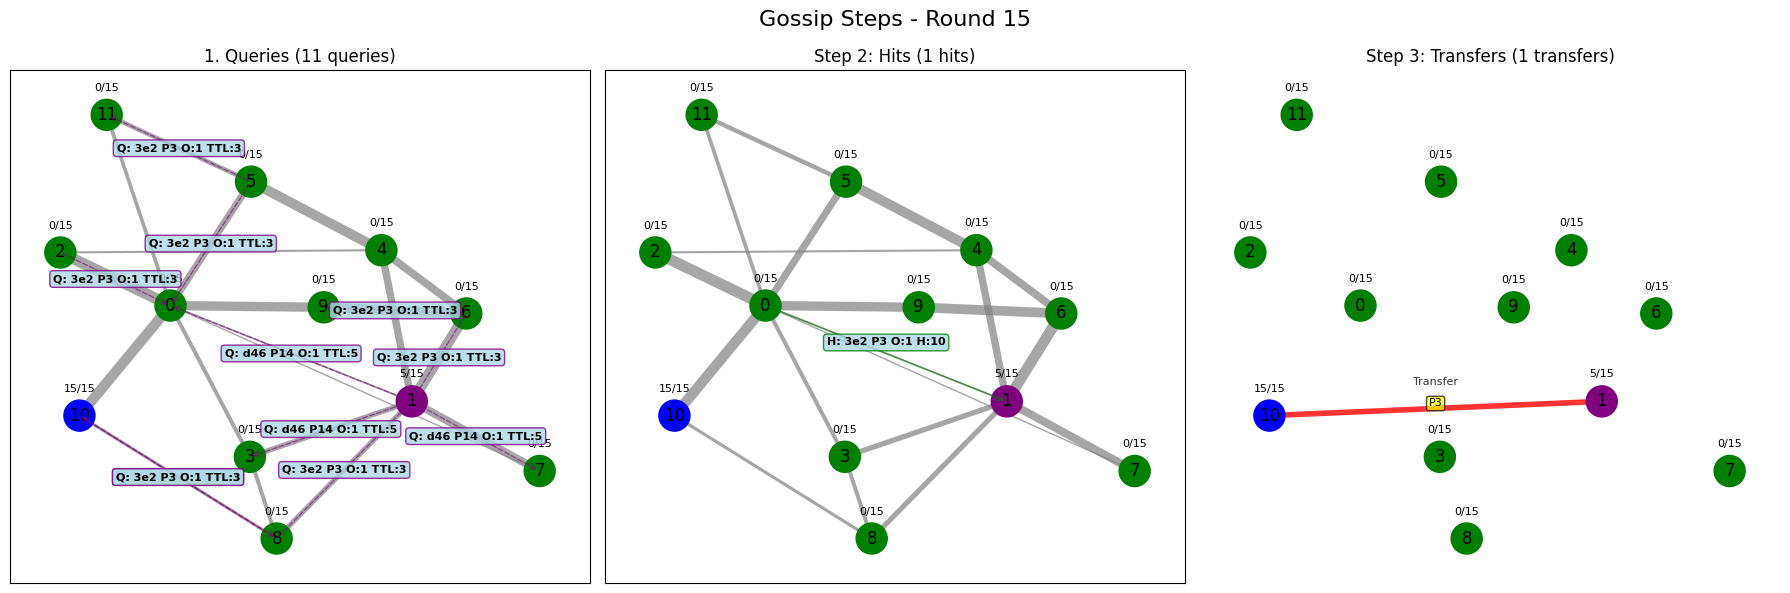


 Round 16
Messages: 6
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_016_gossip_steps.png


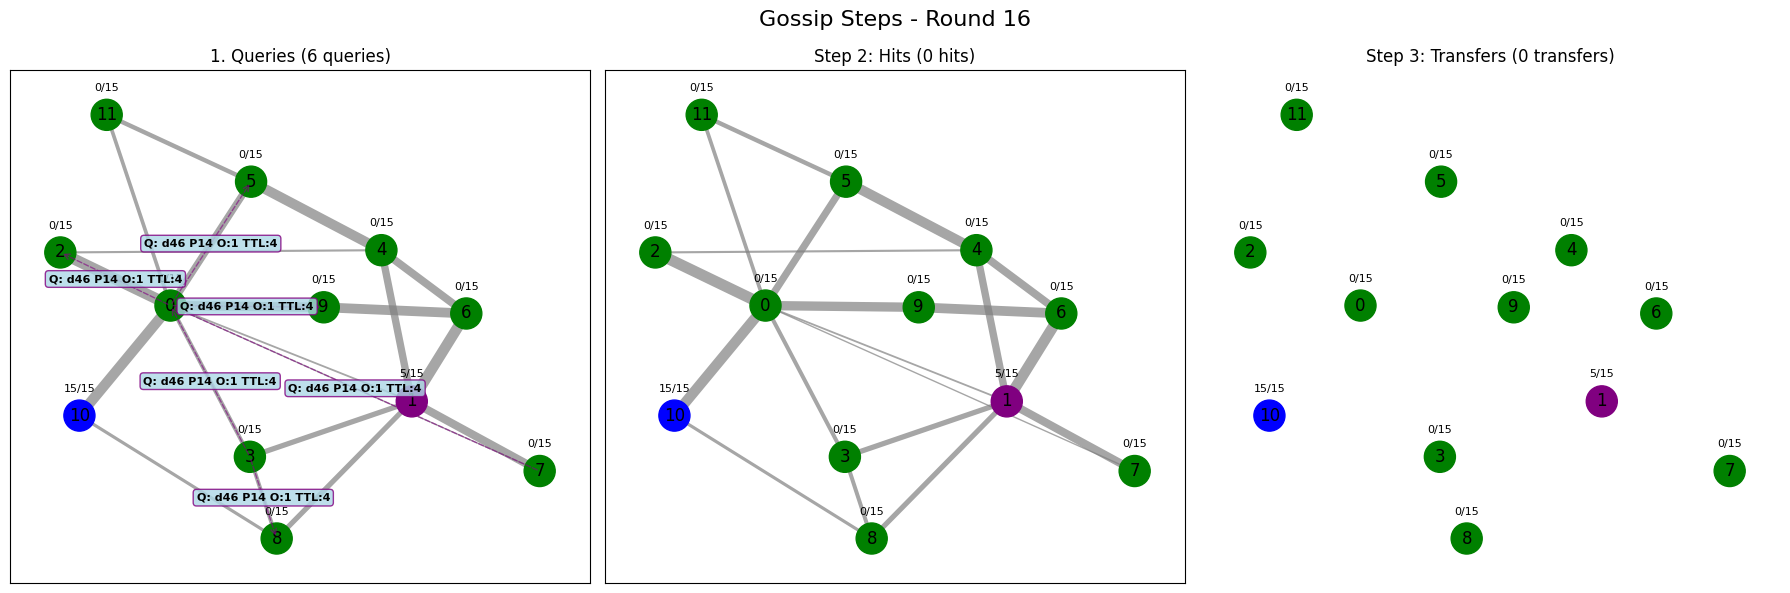


 Round 17
Messages: 10
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_017_gossip_steps.png


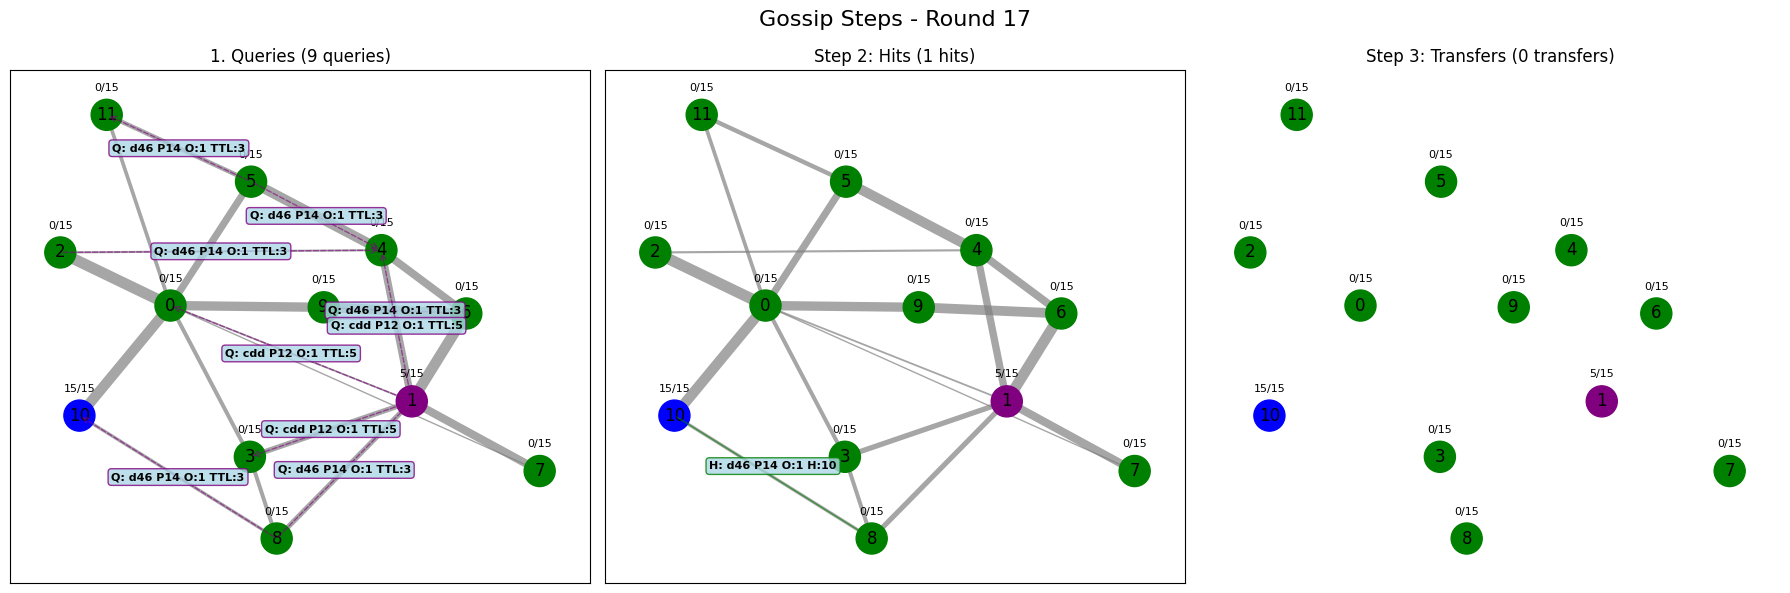


 Round 18
Messages: 16
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_018_gossip_steps.png


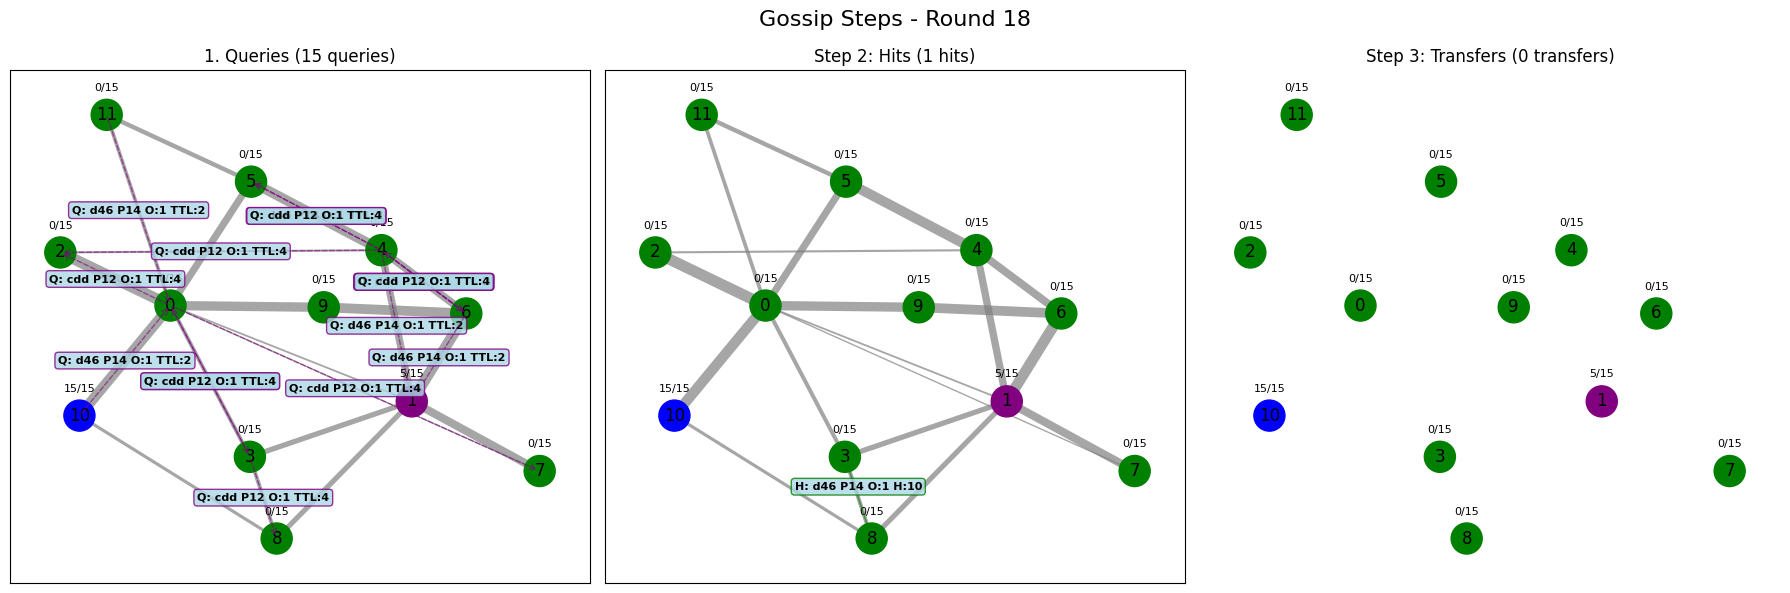


 Round 19
Messages: 10
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 14: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_019_gossip_steps.png


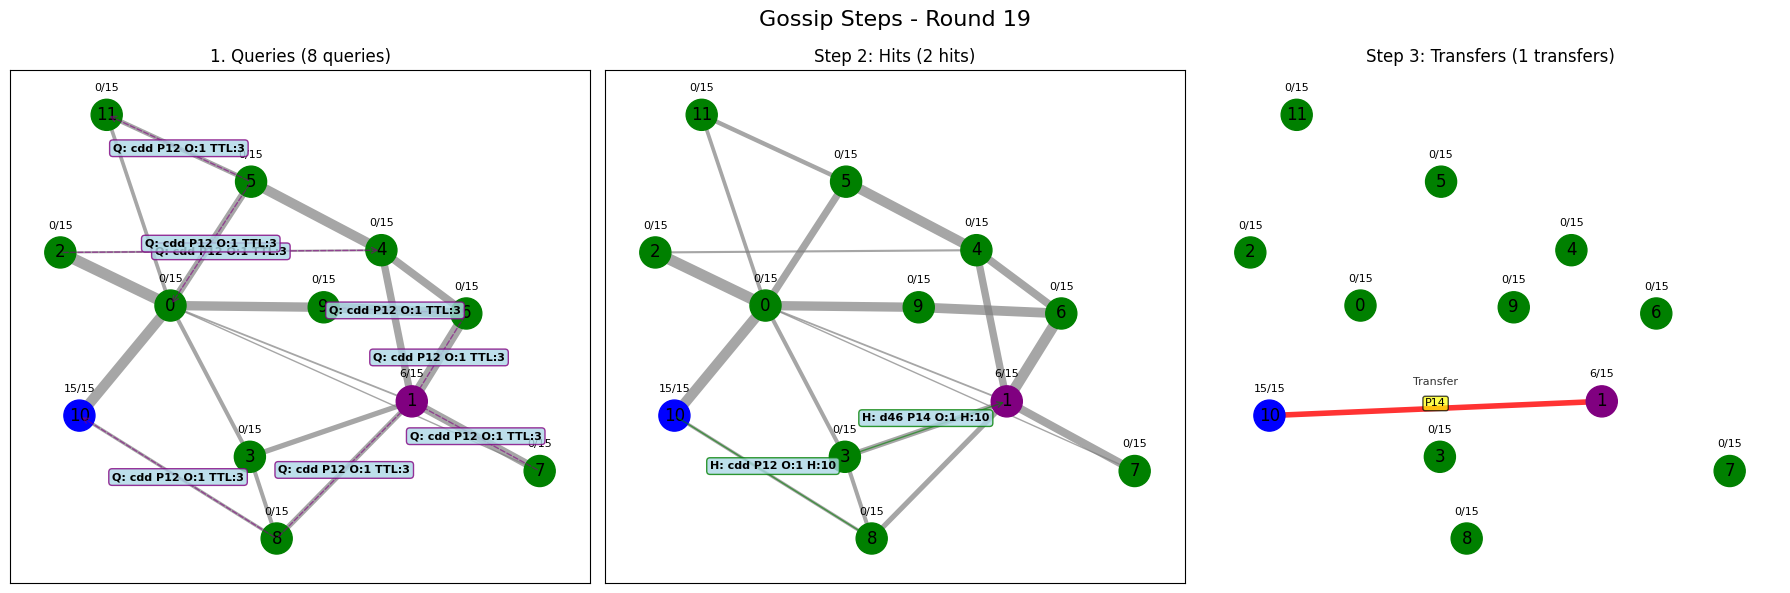


 Round 20
Messages: 4
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_020_gossip_steps.png


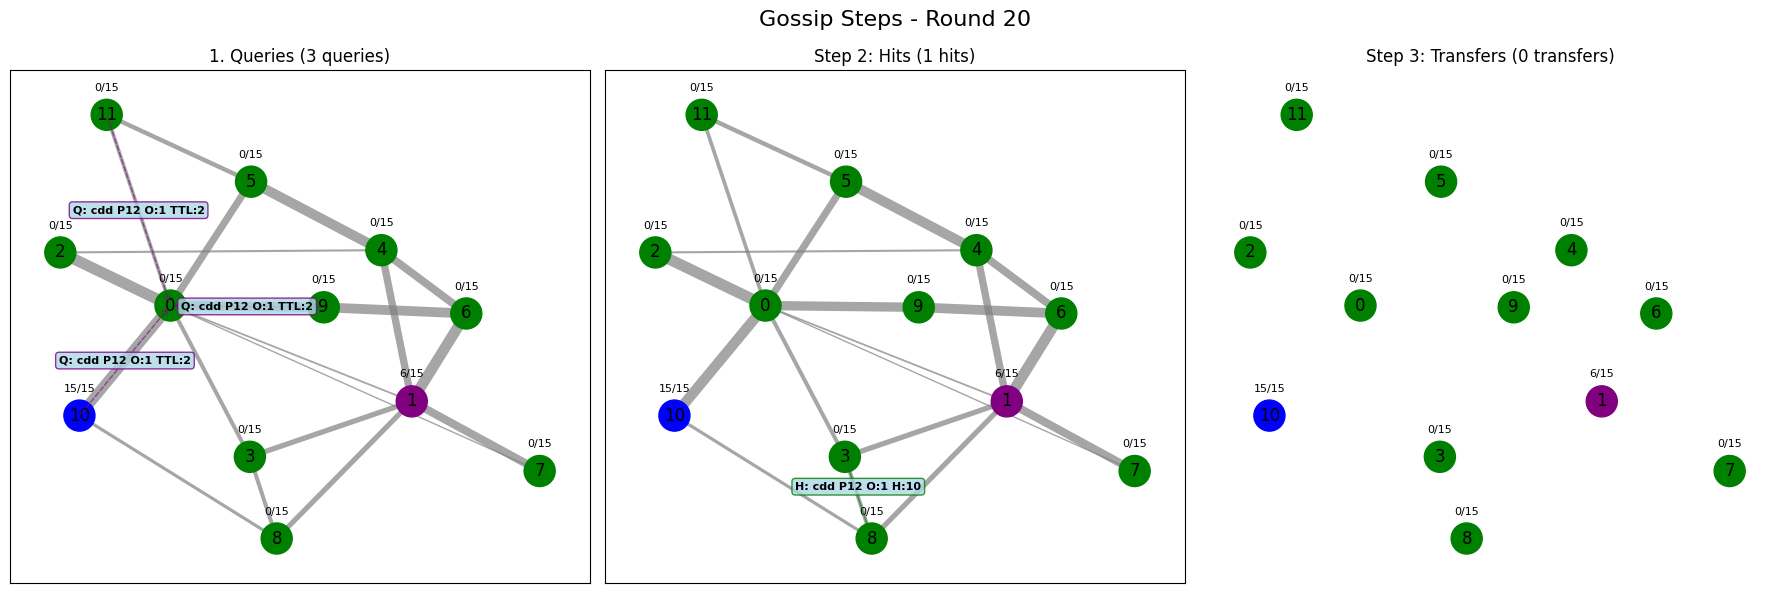


 Round 21
Messages: 1
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 12: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_021_gossip_steps.png


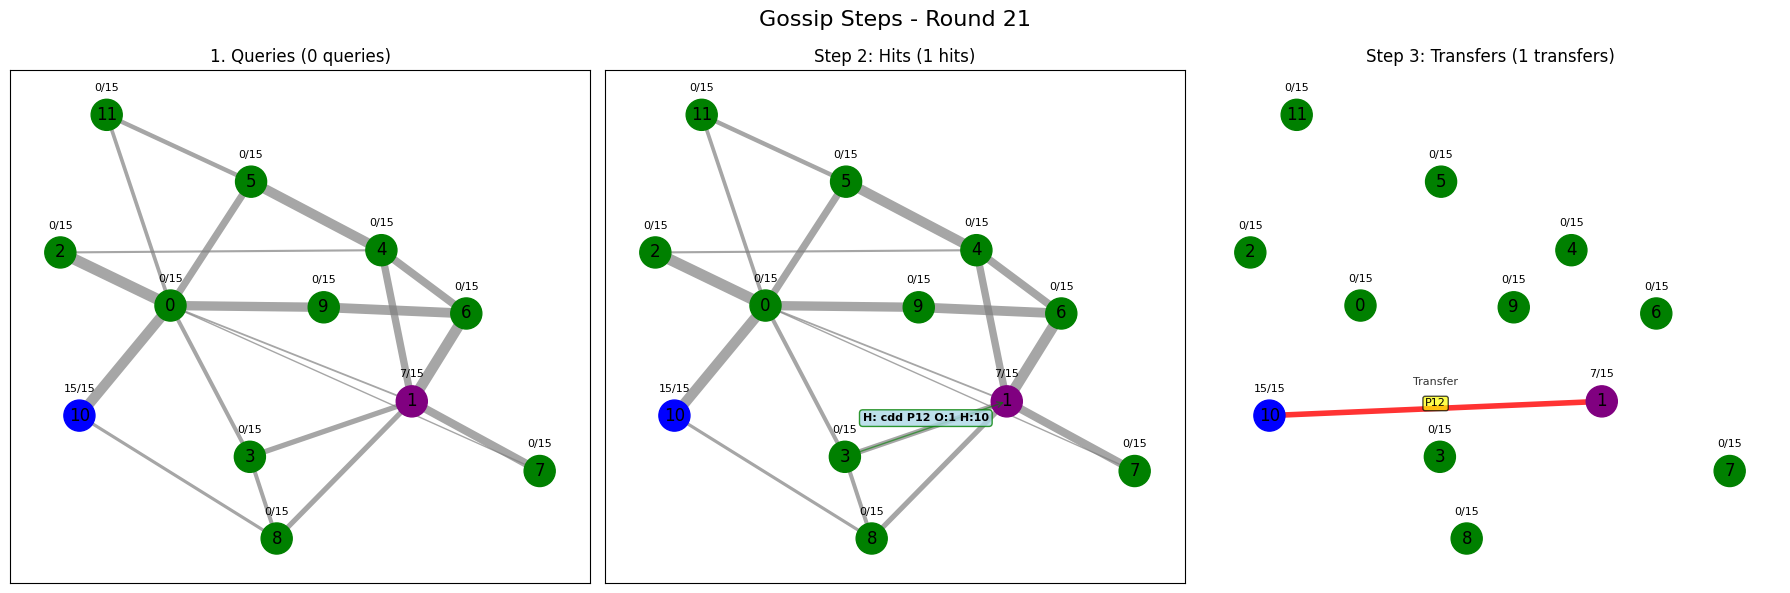


 Round 22
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_022_gossip_steps.png


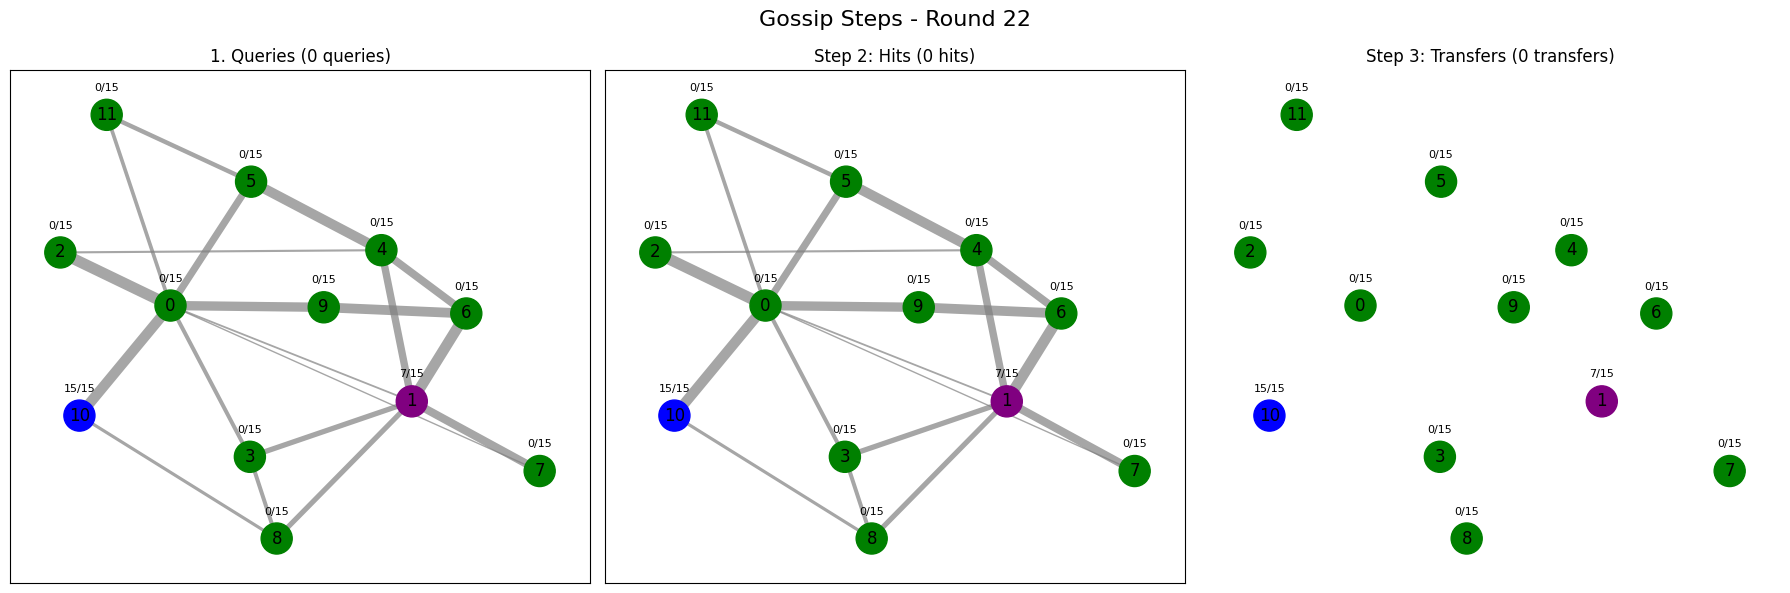


 Round 23
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_023_gossip_steps.png


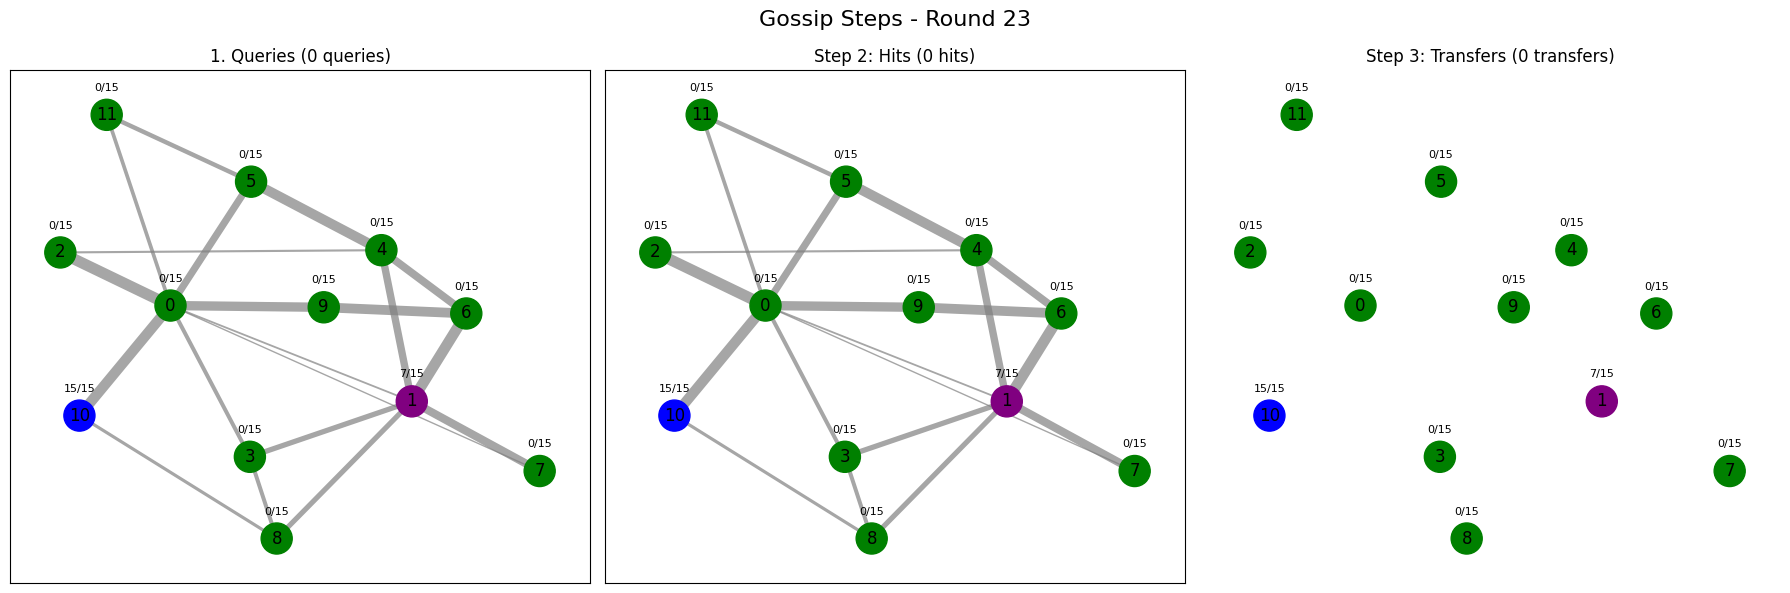


 Round 24
Messages: 3
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_024_gossip_steps.png


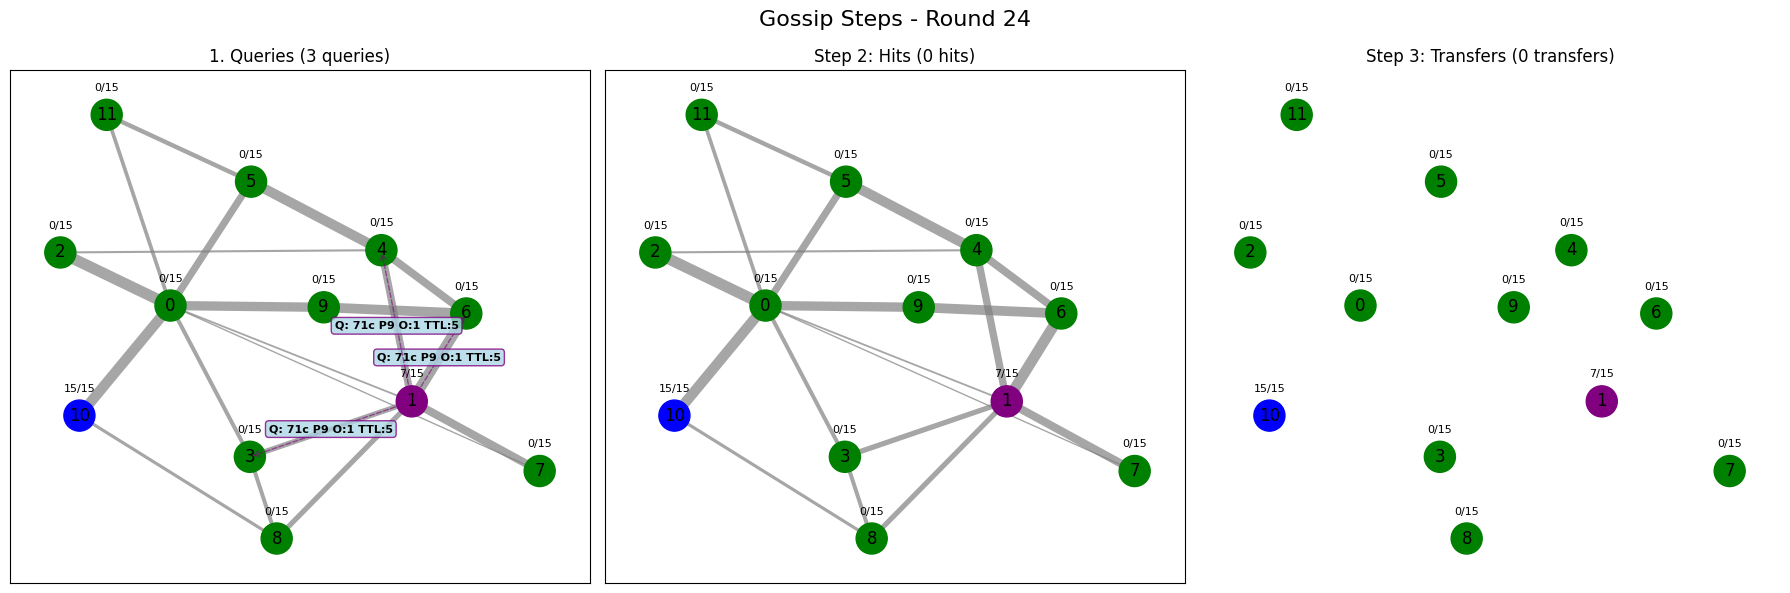


 Round 25
Messages: 10
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_025_gossip_steps.png


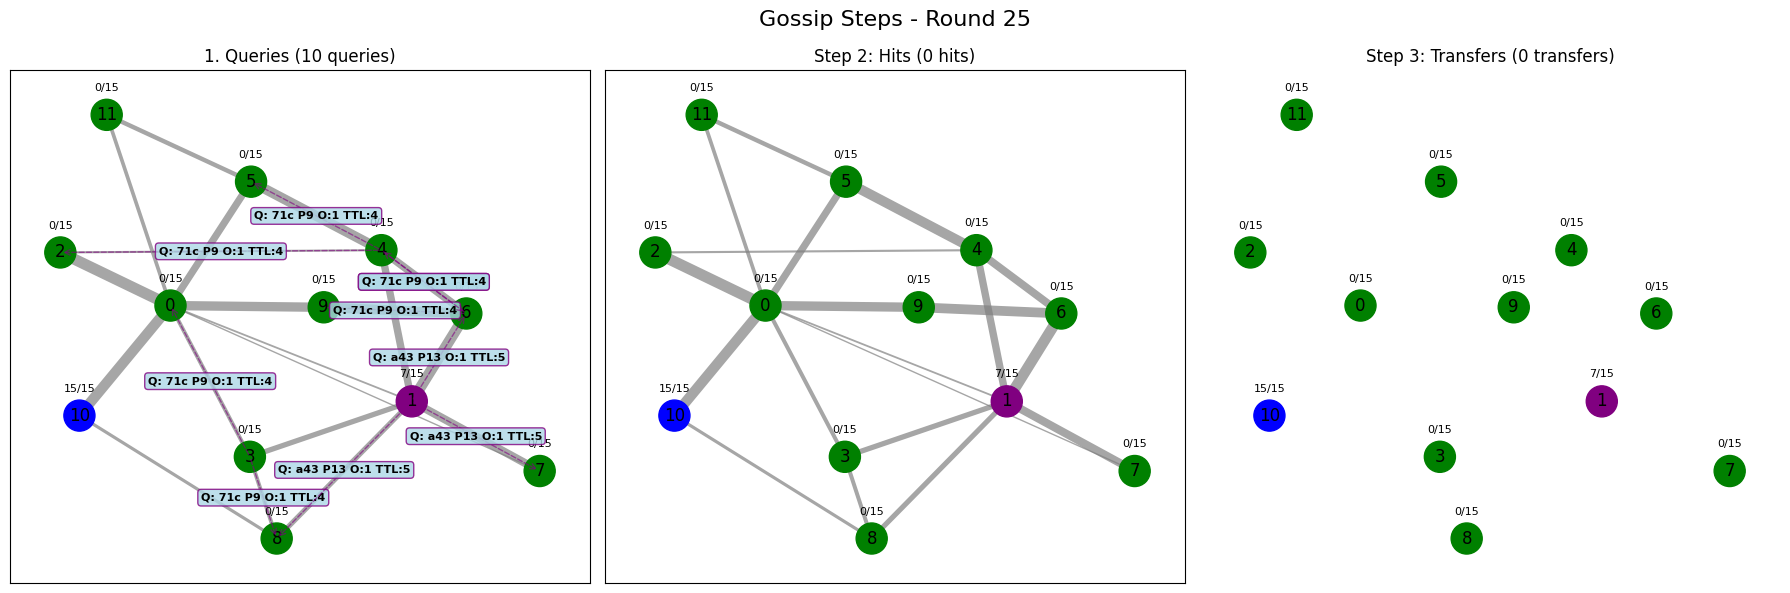


 Round 26
Messages: 16
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_026_gossip_steps.png


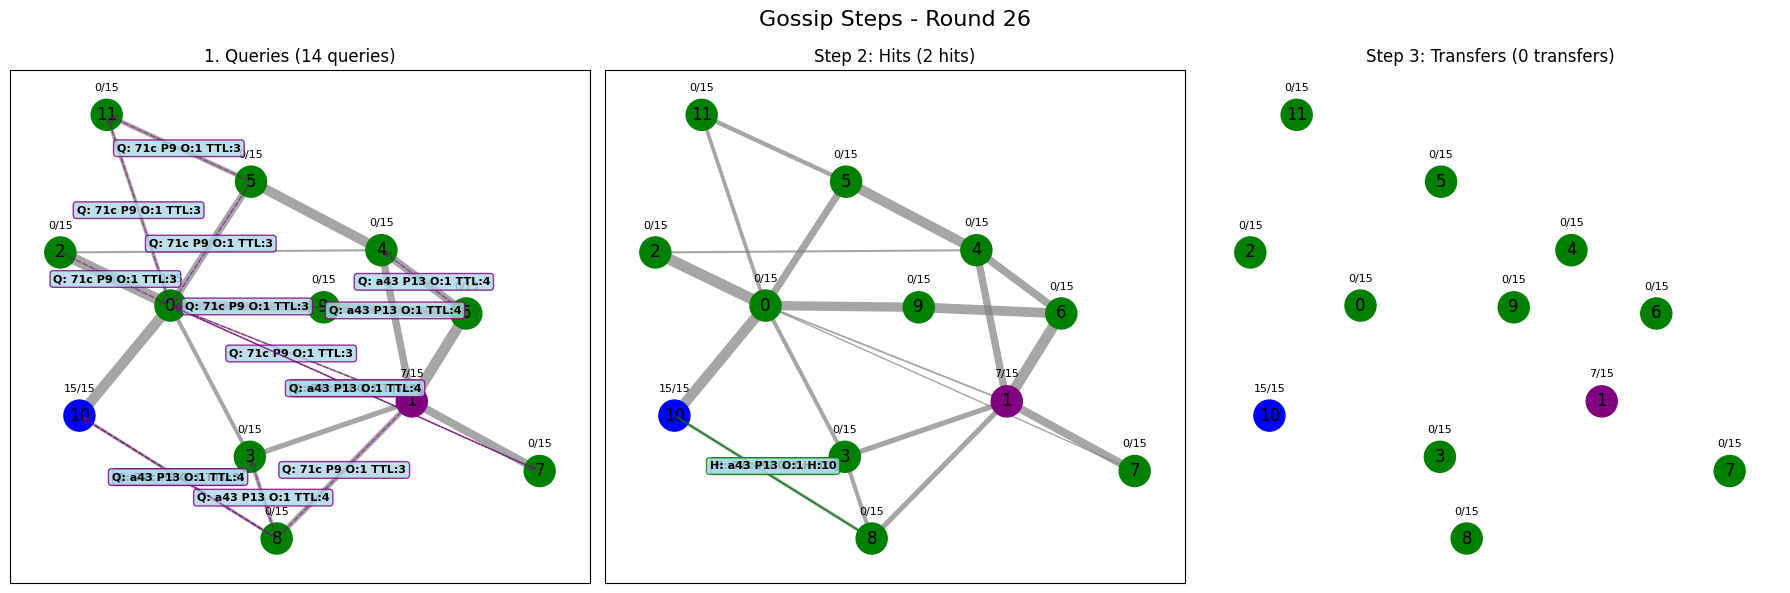


 Round 27
Messages: 15
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 13: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_027_gossip_steps.png


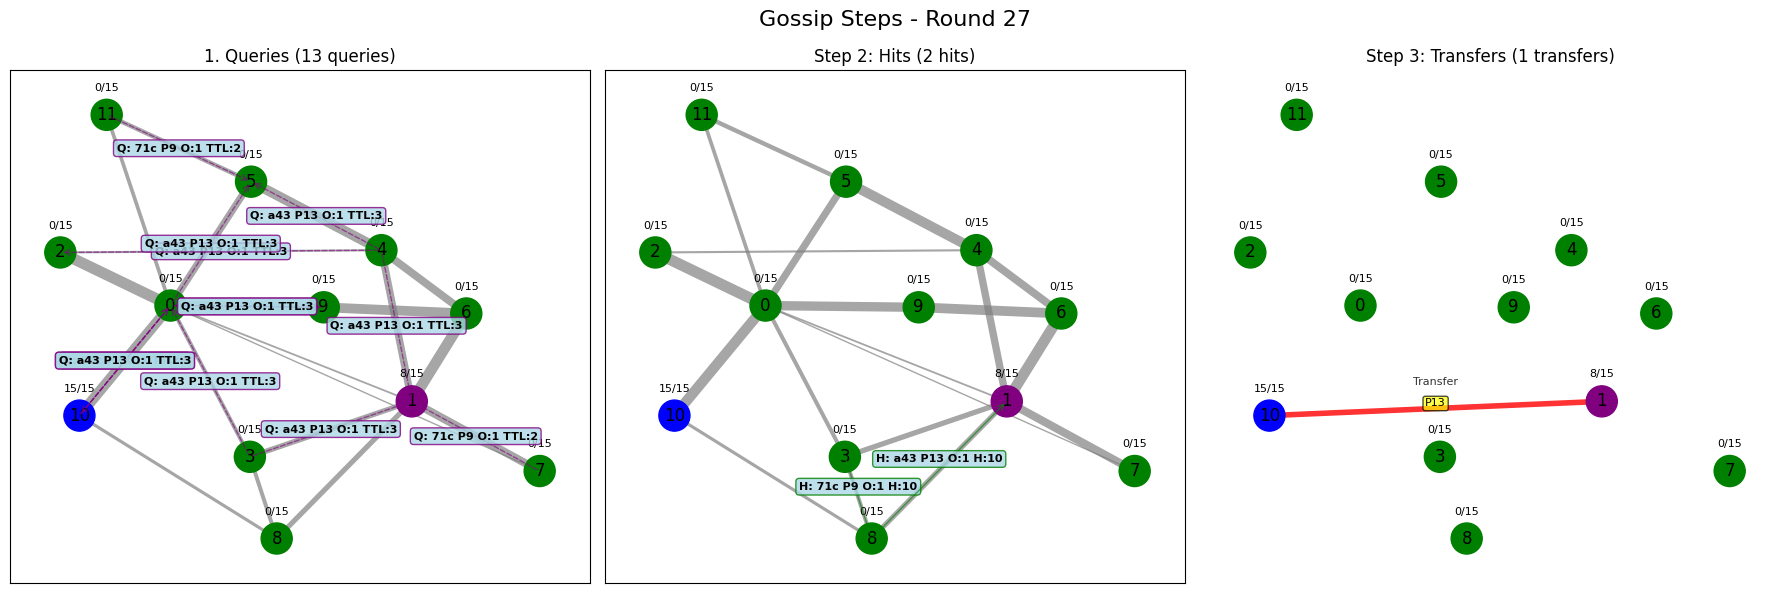


 Round 28
Messages: 1
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 9: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_028_gossip_steps.png


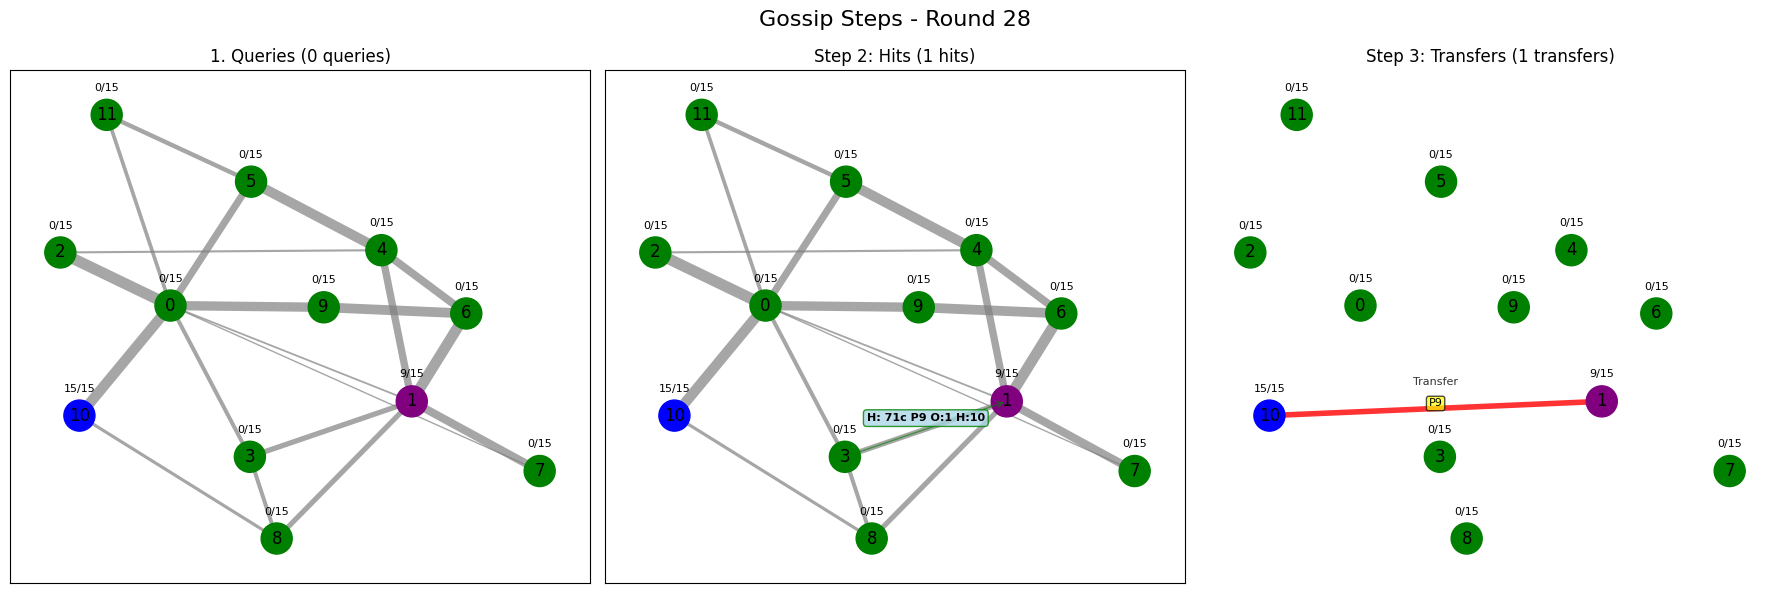


 Round 29
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_029_gossip_steps.png


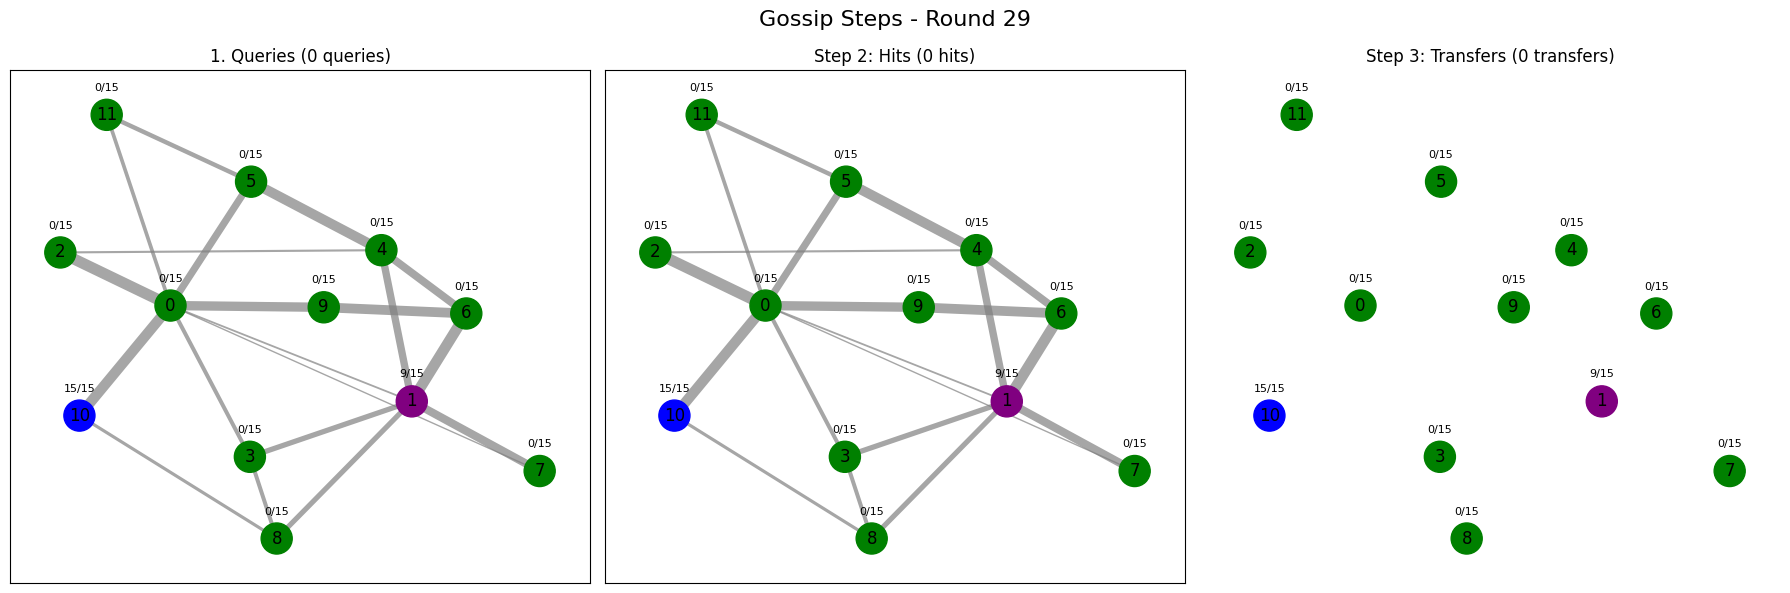


 Round 30
Messages: 3
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_030_gossip_steps.png


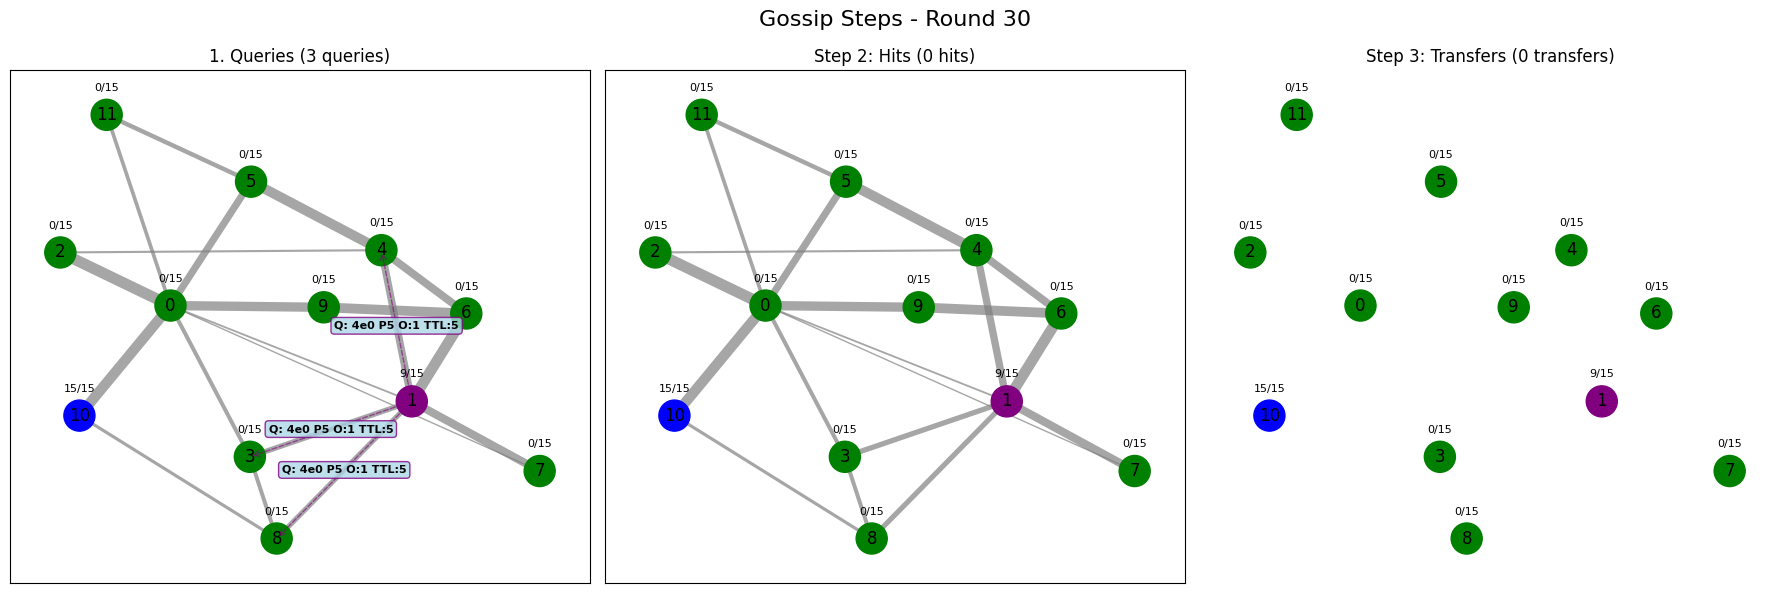


 Round 31
Messages: 11
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_031_gossip_steps.png


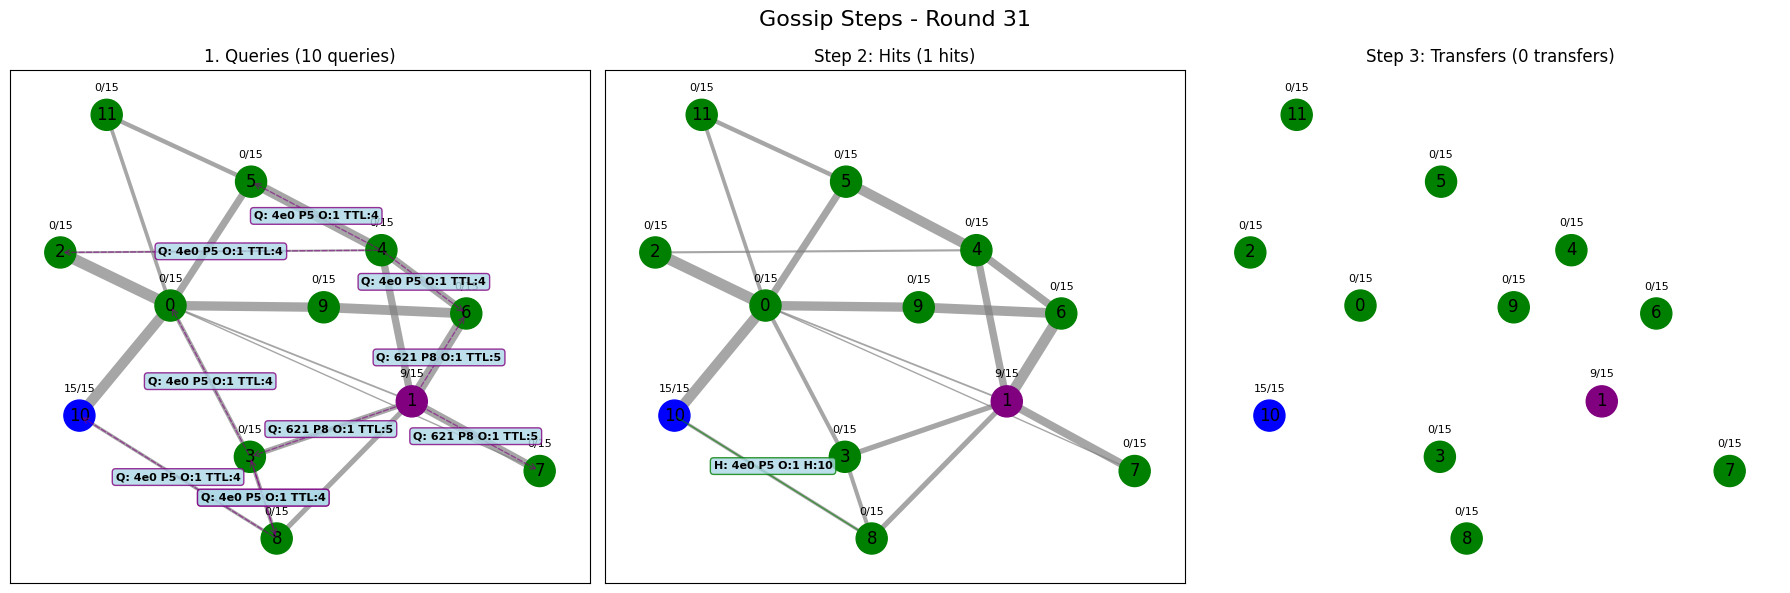


 Round 32
Messages: 15
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 5: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_032_gossip_steps.png


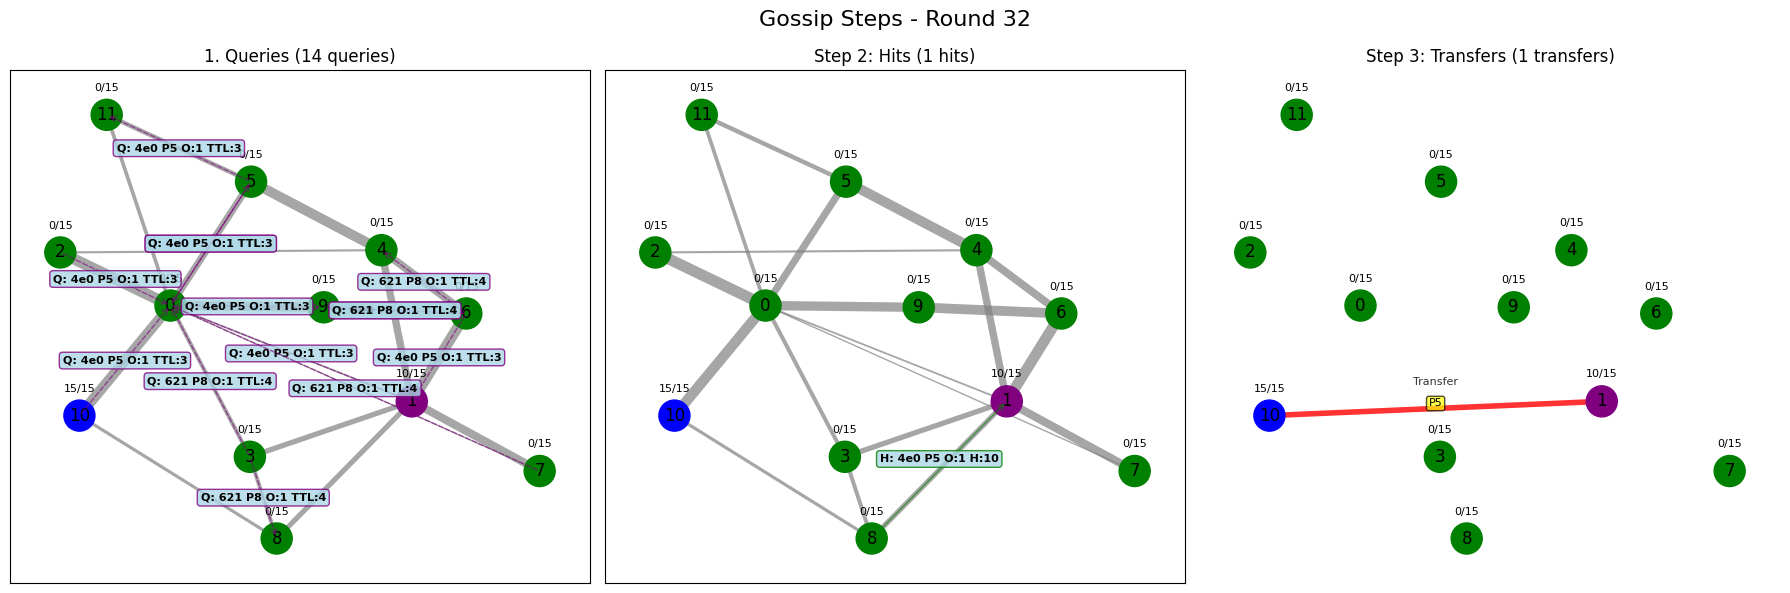


 Round 33
Messages: 10
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_033_gossip_steps.png


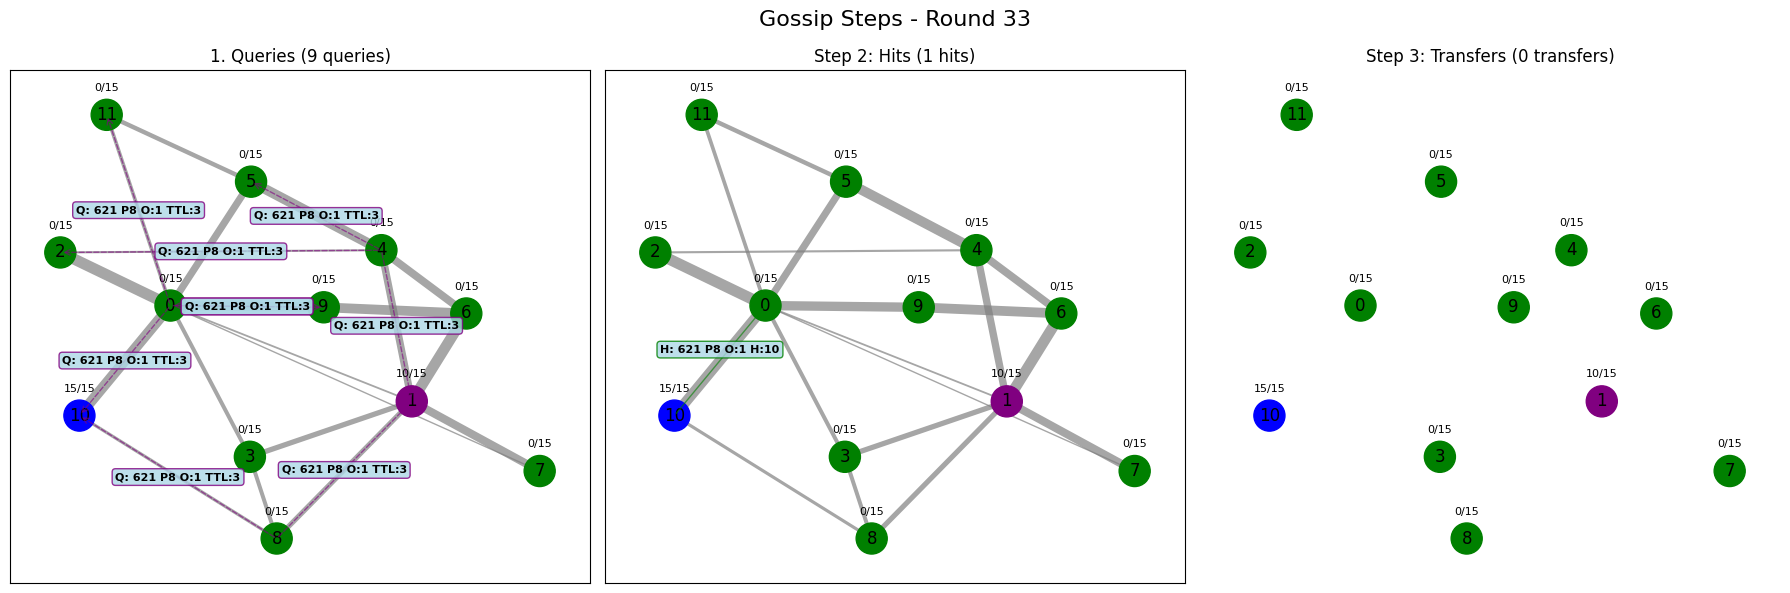


 Round 34
Messages: 6
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_034_gossip_steps.png


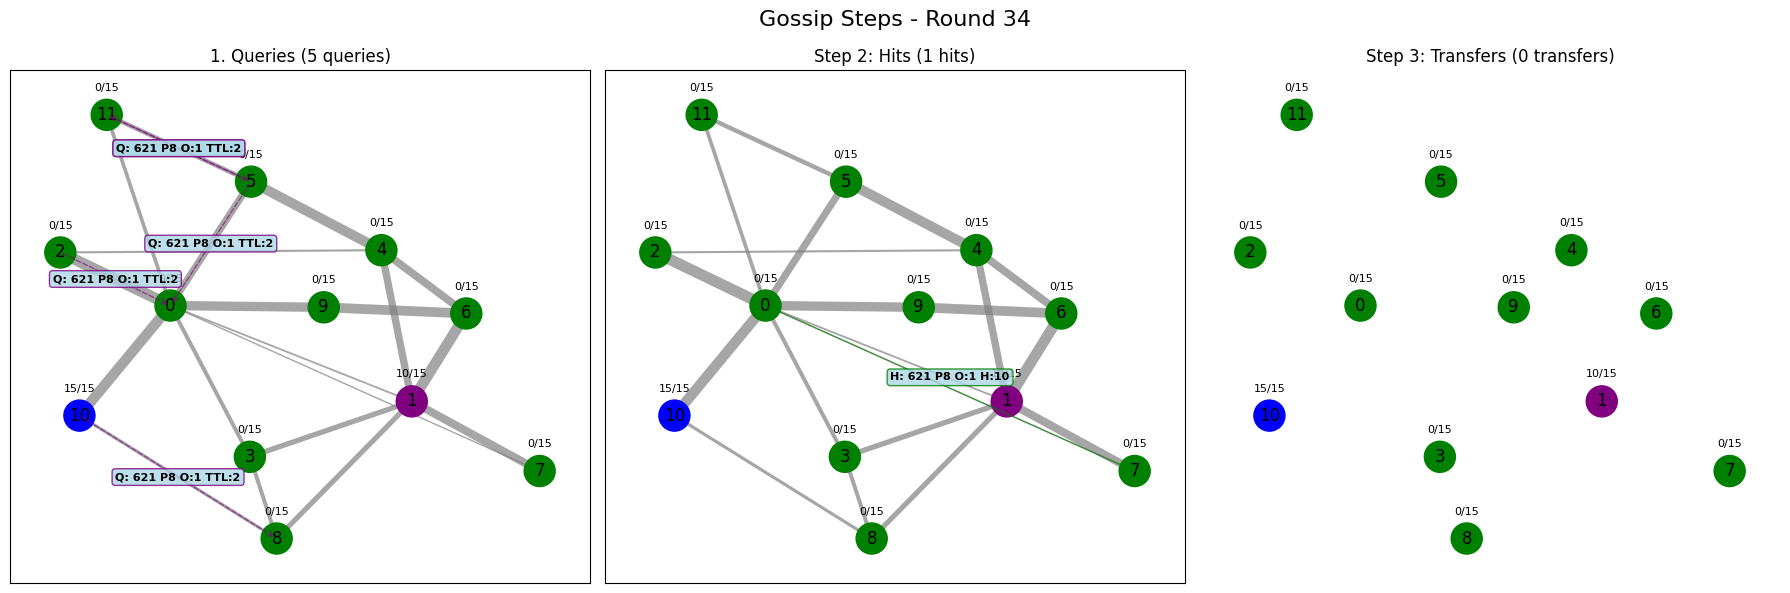


 Round 35
Messages: 1
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 8: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_035_gossip_steps.png


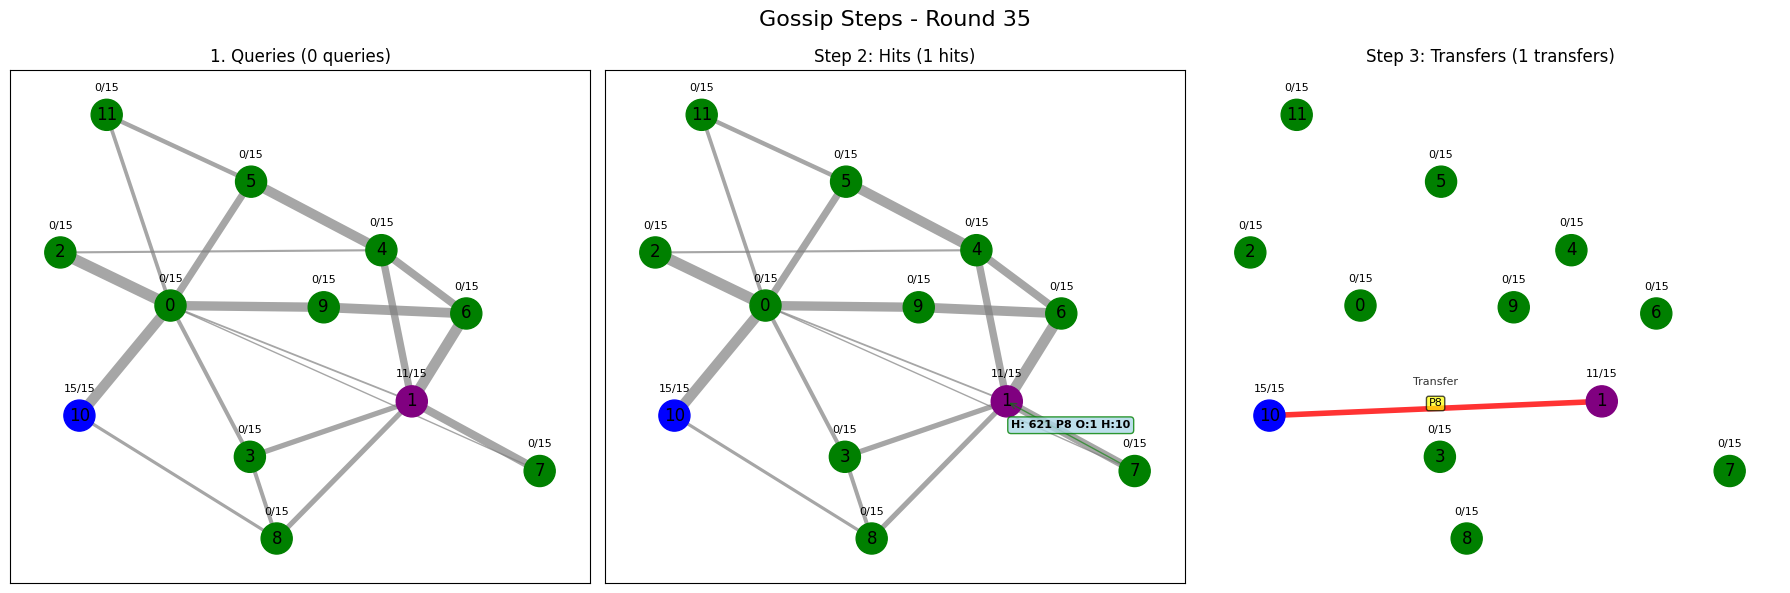


 Round 36
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_036_gossip_steps.png


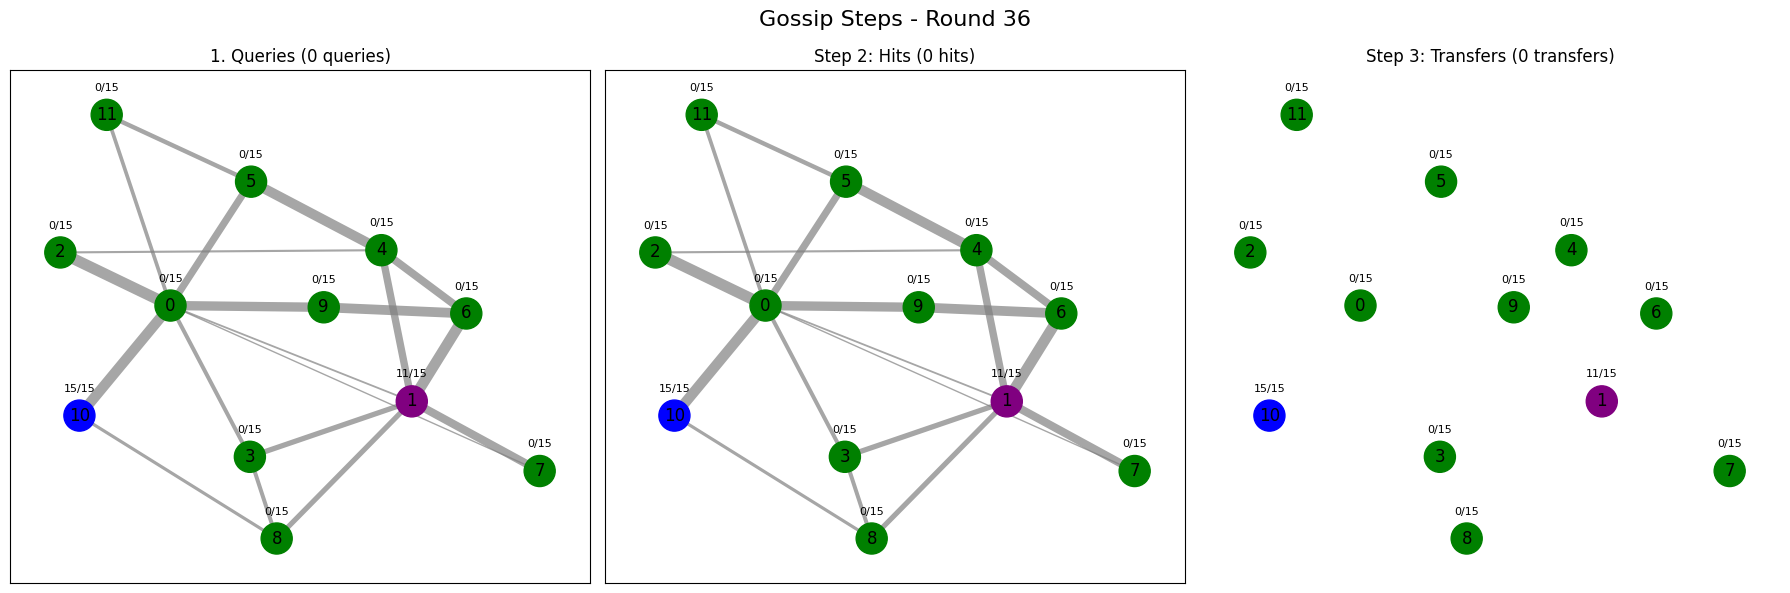


 Round 37
Messages: 3
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_037_gossip_steps.png


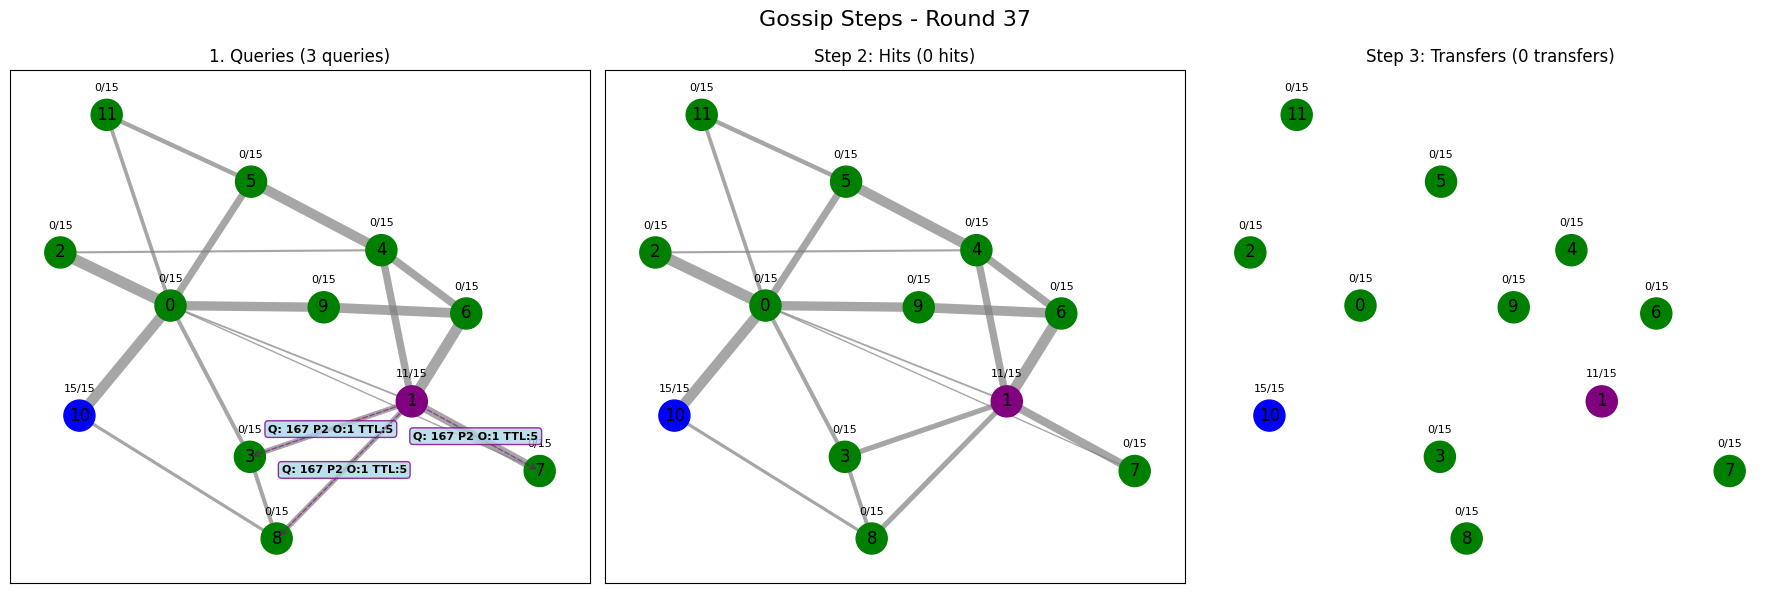


 Round 38
Messages: 9
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_038_gossip_steps.png


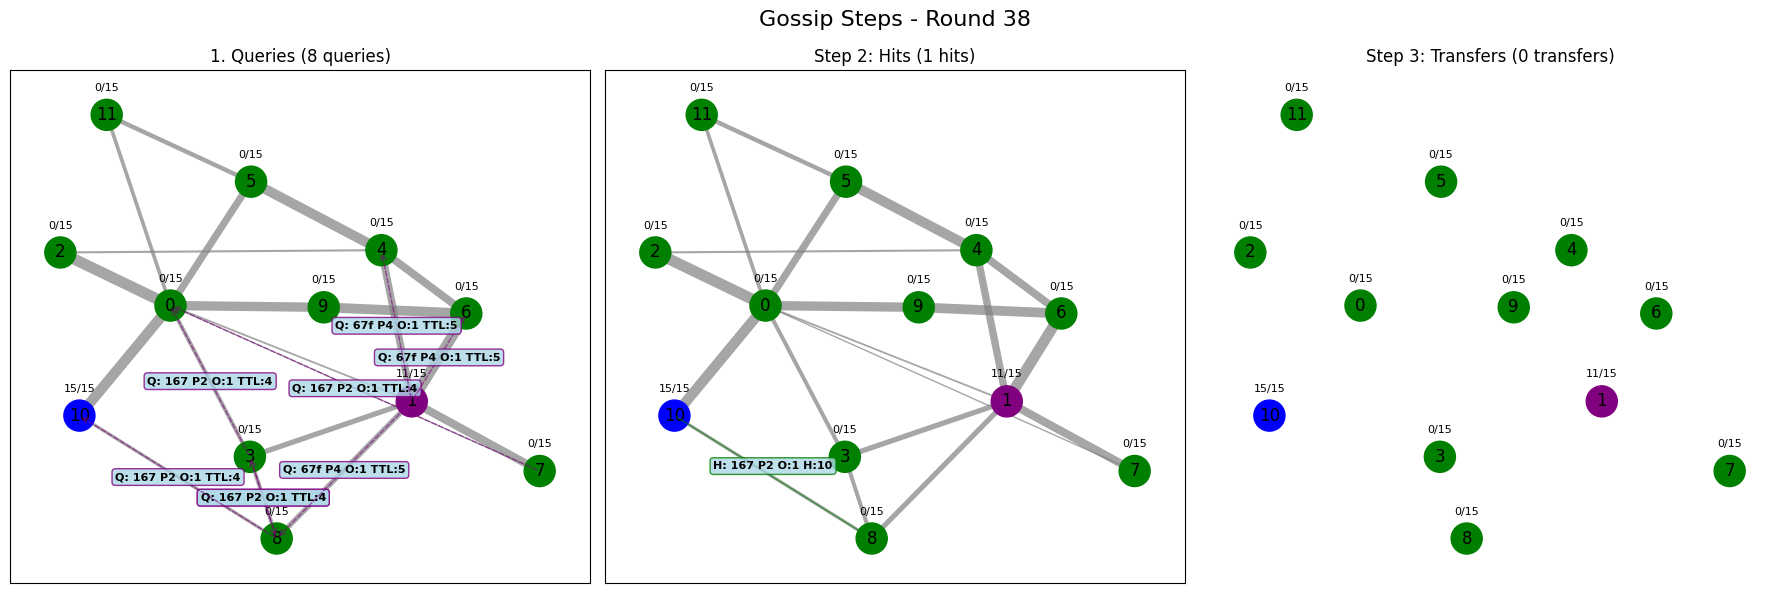


 Round 39
Messages: 13
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 2: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_039_gossip_steps.png


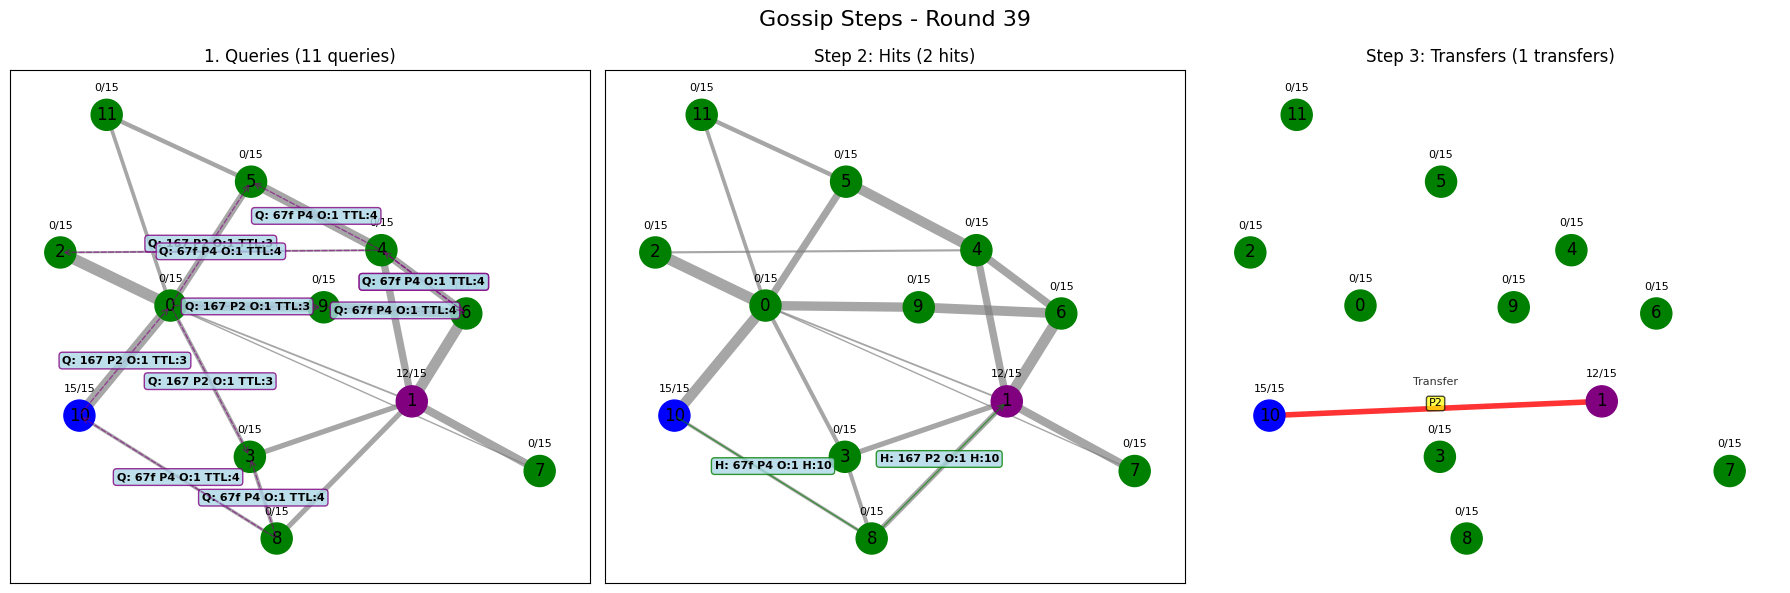


 Round 40
Messages: 11
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 4: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_040_gossip_steps.png


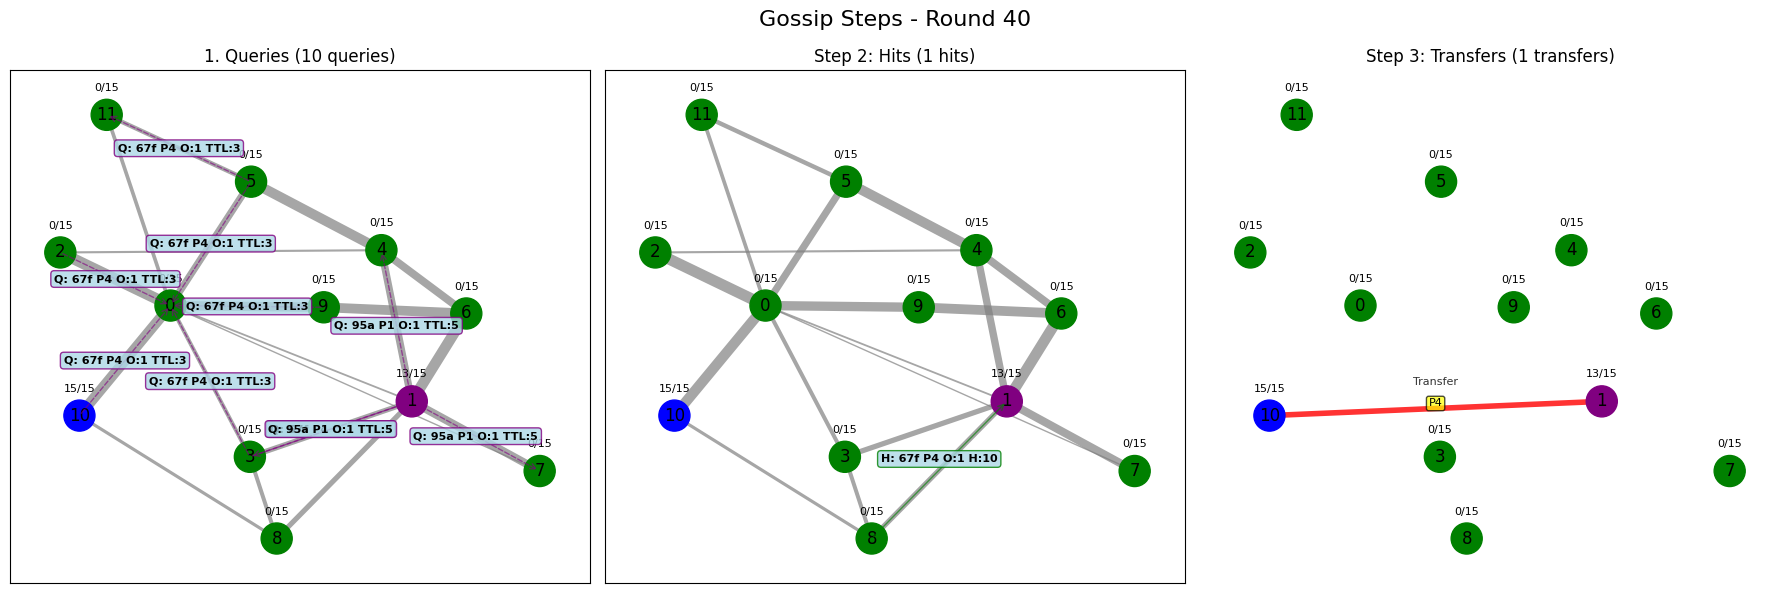


 Round 41
Messages: 6
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_041_gossip_steps.png


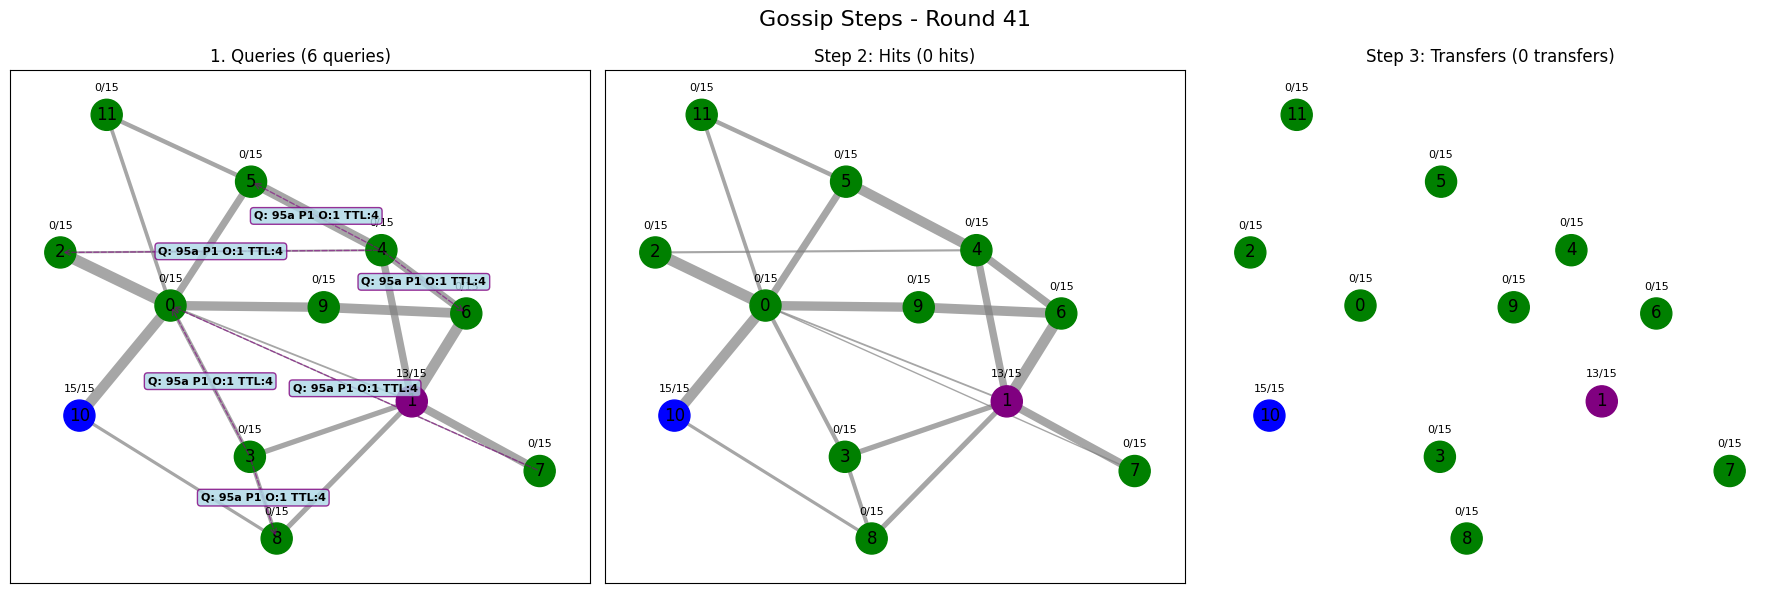


 Round 42
Messages: 11
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_042_gossip_steps.png


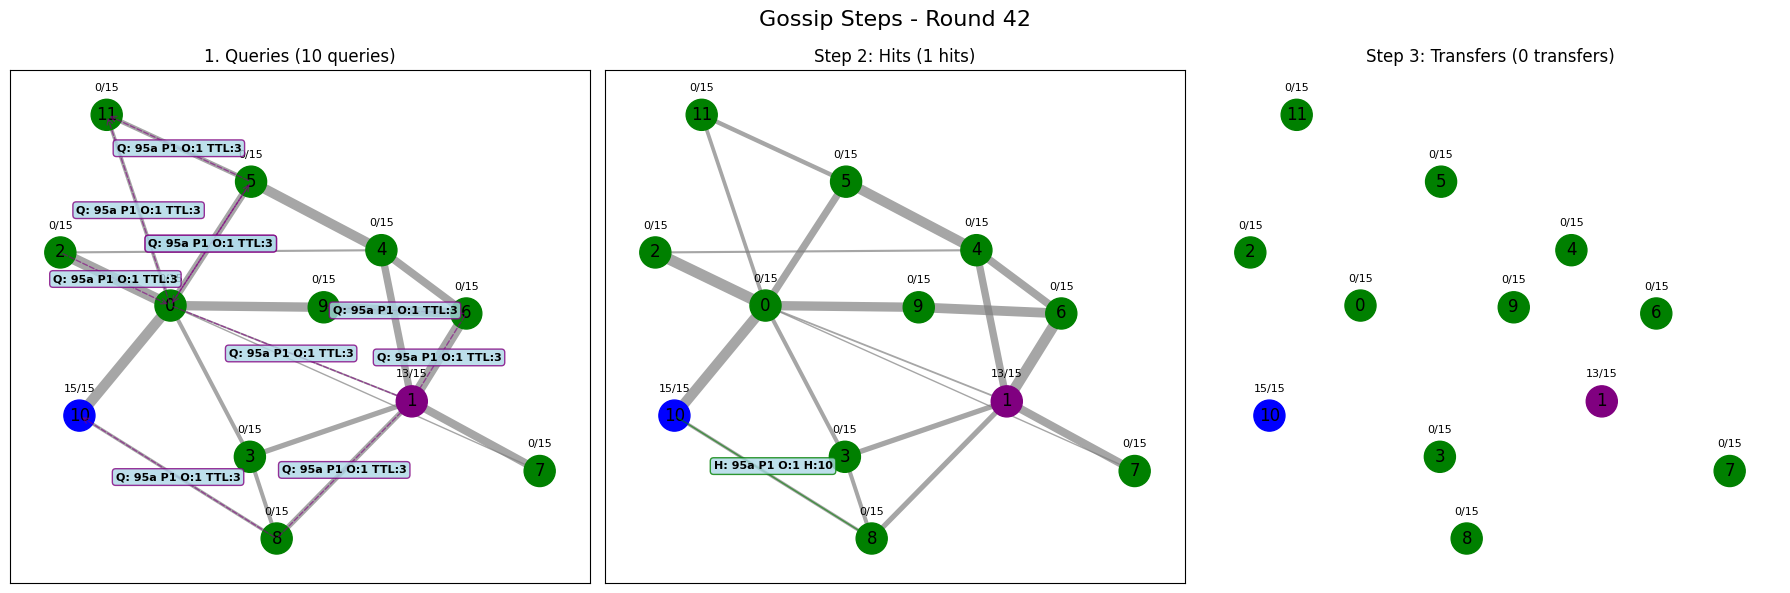


 Round 43
Messages: 7
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_043_gossip_steps.png


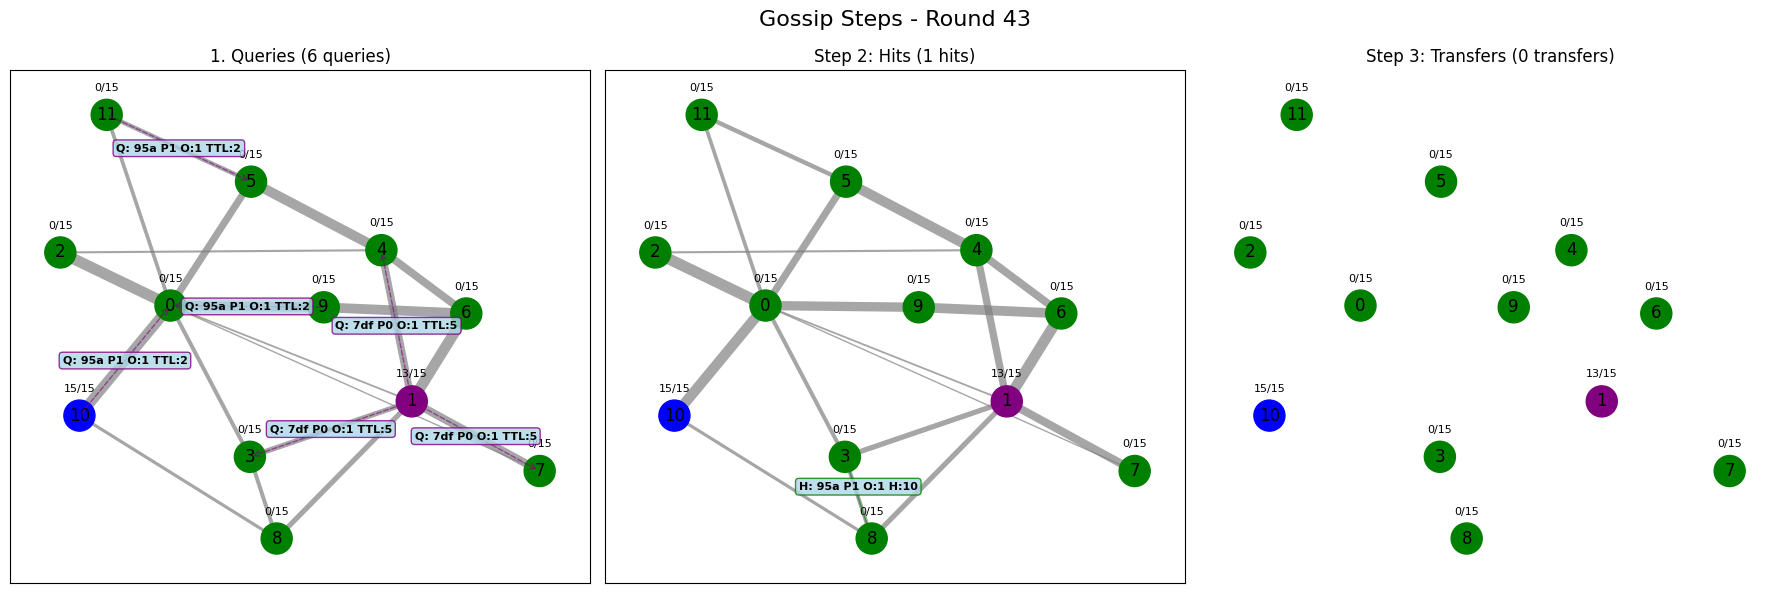


 Round 44
Messages: 7
Transfers: 1
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 1: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_044_gossip_steps.png


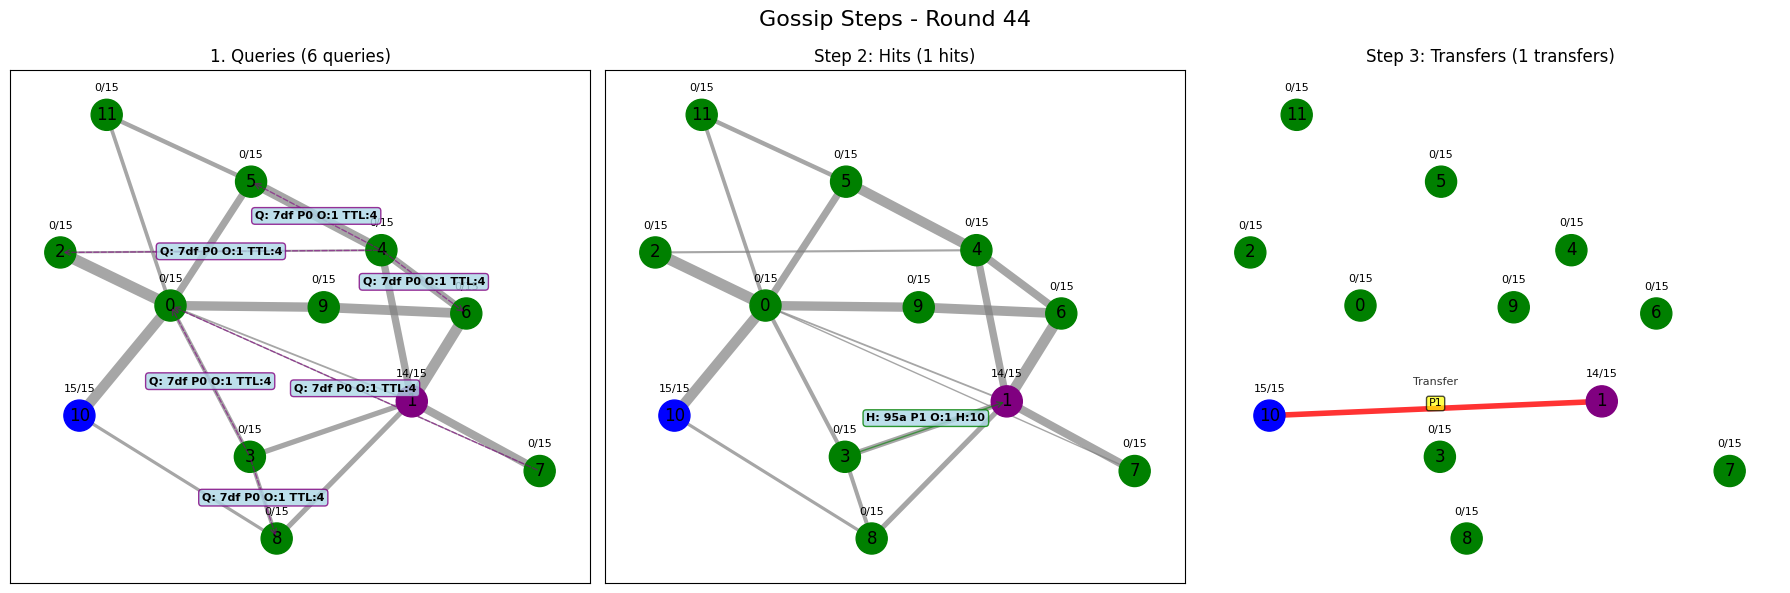


 Round 45
Messages: 11
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_045_gossip_steps.png


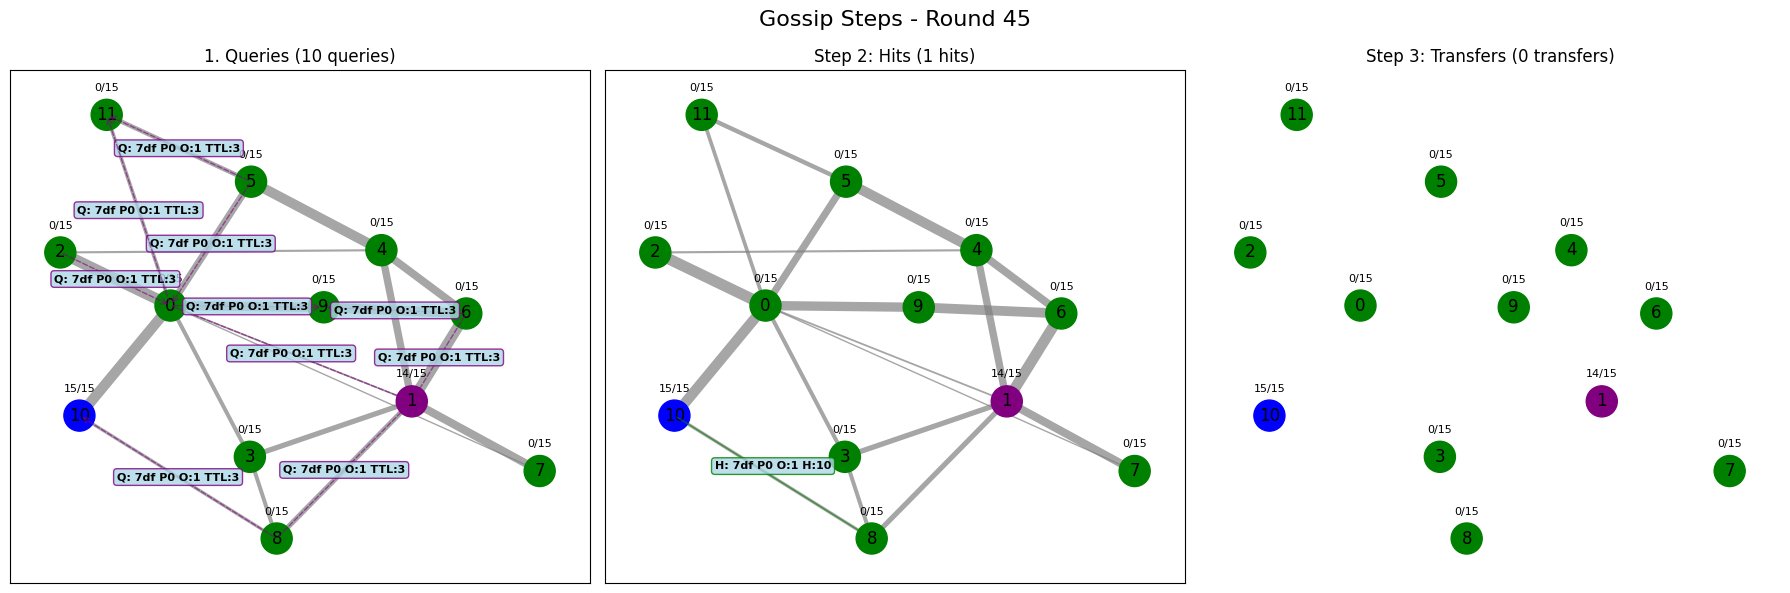


 Round 46
Messages: 4
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_046_gossip_steps.png


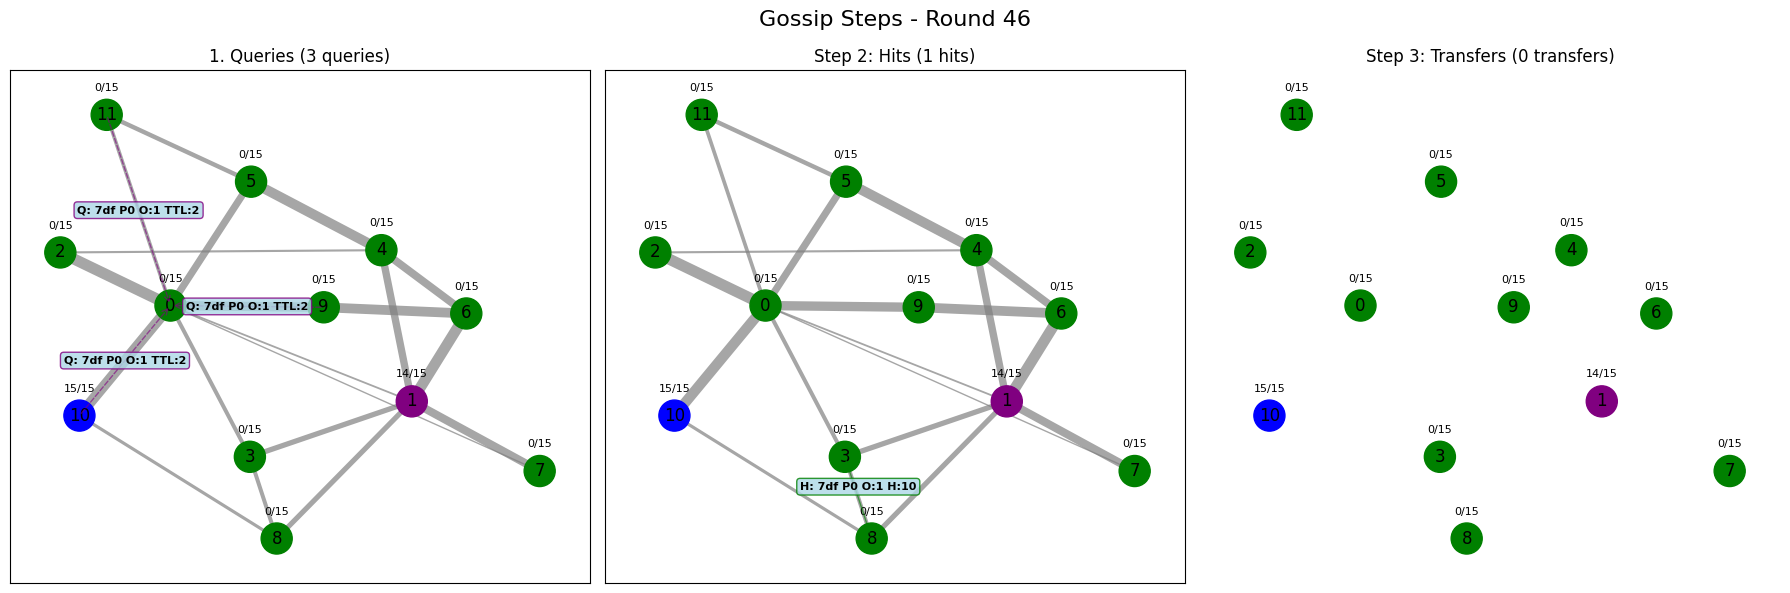


 Round 47
Messages: 1
Transfers: 1
New completions: [1]
Progress: 10 leechers incomplete, 0.0% completion rate
transfers:
  Piece 0: 10 to >> 1
Gossip step-by-step image: data/simulation_20251010_2039/round_047_gossip_steps.png


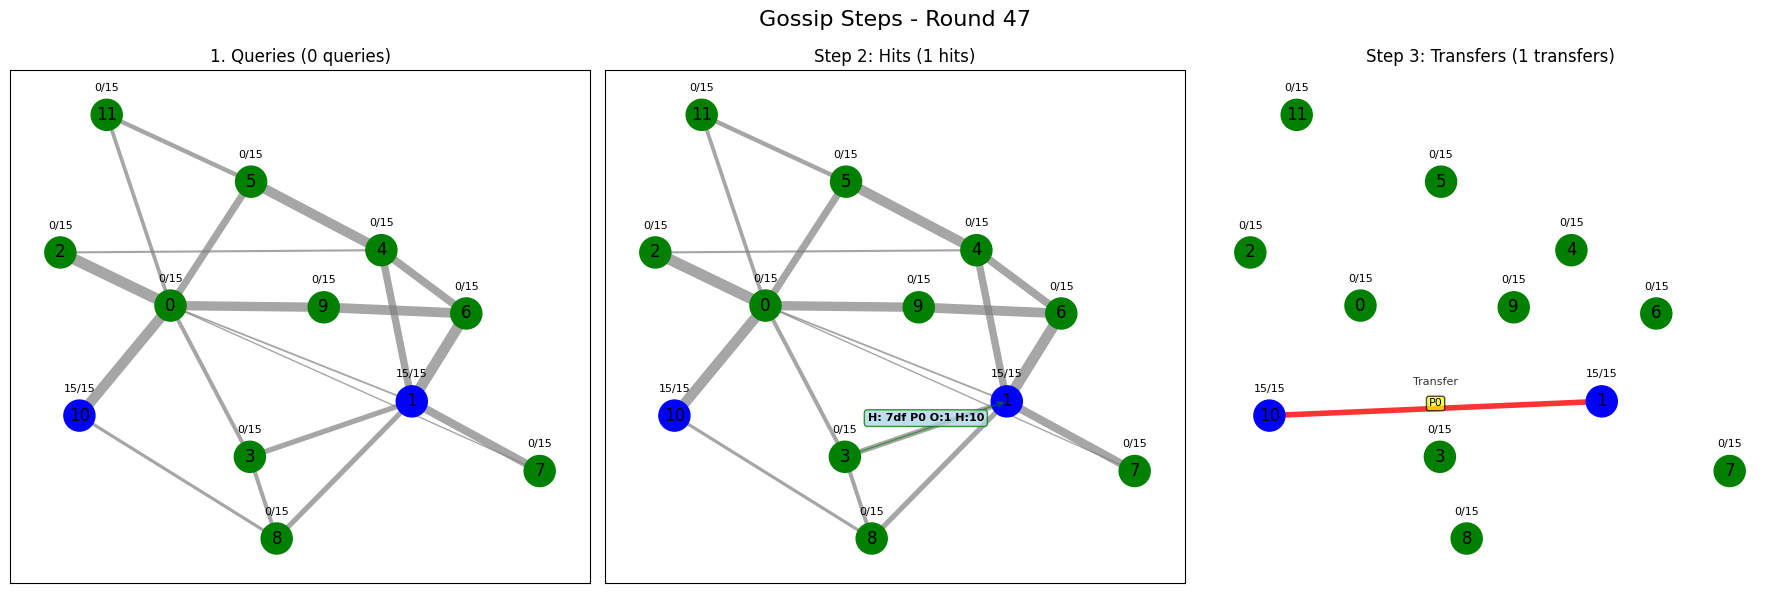


 Round 48
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_048_gossip_steps.png


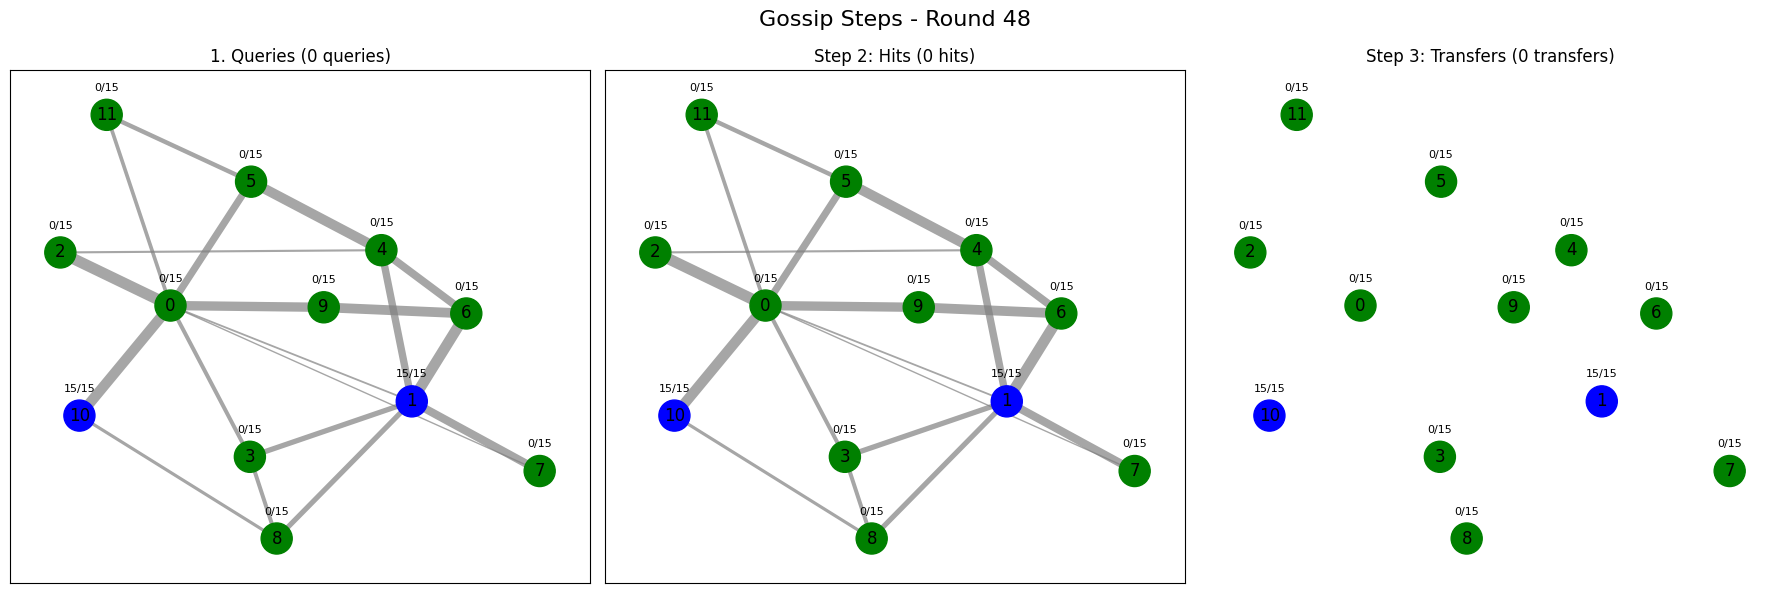


 Round 49
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_049_gossip_steps.png


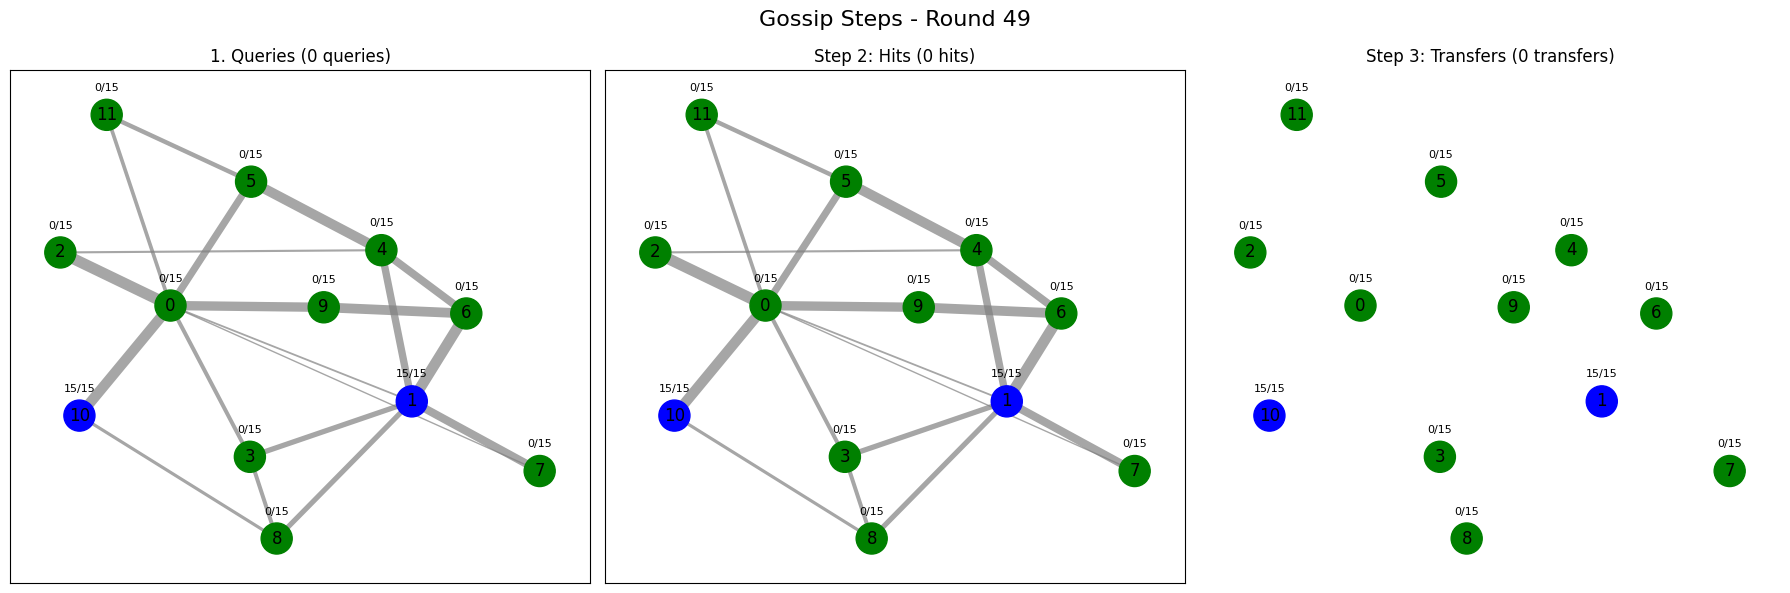


 Round 50
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_050_gossip_steps.png


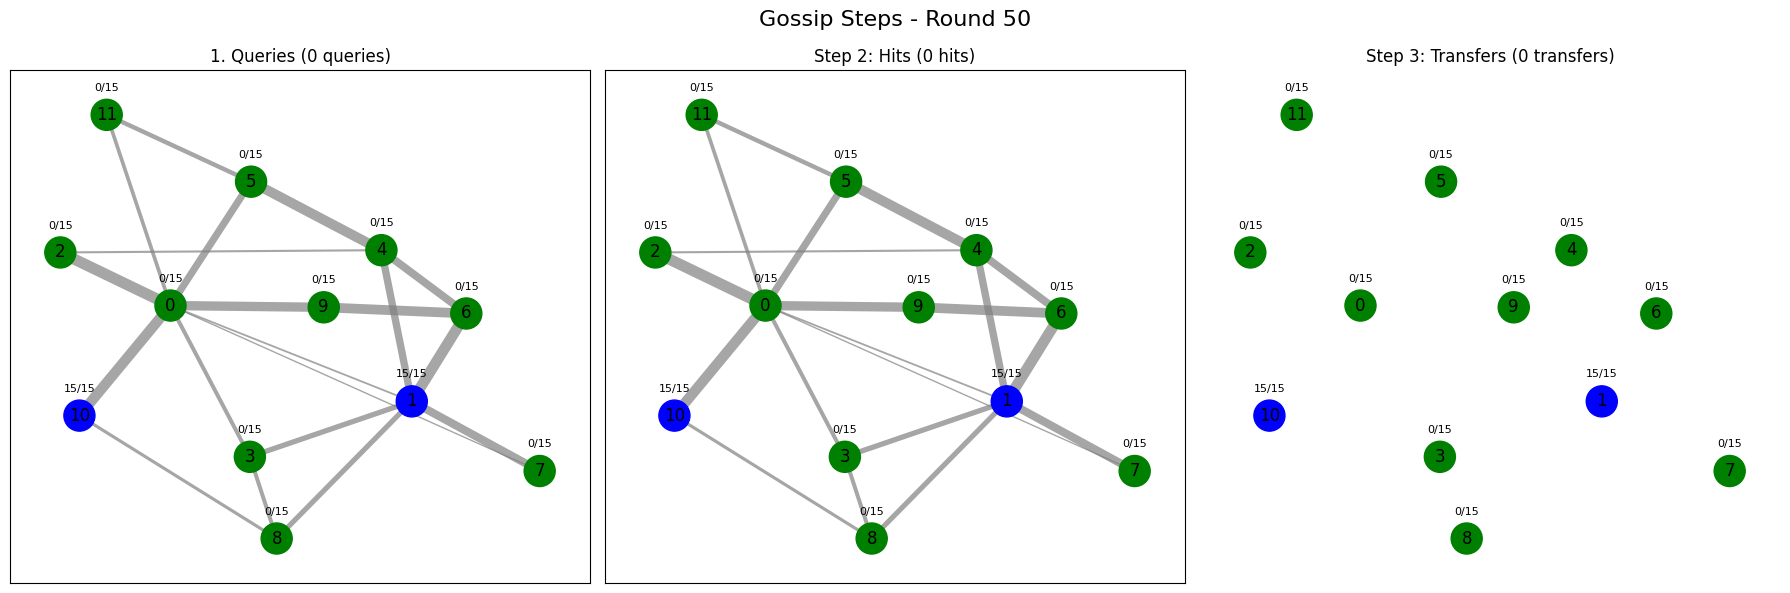


 Round 51
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_051_gossip_steps.png


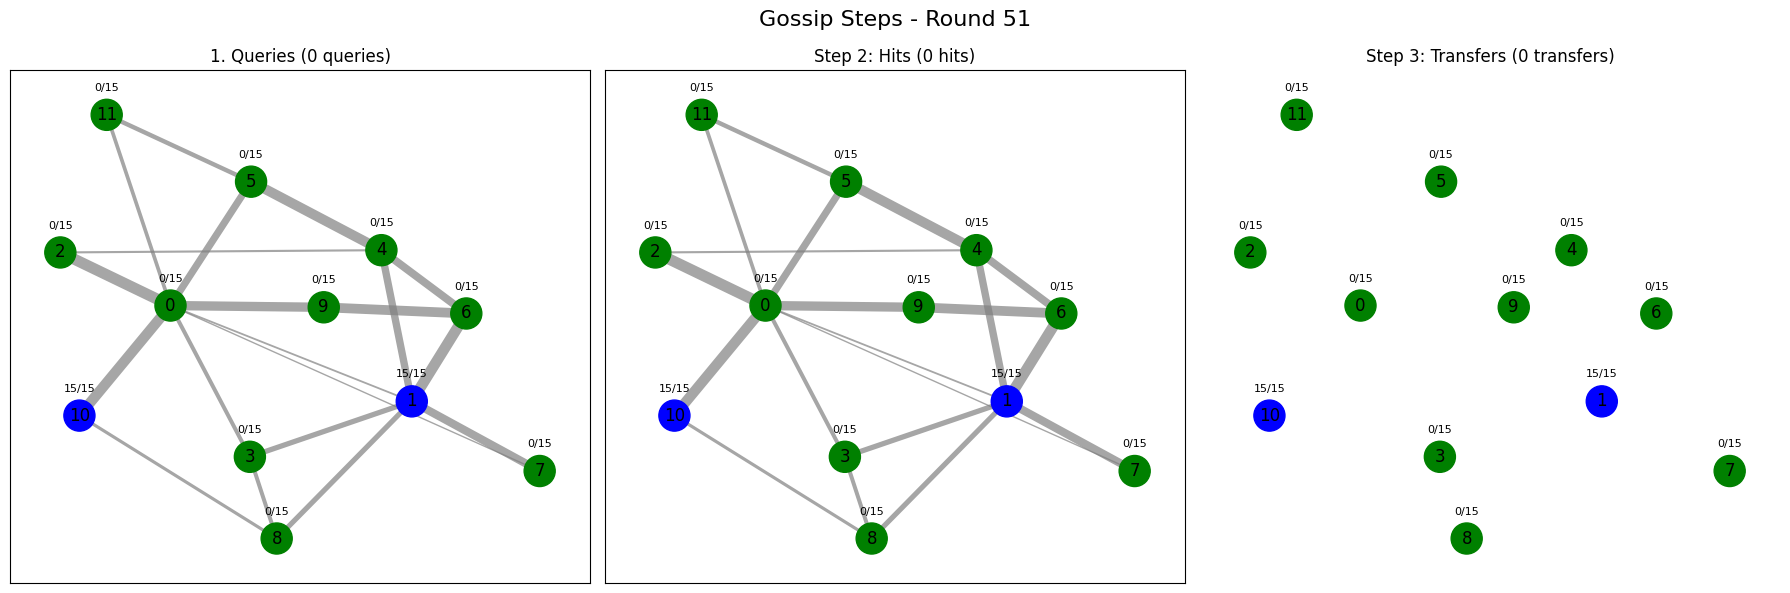


 Round 52
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_052_gossip_steps.png


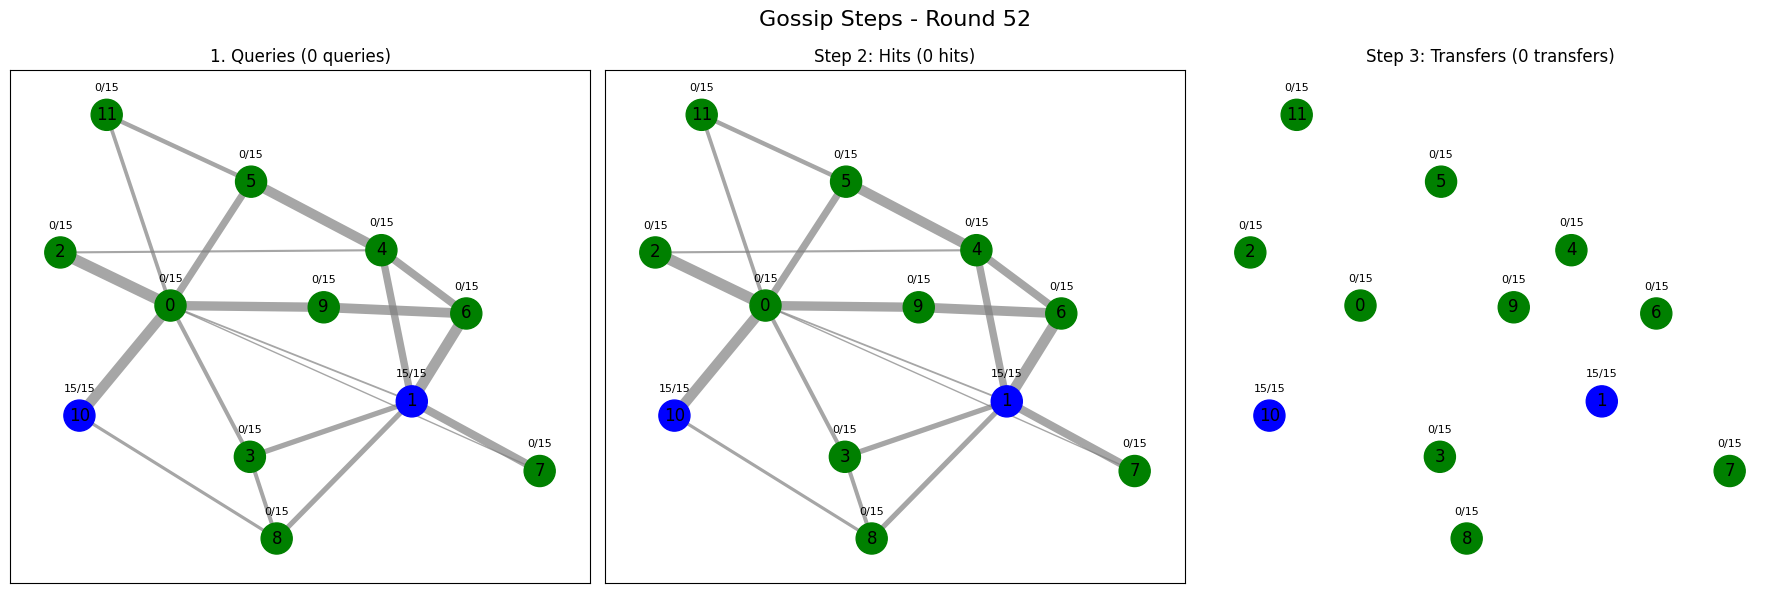


 Round 53
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_053_gossip_steps.png


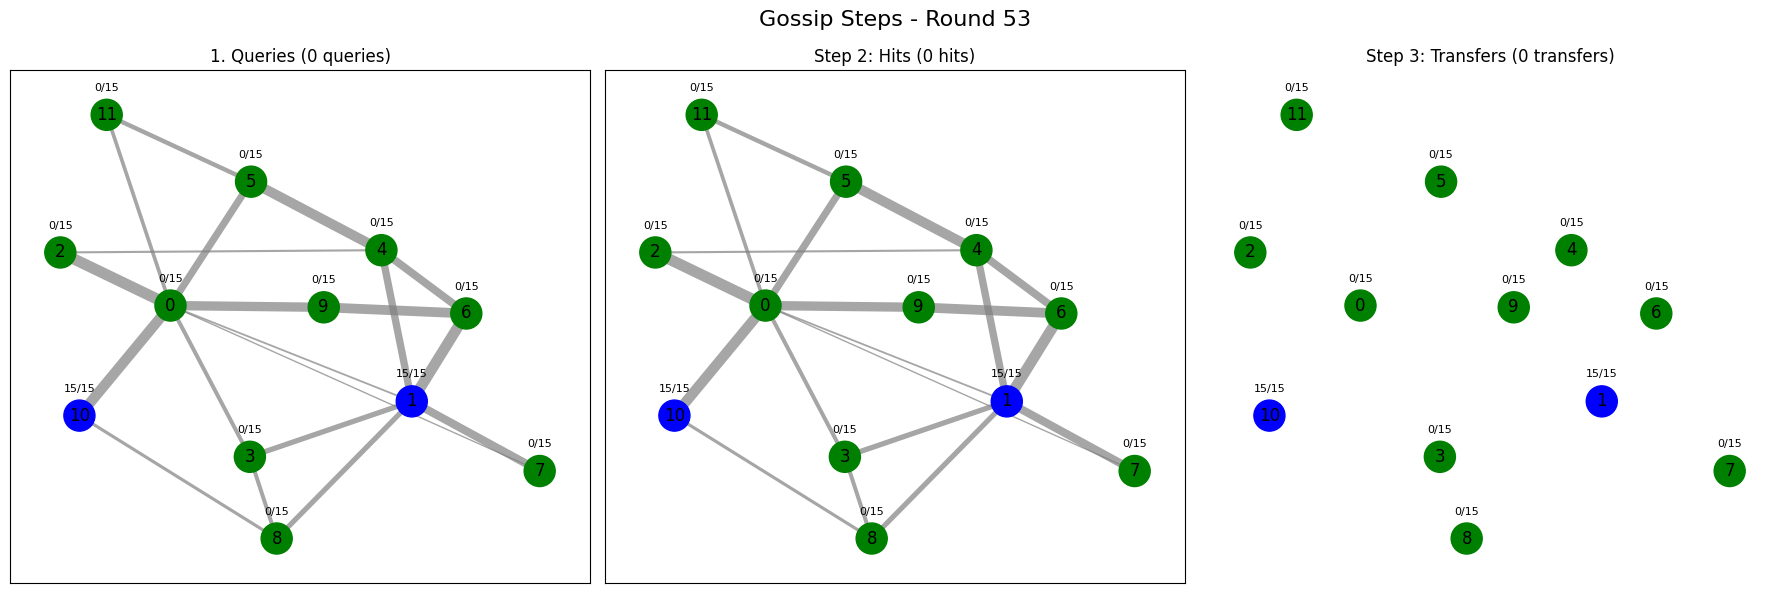


 Round 54
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_054_gossip_steps.png


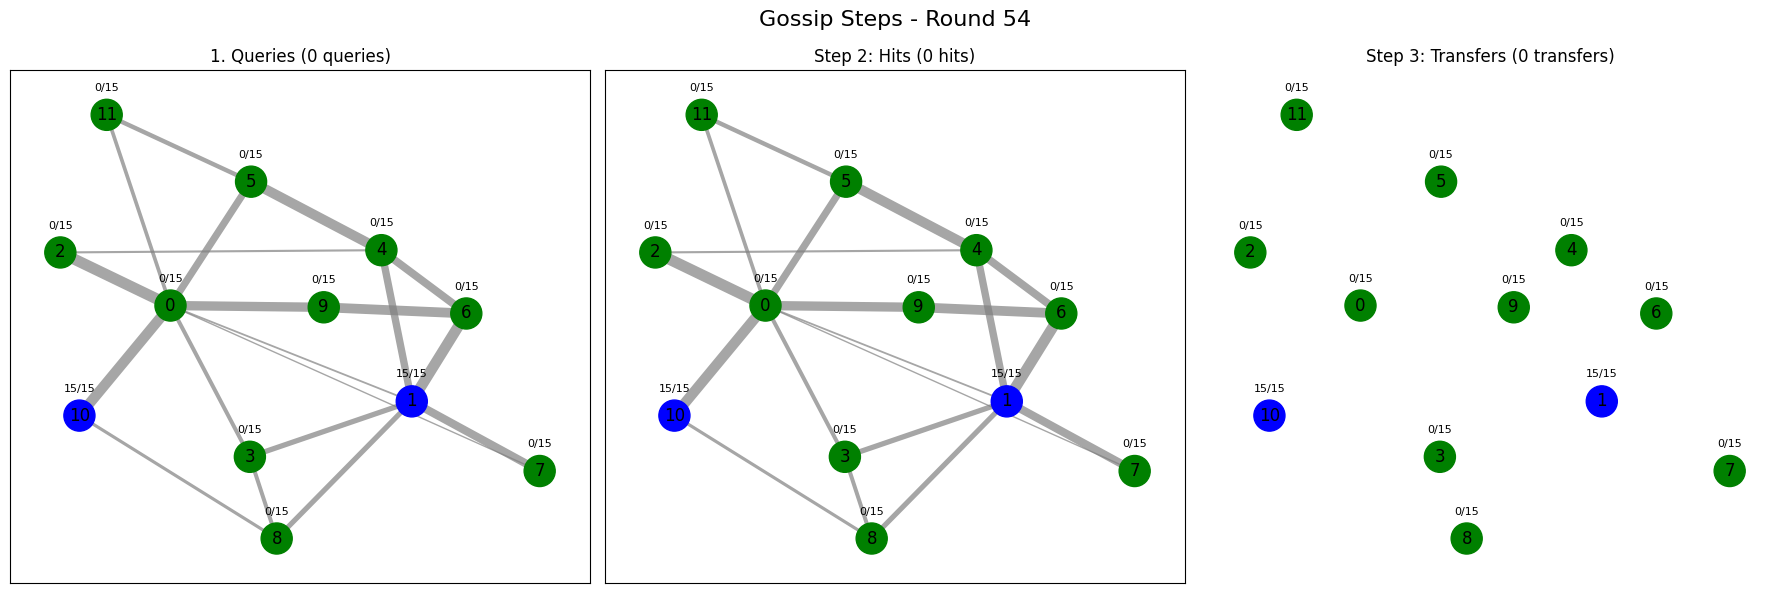


 Round 55
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_055_gossip_steps.png


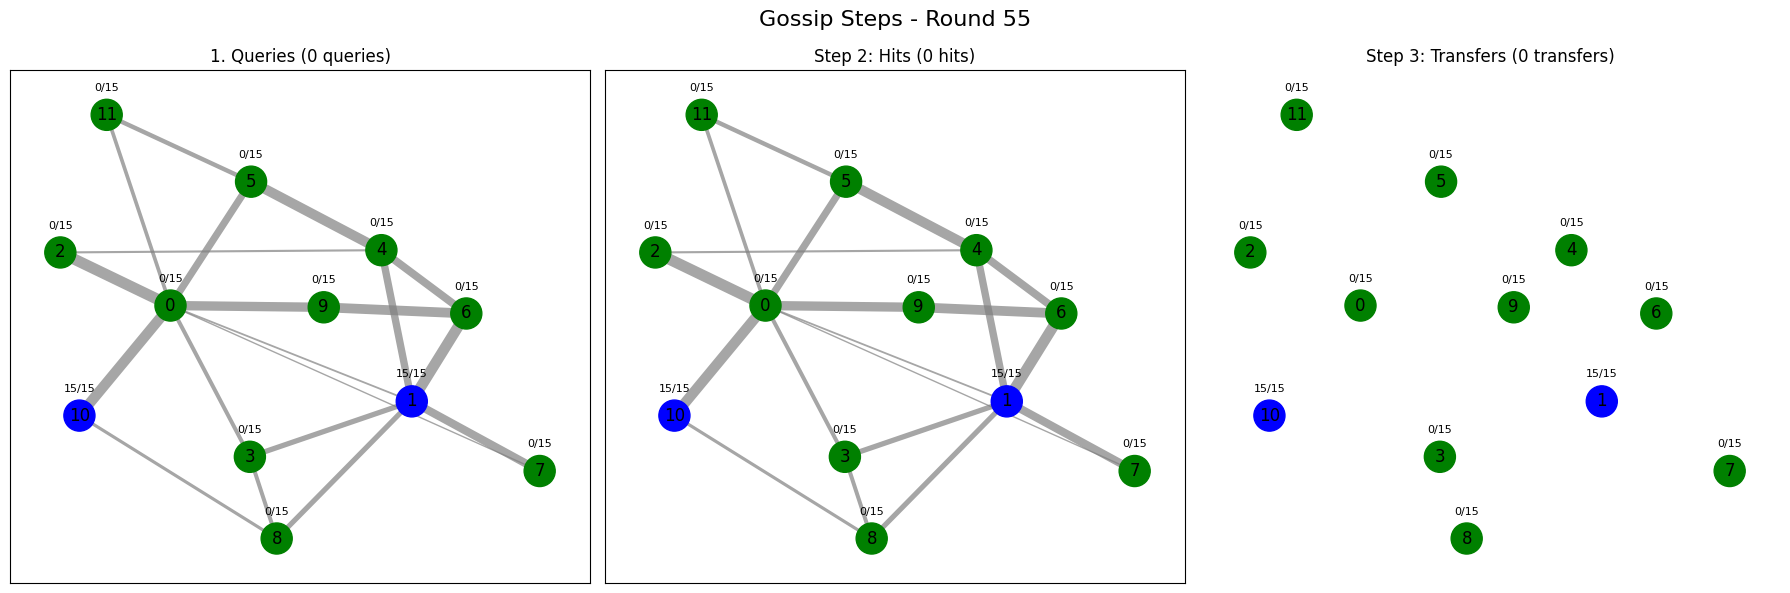


 Round 56
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_056_gossip_steps.png


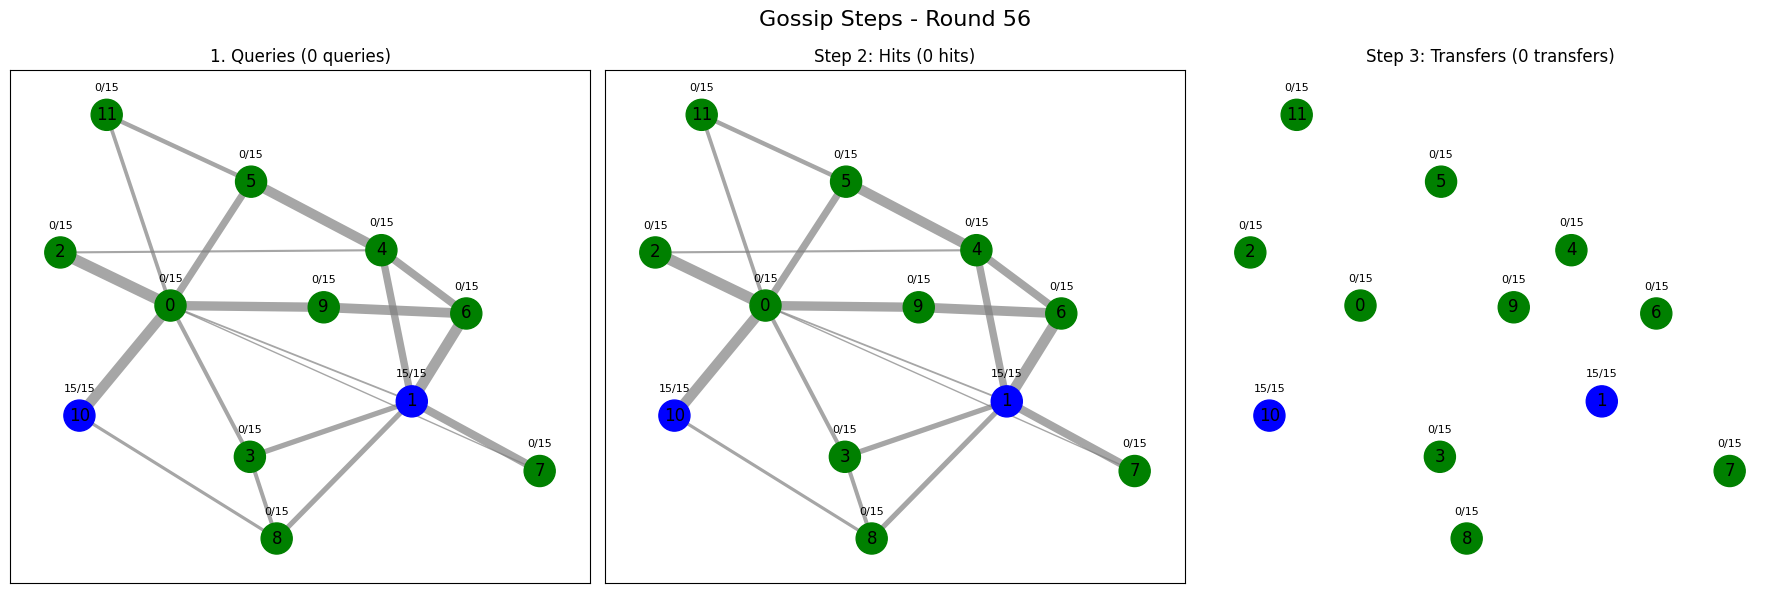


 Round 57
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_057_gossip_steps.png


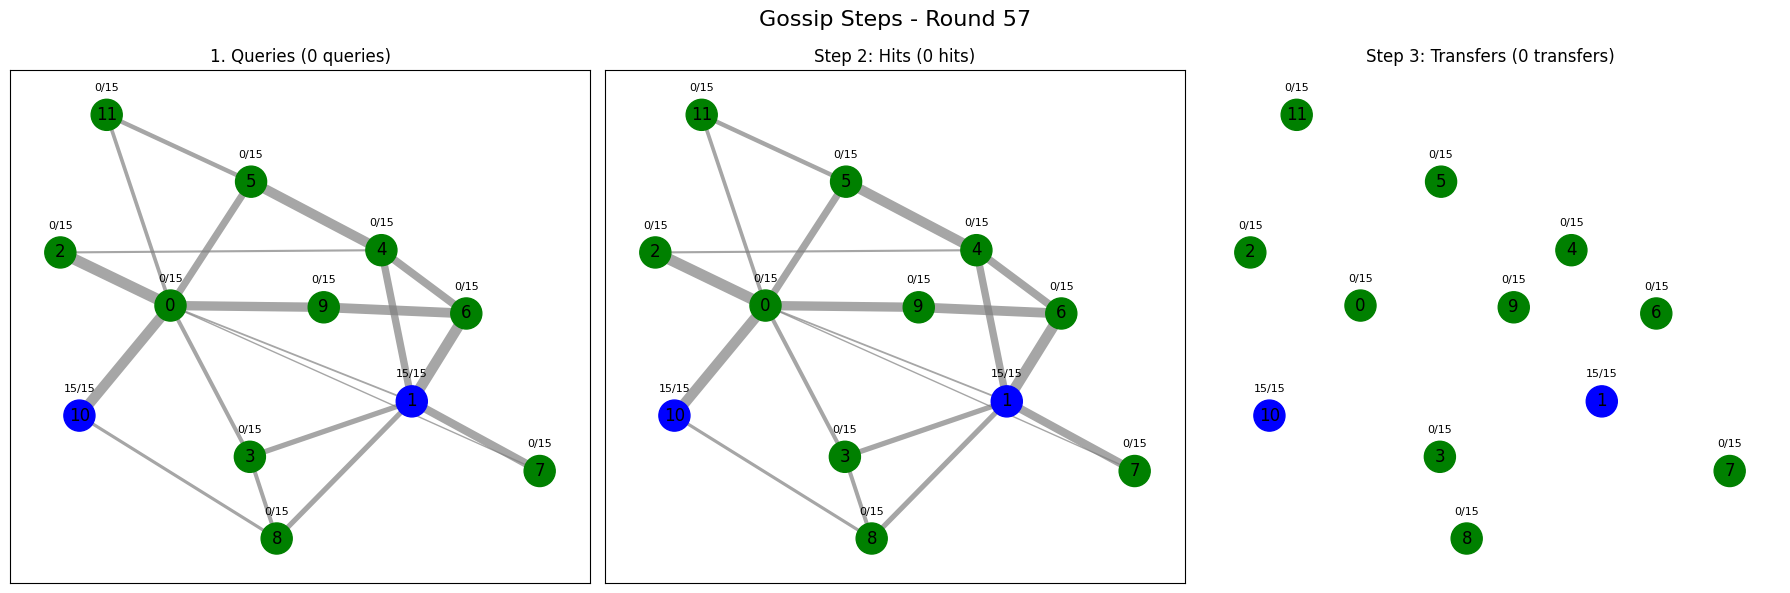


 Round 58
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_058_gossip_steps.png


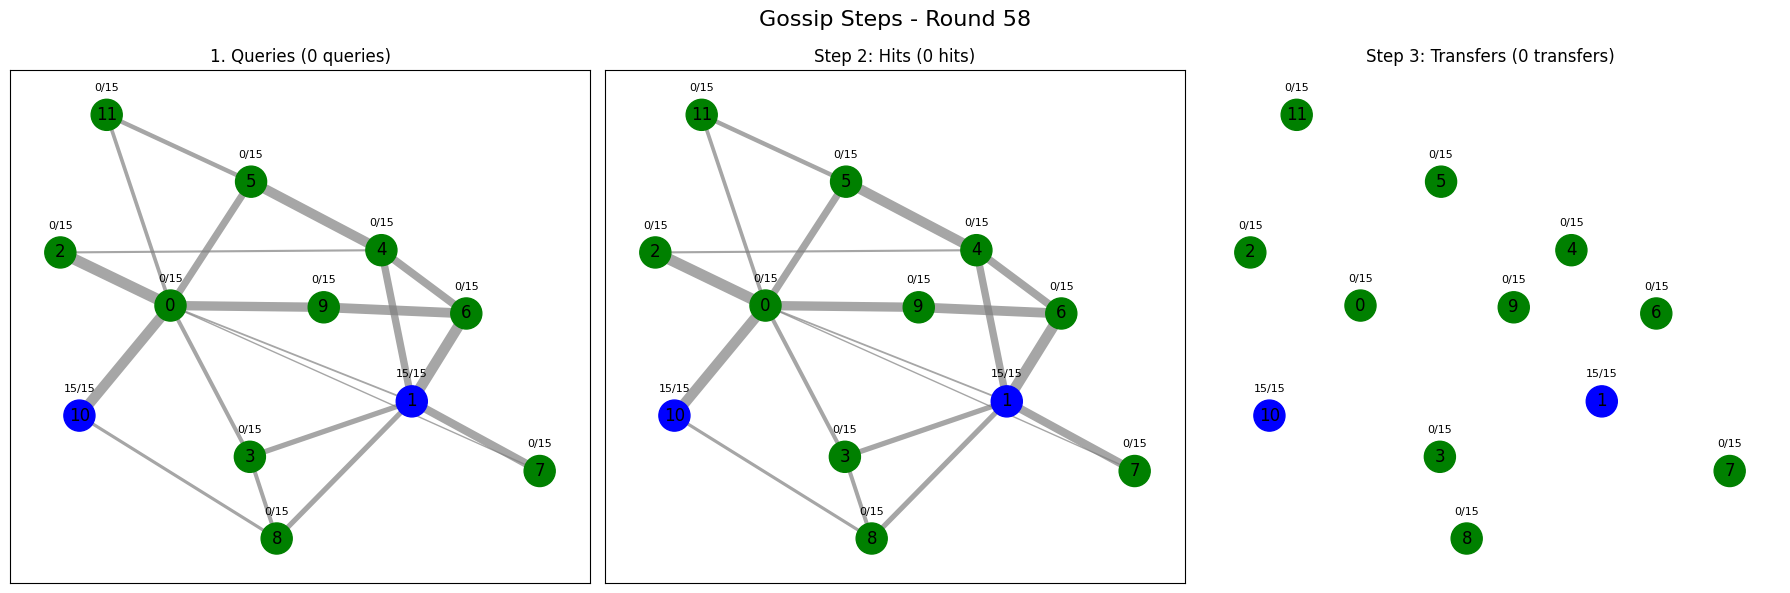


 Round 59
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_059_gossip_steps.png


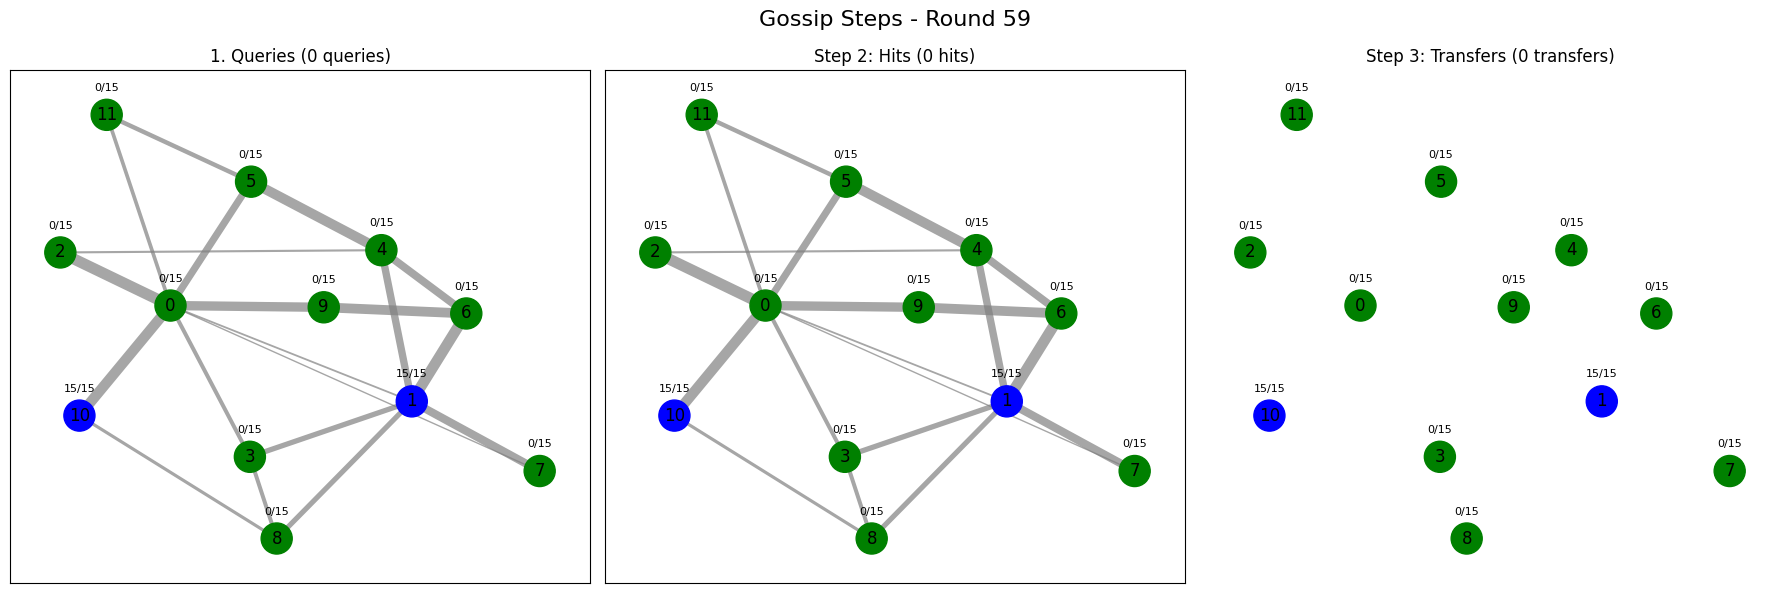


 Round 60
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_060_gossip_steps.png


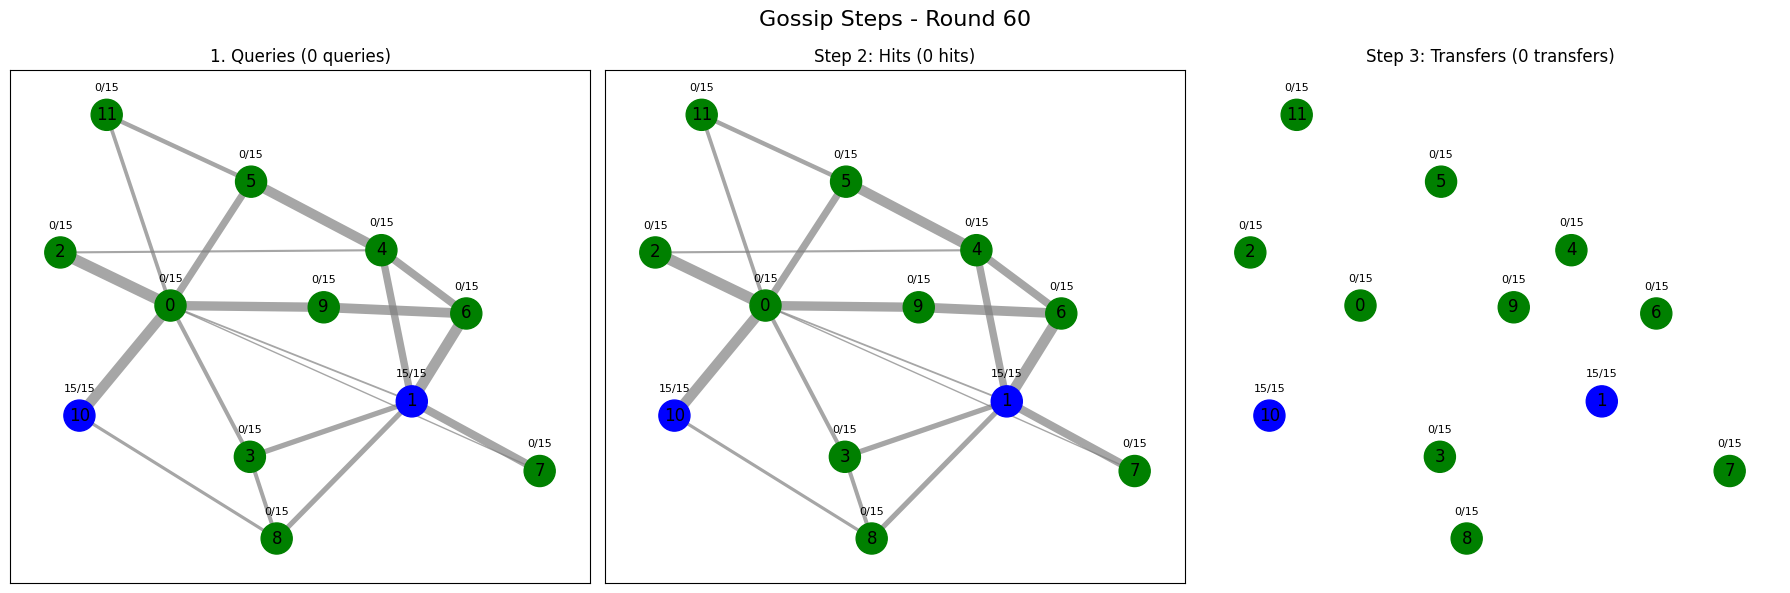


 Round 61
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_061_gossip_steps.png


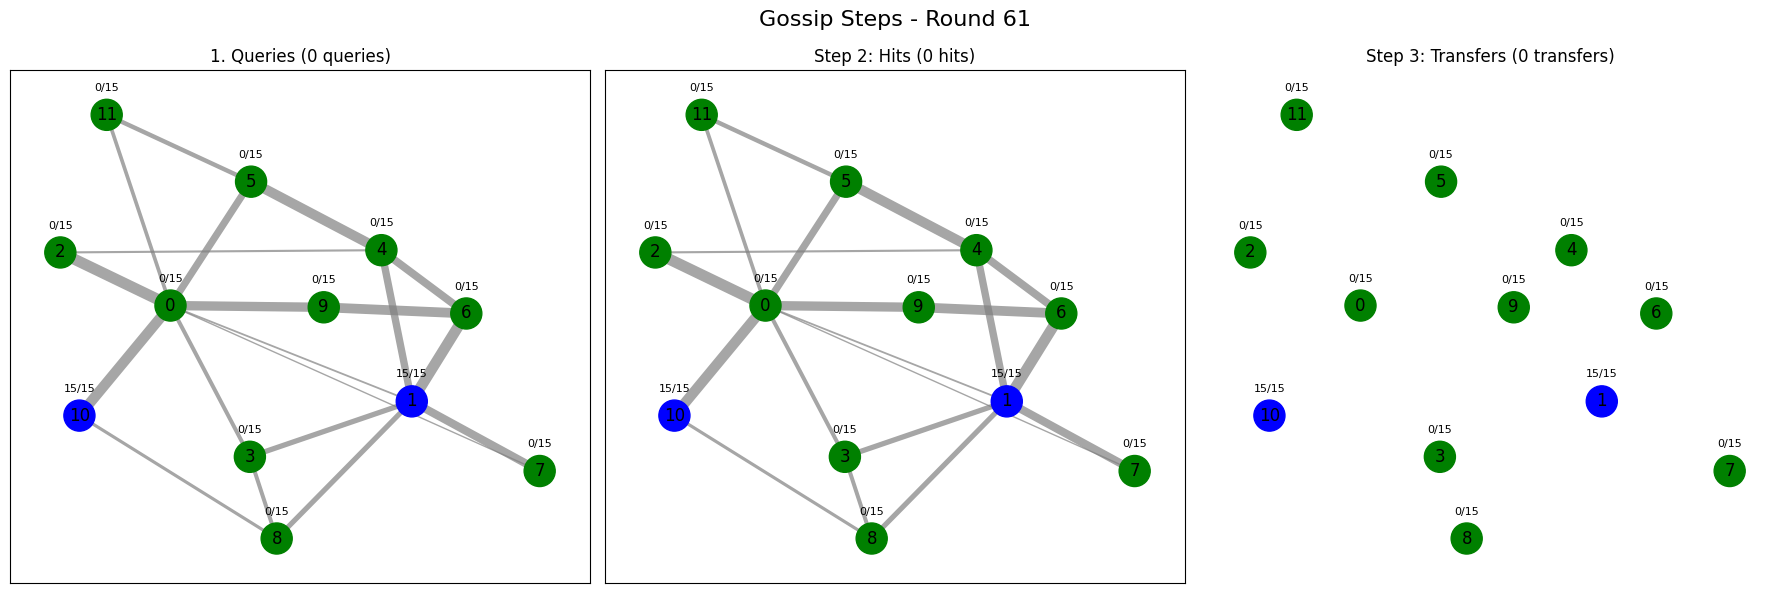


 Round 62
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_062_gossip_steps.png


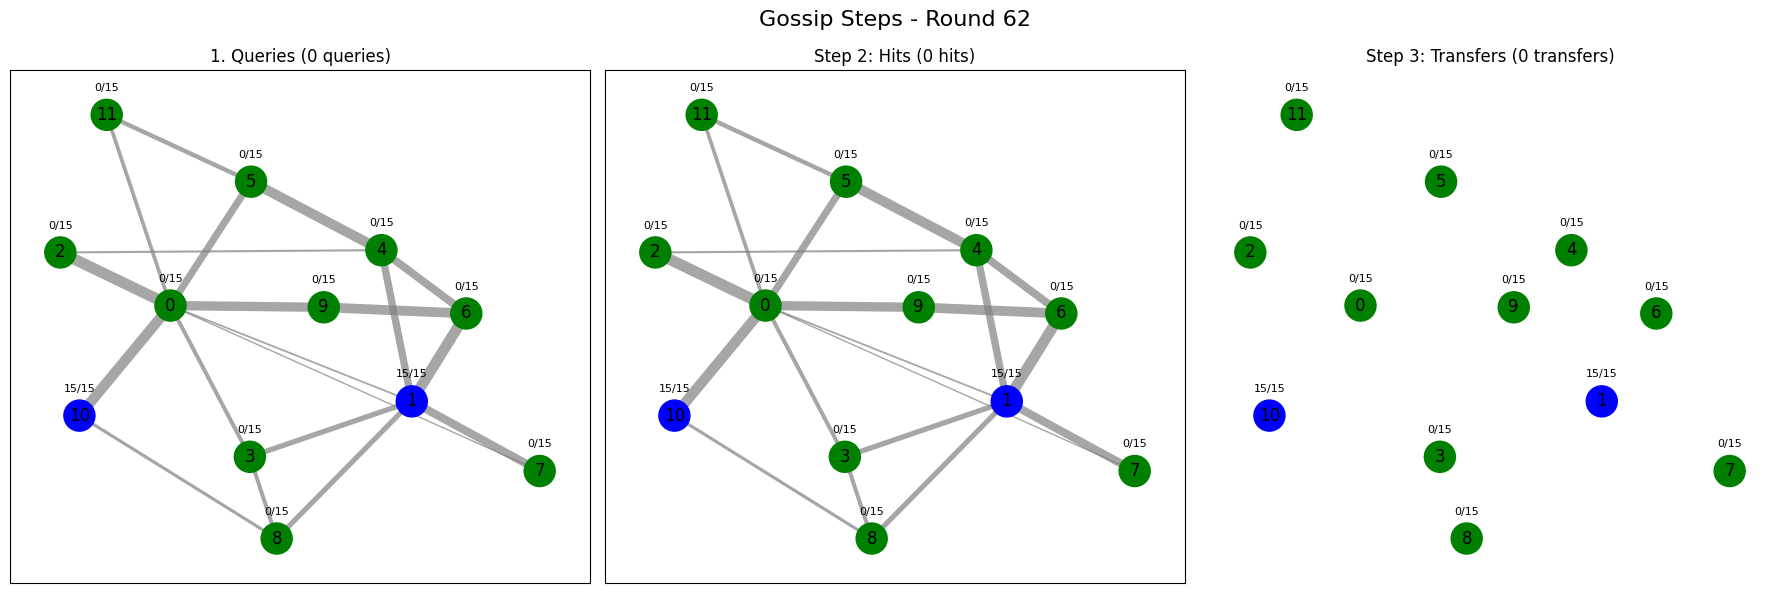


 Round 63
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_063_gossip_steps.png


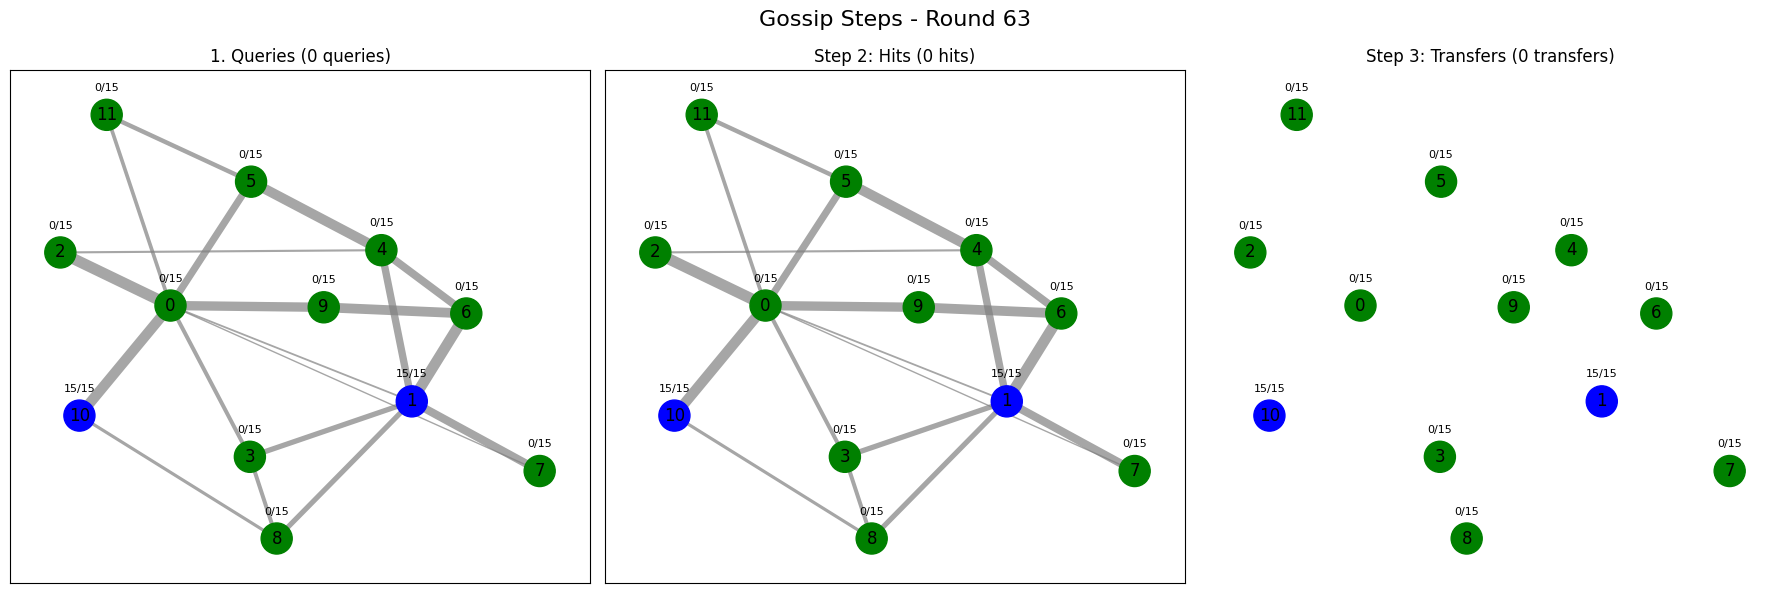


 Round 64
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_064_gossip_steps.png


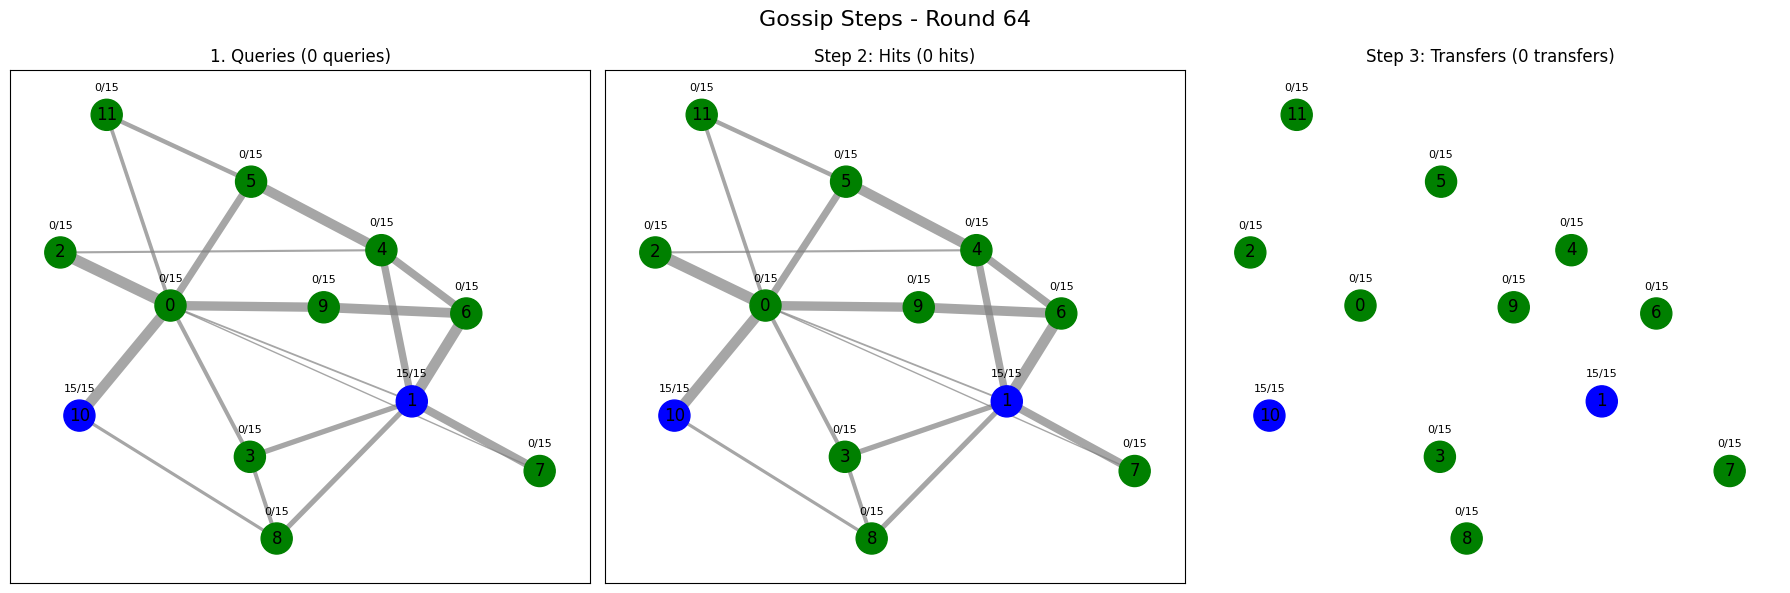


 Round 65
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_065_gossip_steps.png


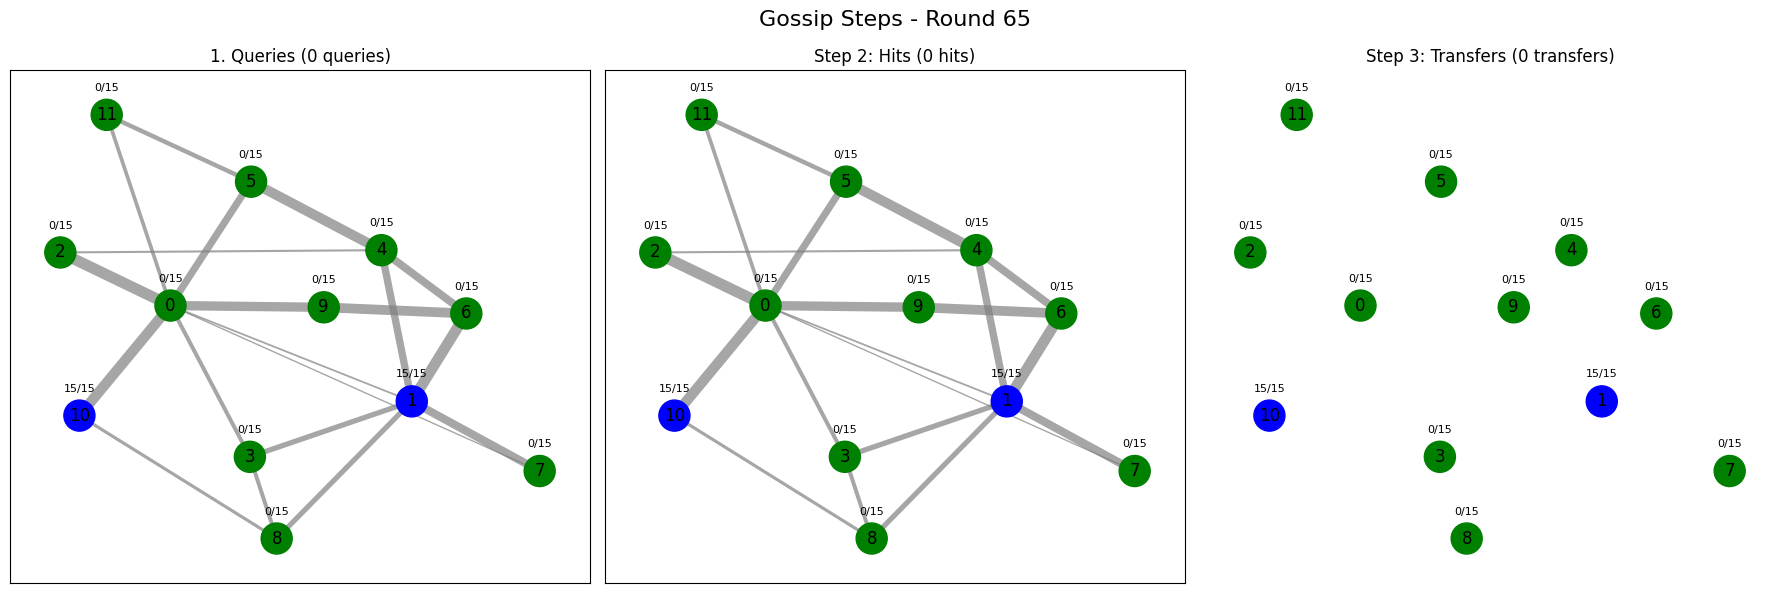


 Round 66
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_066_gossip_steps.png


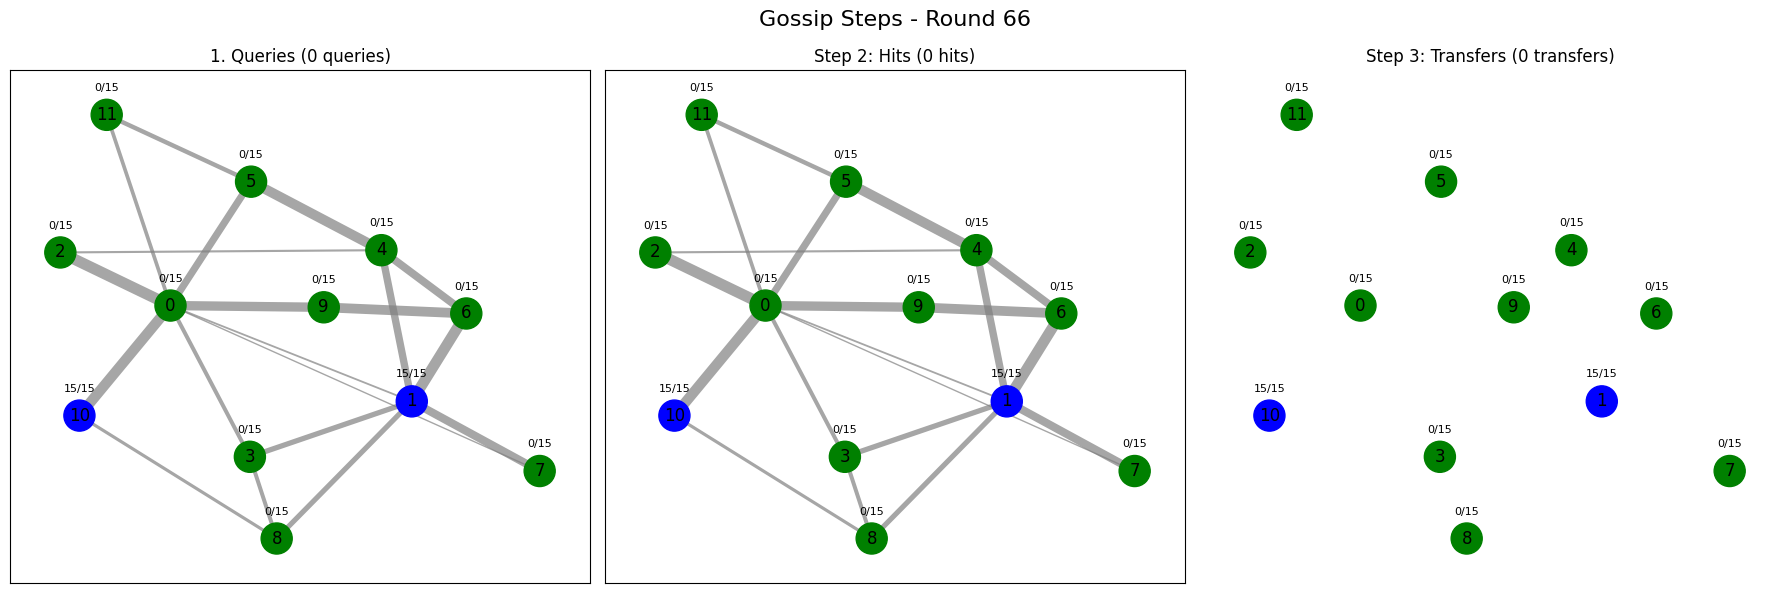


 Round 67
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_067_gossip_steps.png


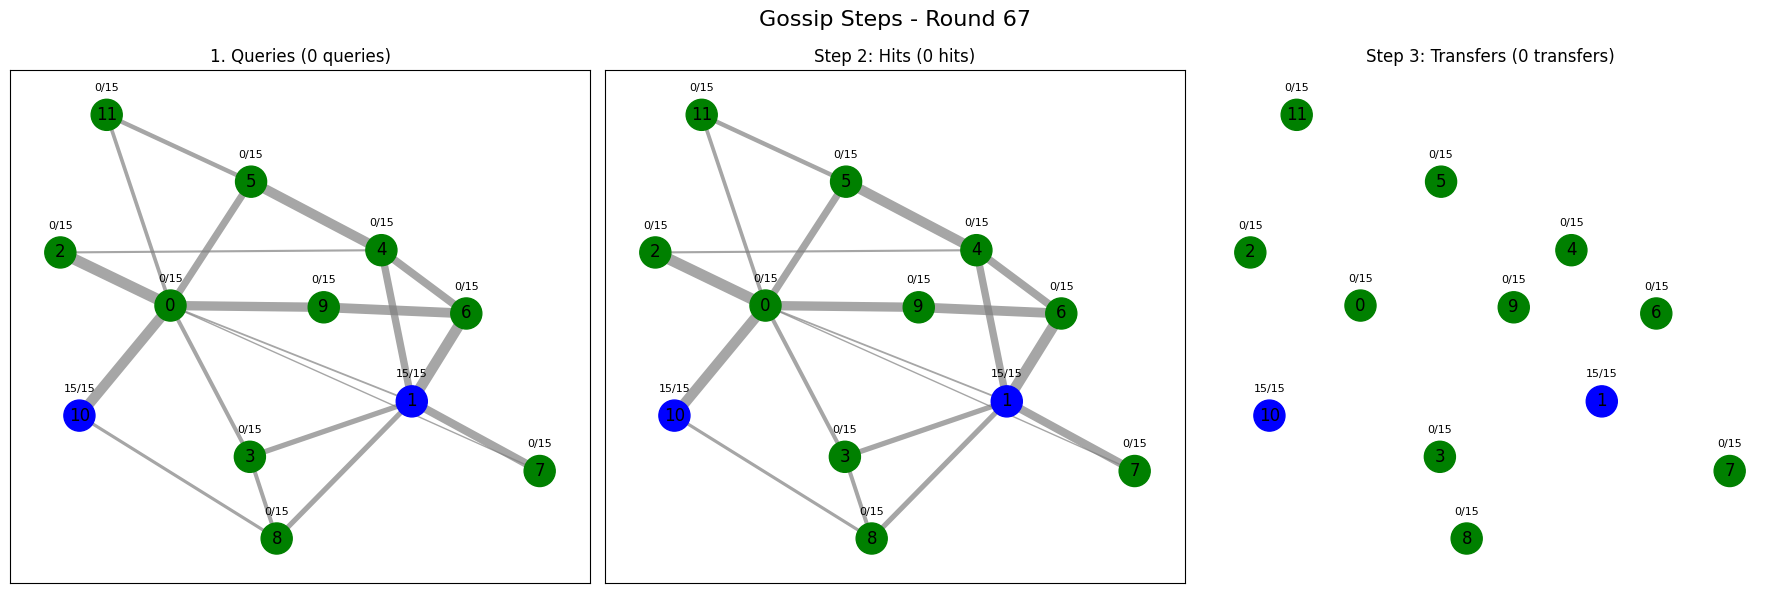


 Round 68
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_068_gossip_steps.png


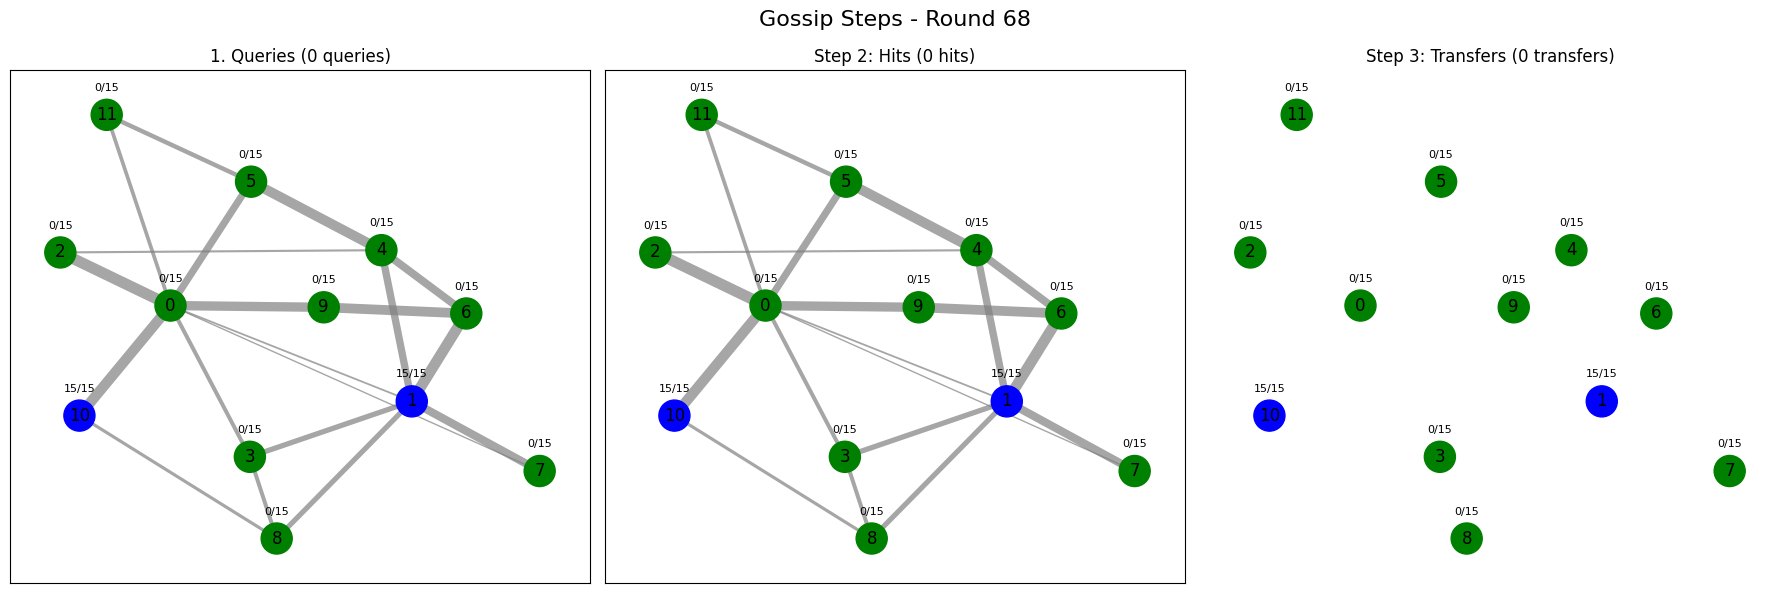


 Round 69
Messages: 0
Transfers: 0
Progress: 10 leechers incomplete, 0.0% completion rate
Gossip step-by-step image: data/simulation_20251010_2039/round_069_gossip_steps.png


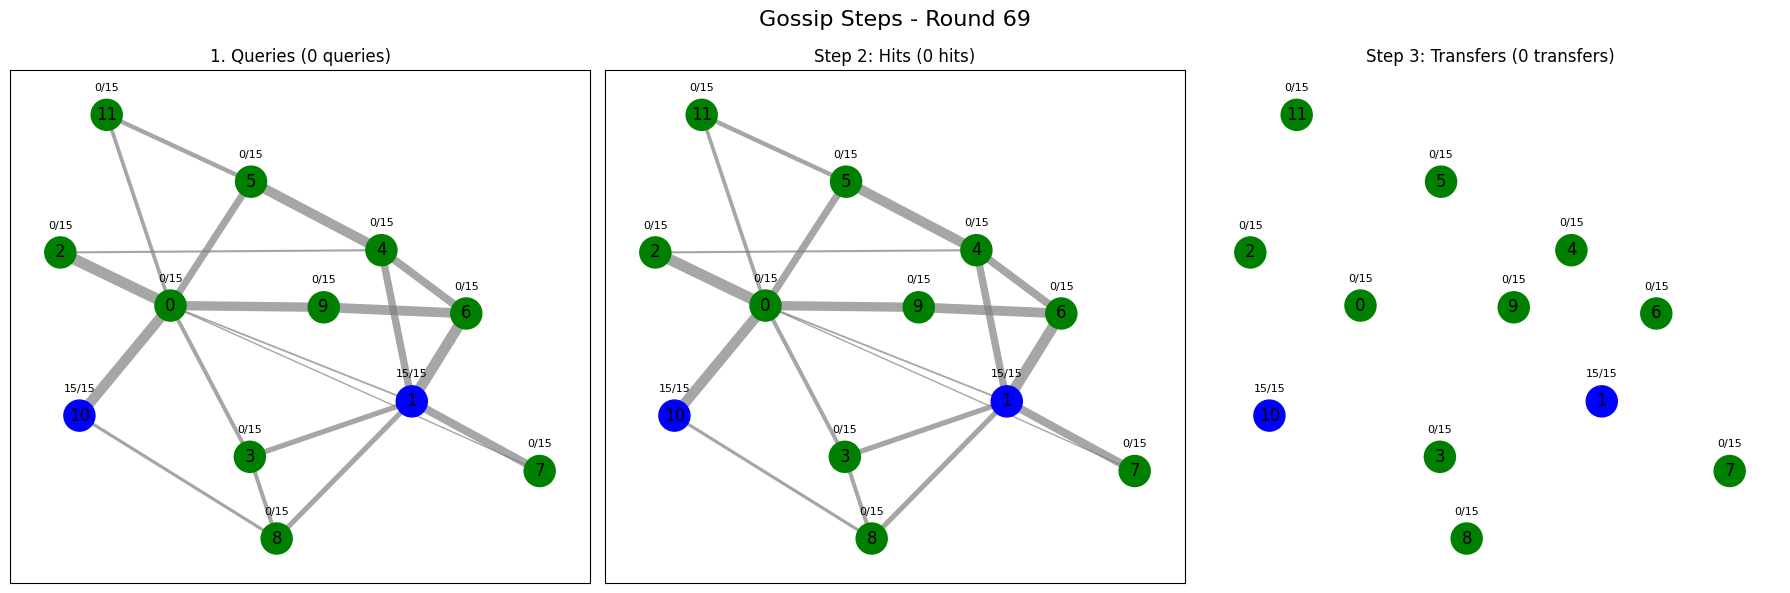

Total failures across all agents: 0
Unique pieces that failed: 0
Pieces that failed: []
Average rounds to completion: 47.0
Completion times: {1: 47}

Final network state:
Node 0: leecher - 0/15 pieces - Complete: False
Node 1: seeder - 15/15 pieces - Complete: True
Node 2: leecher - 0/15 pieces - Complete: False
Node 3: leecher - 0/15 pieces - Complete: False
Node 4: leecher - 0/15 pieces - Complete: False
Node 5: leecher - 0/15 pieces - Complete: False
Node 6: leecher - 0/15 pieces - Complete: False
Node 7: leecher - 0/15 pieces - Complete: False
Node 8: leecher - 0/15 pieces - Complete: False
Node 9: leecher - 0/15 pieces - Complete: False
Node 10: seeder - 15/15 pieces - Complete: True
Node 11: leecher - 0/15 pieces - Complete: False

Final network statistics:
Total nodes: 12
Total edges: 20
Seeders: 2
Leechers: 10
Complete leechers: 0
Incomplete leechers: 10
Completion rate: 0.0%
Total pieces in network: 30

Final graph visualization:
Found 69 images to compile into GIF


In [ ]:
# Start simulation with the current graph

# Check if graph has been generated
if 'G' not in globals() or not graph_generated:
    print("No Graph")
    print("Run the first cell, click 'Generate Graph' to create a network.")
    raise RuntimeError("Graph must be generated before proceeding")

print(f"Starting Model graph with {G.graph.number_of_nodes()} nodes and {G.graph.number_of_edges()} edges")

stats = get_network_stats(G.graph, FILE_PIECES)
print(f"Initial: {stats['incomplete_leechers']} leechers incomplete, {stats['completion_rate']:.1%} completion rate")
output_dir = start_new_run()

retry_stats = {
    'total_retries': 0,
    'pieces_retried': set(),
    'rounds_to_completion': {},
    'previous_failed_pieces': {}
}


# Run one round of simulation
for round_num in range(1, 70):
    print(f"\n Round {round_num}")


#  Simulate Round Setup
    #     G: NetworkX graph
    #     total_pieces: Total number of file pieces
    #     seed: Random seed for reproducibility
    #     single_agent: Force only this agent to search (if specified)
    #     cleanup_completed_queries: Whether to clean up completed queries (helps with clutter, otherwise leftover q/h bounce around until TTL)
    #     search_mode: Search initiation mode
    #     K: Number of neighbors to forward queries to
    #     ttl: Time-to-live for queries (number of hops)
    #     max_searches_per_round: Maximum concurrent searches (for limited mode)
    #     current_round: The current round number (for retry tracking)
    #     neighbor_selection: Neighbor selection method
    
    # search_mode options:
    #- "single": Only one (random) node searches per round
    #- "realistic": Each agent decides independently

    # neighbor_selection options:
    #- "bandwidth": Select k neighbors based on bandwidth weights
    #- "random": Select k neighbors randomly

    result = simulate_round(G.graph, FILE_PIECES, seed=42+round_num, cleanup_completed_queries=True, search_mode="realistic", single_agent=1, current_round=round_num, neighbor_selection="random")
    
    print(f"Messages: {result['total_messages']}")
    print(f"Transfers: {result['total_transfers']}")
    if result['new_completions']:
        print(f"New completions: {result['new_completions']}")
        for node in result['new_completions']:
            retry_stats['rounds_to_completion'][node] = round_num
    
    # Track when pieces fail (timeout)
    for node in G.graph.nodes():
        agent = G.graph.nodes[node].get('agent_object')
        if agent and agent.failed_pieces:
            prev_failed = retry_stats['previous_failed_pieces'].get(node, {})
            for piece, fail_count in agent.failed_pieces.items():
                prev_count = prev_failed.get(piece, 0)
                if fail_count > prev_count:
                    new_failures = fail_count - prev_count
                    retry_stats['total_retries'] += new_failures  # Keep same variable name for compatibility
                    retry_stats['pieces_retried'].add(piece)
                    print(f"  Node {node} failed piece {piece} {new_failures} times (total failures: {fail_count})")
            
            # Update previous state
            retry_stats['previous_failed_pieces'][node] = dict(agent.failed_pieces)
    
    stats = get_network_stats(G.graph, FILE_PIECES)
    print(f"Progress: {stats['incomplete_leechers']} leechers incomplete, {stats['completion_rate']:.1%} completion rate")
    
    # Show some transfer details
    if result['transfers']:
        print("transfers:")
        for transfer in result['transfers']:  # Show first handful
            print(f"  Piece {transfer['piece']}: {transfer['from']} to >> {transfer['to']}")
    
    # Show step-by-step gossip
    draw_gossip_step_by_step(G.graph, result['message_rounds'], result['transfers'], 
                            FILE_PIECES, round_num, save_images=True)
                            
    # if stats['completion_rate'] >= 1.0:
    #     print(f"\nAll nodes have all pieces in{round_num} round")
    #     break


print(f"Total failures across all agents: {retry_stats['total_retries']}")
print(f"Unique pieces that failed: {len(retry_stats['pieces_retried'])}")
print(f"Pieces that failed: {sorted(retry_stats['pieces_retried'])}")
if retry_stats['rounds_to_completion']:
    avg_rounds = sum(retry_stats['rounds_to_completion'].values()) / len(retry_stats['rounds_to_completion'])
    print(f"Average rounds to completion: {avg_rounds:.1f}")
    print(f"Completion times: {retry_stats['rounds_to_completion']}")
    
print(f"\nFinal network state:")
for node in G.graph.nodes():
    info = agent_module.get_agent_info(G.graph, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/{FILE_PIECES} pieces - Complete: {info['is_complete']}")
#
final_stats = get_network_stats(G.graph, FILE_PIECES)


print(f"\nFinal network statistics:")
print(f"Total nodes: {final_stats['total_nodes']}")
print(f"Total edges: {final_stats['total_edges']}")
print(f"Seeders: {final_stats['seeders']}")
print(f"Leechers: {final_stats['leechers']}")
print(f"Complete leechers: {final_stats['complete_leechers']}")
print(f"Incomplete leechers: {final_stats['incomplete_leechers']}")
print(f"Completion rate: {final_stats['completion_rate']:.1%}")
print(f"Total pieces in network: {final_stats['total_pieces_in_network']}")

# Draw the final graph
print(f"\nFinal graph visualization:")
gifs = create_round_gif(duration=300)
draw_graph(G.graph, total_pieces=FILE_PIECES)